In [2]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform

# %load_ext autoreload
# %reload_ext autoreload

In [3]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# num_samples = 100
# R = 64
    
# # make_random_line_set(num_samples,R,dev,zero_center,delta=.25,eta=0.005)
# dists,wedges,boundaries,params = make_random_line_set(num_samples,R,dev,1)

# # make_grey_transform(num_images,dev,opt=0)
# grey_transform = make_grey_transform(num_samples,dev)

# wedges_grey = (wedges[:,:2,:,:,:,:]*grey_transform).sum(1).squeeze(1)

In [4]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [5]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

# Centered, bicolored images, noiseless - 62 parameters

In [344]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_1000_grey_bicolor_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

In [345]:
print(wedges_grey.shape)
print(params.shape)
print(boundaries.shape)
print(wedges.shape)

line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)


W,H = 32,32


torch.Size([1000, 1, 32, 32])
torch.Size([1000, 3, 1, 1])
torch.Size([1000, 1, 1, 32, 32])
torch.Size([1000, 3, 1, 1, 32, 32])
1000


In [346]:
class lineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x,p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = lineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 30, 30]              10
         MaxPool2d-2            [-1, 1, 15, 15]               0
         AvgPool2d-3              [-1, 1, 5, 5]               0
            Linear-4                    [-1, 2]              52
Total params: 62
Trainable params: 62
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 1.0459582342041864, Avg. Test Loss: 1.0487654209136963
Epoch: 2, Avg. Train Loss: 0.8562057349416945, Avg. Test Loss: 0.9381113648414612
Epoch: 3, Avg. Train Loss: 0.613802053310253, Avg. Test Loss: 0.6741875410079956
Epoch: 4, Avg. Train Loss: 0.3581424148546325, Avg. Test Loss: 0.2521728277206421
Epoch: 5, Avg. Train Loss: 0.06681345568762885, Avg. Test Loss: 0.020405225455760956
Epoch: 6, Avg. Train Loss: 0.01009798034404715, Avg. Test Loss: 0.008170440793037415
Epoch: 7, Avg. Train Loss: 0.006531970825529209, Avg. Test Loss: 0.006373896729201078
Epoch: 8, Avg. Train Loss: 0.005338935957600673, Avg. Test Loss: 0.005559246055781841
Epoch: 9, Avg. Train Loss: 0.0048330561171665235, Avg. Test Loss: 0.004920919891446829
Epoch: 10, Avg. Train Loss: 0.004220202030545032, Avg. Test Loss: 0.004530050791800022
Epoch: 11, Avg. Train Loss: 0.003971140297060764, Avg. Test Loss: 0.004108688794076443
Epoch: 12, Avg. Train Loss: 0.003748707240447402, Avg. Test Loss: 0.00

Epoch: 95, Avg. Train Loss: 0.00040147485991905407, Avg. Test Loss: 0.00033406843431293964
Epoch: 96, Avg. Train Loss: 0.00038849984304289574, Avg. Test Loss: 0.00033782378886826336
Epoch: 97, Avg. Train Loss: 0.0003809254676862447, Avg. Test Loss: 0.0003037882852368057
Epoch: 98, Avg. Train Loss: 0.00036781254608218595, Avg. Test Loss: 0.0003045908233616501
Epoch: 99, Avg. Train Loss: 0.0003759789655709432, Avg. Test Loss: 0.0003362049756105989
Epoch: 100, Avg. Train Loss: 0.00035524889675865844, Avg. Test Loss: 0.0002899576793424785
Epoch: 101, Avg. Train Loss: 0.0003494351845734787, Avg. Test Loss: 0.0002886850561480969
Epoch: 102, Avg. Train Loss: 0.000373345129278109, Avg. Test Loss: 0.0003037846472579986
Epoch: 103, Avg. Train Loss: 0.00034804968648434925, Avg. Test Loss: 0.00032015322358347476
Epoch: 104, Avg. Train Loss: 0.00032977112277876586, Avg. Test Loss: 0.00028403272153809667
Epoch: 105, Avg. Train Loss: 0.0003239093833447744, Avg. Test Loss: 0.0002790690341498703
Epoch:

Epoch: 188, Avg. Train Loss: 0.00011623193212370906, Avg. Test Loss: 8.959636033978313e-05
Epoch: 189, Avg. Train Loss: 0.00010751620559151181, Avg. Test Loss: 9.032783418660983e-05
Epoch: 190, Avg. Train Loss: 0.00011228677990234078, Avg. Test Loss: 0.00012483863974921405
Epoch: 191, Avg. Train Loss: 0.0001157109522696205, Avg. Test Loss: 8.110429916996509e-05
Epoch: 192, Avg. Train Loss: 0.0001172336738414338, Avg. Test Loss: 8.253704436356202e-05
Epoch: 193, Avg. Train Loss: 0.00011176146573335346, Avg. Test Loss: 9.583605424268171e-05
Epoch: 194, Avg. Train Loss: 0.00010614819863500695, Avg. Test Loss: 9.774238424142823e-05
Epoch: 195, Avg. Train Loss: 0.0001165880129081887, Avg. Test Loss: 9.323310223408043e-05
Epoch: 196, Avg. Train Loss: 0.00010854758929107684, Avg. Test Loss: 9.131547267315909e-05
Epoch: 197, Avg. Train Loss: 0.00010243591801823911, Avg. Test Loss: 8.041681576287374e-05
Epoch: 198, Avg. Train Loss: 0.00010499264155643889, Avg. Test Loss: 9.314170893048868e-05
E

Epoch: 281, Avg. Train Loss: 4.506835439652032e-05, Avg. Test Loss: 3.5995879443362355e-05
Epoch: 282, Avg. Train Loss: 4.253140691111589e-05, Avg. Test Loss: 3.248031498515047e-05
Epoch: 283, Avg. Train Loss: 6.214592064713577e-05, Avg. Test Loss: 6.621211650781333e-05
Epoch: 284, Avg. Train Loss: 6.135016371478775e-05, Avg. Test Loss: 3.813316288869828e-05
Epoch: 285, Avg. Train Loss: 5.8818920175932966e-05, Avg. Test Loss: 5.079900802229531e-05
Epoch: 286, Avg. Train Loss: 5.173671026433887e-05, Avg. Test Loss: 3.862077937810682e-05
Epoch: 287, Avg. Train Loss: 5.469021737183168e-05, Avg. Test Loss: 5.479034734889865e-05
Epoch: 288, Avg. Train Loss: 4.893780971070993e-05, Avg. Test Loss: 5.0201797421323135e-05
Epoch: 289, Avg. Train Loss: 5.1157677296066174e-05, Avg. Test Loss: 4.5292174036148936e-05
Epoch: 290, Avg. Train Loss: 5.267854767562649e-05, Avg. Test Loss: 6.156507151899859e-05
Epoch: 291, Avg. Train Loss: 4.484670238593093e-05, Avg. Test Loss: 4.389340028865263e-05
Epoch

Epoch: 374, Avg. Train Loss: 2.6857500213534673e-05, Avg. Test Loss: 2.7469630367704667e-05
Epoch: 375, Avg. Train Loss: 2.7636000797631117e-05, Avg. Test Loss: 2.2765243556932546e-05
Epoch: 376, Avg. Train Loss: 2.890523730322322e-05, Avg. Test Loss: 3.2561718398937955e-05
Epoch: 377, Avg. Train Loss: 2.8785418483797304e-05, Avg. Test Loss: 3.610473868320696e-05
Epoch: 378, Avg. Train Loss: 4.142979661183846e-05, Avg. Test Loss: 2.2317044567898847e-05
Epoch: 379, Avg. Train Loss: 2.7629469109847883e-05, Avg. Test Loss: 2.5021403416758403e-05
Epoch: 380, Avg. Train Loss: 3.033763291400478e-05, Avg. Test Loss: 2.9253433240228333e-05
Epoch: 381, Avg. Train Loss: 2.4970020705142007e-05, Avg. Test Loss: 2.392389615124557e-05
Epoch: 382, Avg. Train Loss: 2.3984209595558543e-05, Avg. Test Loss: 3.3085834729718044e-05
Epoch: 383, Avg. Train Loss: 3.36023870625434e-05, Avg. Test Loss: 6.388394831446931e-05
Epoch: 384, Avg. Train Loss: 3.1808676525273496e-05, Avg. Test Loss: 1.8374743376625702e

Epoch: 464, Avg. Train Loss: 2.9597278188265153e-05, Avg. Test Loss: 1.7288513845414855e-05
Epoch: 465, Avg. Train Loss: 1.796446150803132e-05, Avg. Test Loss: 1.1700513823598158e-05
Epoch: 466, Avg. Train Loss: 1.8290435946255457e-05, Avg. Test Loss: 1.4936227671569213e-05
Epoch: 467, Avg. Train Loss: 2.0633890892861894e-05, Avg. Test Loss: 1.3705825949728023e-05
Epoch: 468, Avg. Train Loss: 1.9872019678317615e-05, Avg. Test Loss: 1.5056372831168119e-05
Epoch: 469, Avg. Train Loss: 1.744755125535583e-05, Avg. Test Loss: 1.1829546565422788e-05
Epoch: 470, Avg. Train Loss: 2.1607492305553967e-05, Avg. Test Loss: 2.0089912140974775e-05
Epoch: 471, Avg. Train Loss: 1.7953725310454267e-05, Avg. Test Loss: 1.209444508276647e-05
Epoch: 472, Avg. Train Loss: 2.019697388243879e-05, Avg. Test Loss: 1.3129124454280827e-05
Epoch: 473, Avg. Train Loss: 2.0796530339726747e-05, Avg. Test Loss: 2.577165469119791e-05
Epoch: 474, Avg. Train Loss: 2.0738247830767824e-05, Avg. Test Loss: 1.45076810440514

Epoch: 556, Avg. Train Loss: 1.7382725167812572e-05, Avg. Test Loss: 1.521971444162773e-05
Epoch: 557, Avg. Train Loss: 1.5139214307661556e-05, Avg. Test Loss: 1.5521976820309646e-05
Epoch: 558, Avg. Train Loss: 1.546257389809061e-05, Avg. Test Loss: 1.0375023521191906e-05
Epoch: 559, Avg. Train Loss: 1.55529491234187e-05, Avg. Test Loss: 1.0449845831317361e-05
Epoch: 560, Avg. Train Loss: 1.5076949710890875e-05, Avg. Test Loss: 1.1258397535129916e-05
Epoch: 561, Avg. Train Loss: 1.7155943573420194e-05, Avg. Test Loss: 2.133511588908732e-05
Epoch: 562, Avg. Train Loss: 2.6769690959082692e-05, Avg. Test Loss: 2.3548614990431815e-05
Epoch: 563, Avg. Train Loss: 2.1105760087839035e-05, Avg. Test Loss: 1.3448748177324887e-05
Epoch: 564, Avg. Train Loss: 1.5983429858789788e-05, Avg. Test Loss: 1.6391220924560912e-05
Epoch: 565, Avg. Train Loss: 1.507863902992944e-05, Avg. Test Loss: 1.2019327186862938e-05
Epoch: 566, Avg. Train Loss: 1.6091388008337366e-05, Avg. Test Loss: 9.208877600030974

Epoch: 646, Avg. Train Loss: 1.1936535842054312e-05, Avg. Test Loss: 8.806010555417743e-06
Epoch: 647, Avg. Train Loss: 1.3095026318936746e-05, Avg. Test Loss: 1.0236974048893899e-05
Epoch: 648, Avg. Train Loss: 1.344211945993097e-05, Avg. Test Loss: 1.1279348655079957e-05
Epoch: 649, Avg. Train Loss: 1.4503129090439029e-05, Avg. Test Loss: 2.0357138055260293e-05
Epoch: 650, Avg. Train Loss: 1.413058784978434e-05, Avg. Test Loss: 1.019977753458079e-05
Epoch: 651, Avg. Train Loss: 1.356782306376974e-05, Avg. Test Loss: 7.66313860367518e-06
Epoch: 652, Avg. Train Loss: 1.4208260811048805e-05, Avg. Test Loss: 8.768975021666847e-06
Epoch: 653, Avg. Train Loss: 1.1475644374446279e-05, Avg. Test Loss: 9.457798114453908e-06
Epoch: 654, Avg. Train Loss: 1.2939219602601412e-05, Avg. Test Loss: 1.0450018635310698e-05
Epoch: 655, Avg. Train Loss: 1.2435999013649524e-05, Avg. Test Loss: 1.1197691492270678e-05
Epoch: 656, Avg. Train Loss: 1.3347210790891916e-05, Avg. Test Loss: 1.1865874512295704e-

Epoch: 736, Avg. Train Loss: 1.8120353194751294e-05, Avg. Test Loss: 2.2238362362259068e-05
Epoch: 737, Avg. Train Loss: 1.4684489087812835e-05, Avg. Test Loss: 9.826369023357984e-06
Epoch: 738, Avg. Train Loss: 1.3468840464796543e-05, Avg. Test Loss: 1.100663394026924e-05
Epoch: 739, Avg. Train Loss: 1.3324508893640962e-05, Avg. Test Loss: 1.2062170753779355e-05
Epoch: 740, Avg. Train Loss: 1.441369931853842e-05, Avg. Test Loss: 1.3376991773839109e-05
Epoch: 741, Avg. Train Loss: 1.3169984640626353e-05, Avg. Test Loss: 8.85755434865132e-06
Epoch: 742, Avg. Train Loss: 1.3594845650341423e-05, Avg. Test Loss: 1.5704976249253377e-05
Epoch: 743, Avg. Train Loss: 1.3859930277249077e-05, Avg. Test Loss: 8.008379154489376e-06
Epoch: 744, Avg. Train Loss: 1.2338492187727414e-05, Avg. Test Loss: 1.220342528540641e-05
Epoch: 745, Avg. Train Loss: 1.1898842836267755e-05, Avg. Test Loss: 9.841026439971756e-06
Epoch: 746, Avg. Train Loss: 1.3692633948031235e-05, Avg. Test Loss: 1.1841550076496787e

Epoch: 828, Avg. Train Loss: 1.1125675697527455e-05, Avg. Test Loss: 1.0877071872528177e-05
Epoch: 829, Avg. Train Loss: 1.1281784366103778e-05, Avg. Test Loss: 1.0119691978616174e-05
Epoch: 830, Avg. Train Loss: 1.1965059052777684e-05, Avg. Test Loss: 6.998816388659179e-06
Epoch: 831, Avg. Train Loss: 1.1858633822864957e-05, Avg. Test Loss: 1.1829820323328022e-05
Epoch: 832, Avg. Train Loss: 1.253628352060332e-05, Avg. Test Loss: 7.004947747191181e-06
Epoch: 833, Avg. Train Loss: 1.4252857605849082e-05, Avg. Test Loss: 6.564450814039446e-06
Epoch: 834, Avg. Train Loss: 1.1061309224815988e-05, Avg. Test Loss: 1.0704463420552202e-05
Epoch: 835, Avg. Train Loss: 1.1352790268035648e-05, Avg. Test Loss: 1.1426299352024216e-05
Epoch: 836, Avg. Train Loss: 1.2934007018985641e-05, Avg. Test Loss: 1.877489012258593e-05
Epoch: 837, Avg. Train Loss: 1.2664773487779678e-05, Avg. Test Loss: 8.01479382062098e-06
Epoch: 838, Avg. Train Loss: 1.3001475963392295e-05, Avg. Test Loss: 2.425832462904509e

Epoch: 918, Avg. Train Loss: 9.002033577955984e-06, Avg. Test Loss: 7.104489668563474e-06
Epoch: 919, Avg. Train Loss: 1.0029330614661038e-05, Avg. Test Loss: 8.462477126158774e-06
Epoch: 920, Avg. Train Loss: 1.0423893753694654e-05, Avg. Test Loss: 6.1275422922335565e-06
Epoch: 921, Avg. Train Loss: 9.579144556550159e-06, Avg. Test Loss: 7.33464048607857e-06
Epoch: 922, Avg. Train Loss: 1.0182277610174086e-05, Avg. Test Loss: 9.362785931443796e-06
Epoch: 923, Avg. Train Loss: 1.2282175138925257e-05, Avg. Test Loss: 8.645433808851521e-06
Epoch: 924, Avg. Train Loss: 9.650923166864905e-06, Avg. Test Loss: 6.33386889603571e-06
Epoch: 925, Avg. Train Loss: 9.643633297350283e-06, Avg. Test Loss: 8.144488674588501e-06
Epoch: 926, Avg. Train Loss: 9.867409382288181e-06, Avg. Test Loss: 6.619750820391346e-06
Epoch: 927, Avg. Train Loss: 1.0662502417188887e-05, Avg. Test Loss: 6.031422344676685e-06
Epoch: 928, Avg. Train Loss: 1.1224366837133723e-05, Avg. Test Loss: 1.1698743946908507e-05
Epoc

Epoch: 1011, Avg. Train Loss: 9.868176625281598e-06, Avg. Test Loss: 7.302265203179559e-06
Epoch: 1012, Avg. Train Loss: 9.964835010544414e-06, Avg. Test Loss: 8.331622666446492e-06
Epoch: 1013, Avg. Train Loss: 1.1046828603866743e-05, Avg. Test Loss: 1.3683702491107397e-05
Epoch: 1014, Avg. Train Loss: 9.517536800221595e-06, Avg. Test Loss: 6.824541287642205e-06
Epoch: 1015, Avg. Train Loss: 8.795449452413272e-06, Avg. Test Loss: 6.600633241760079e-06
Epoch: 1016, Avg. Train Loss: 8.40401889103372e-06, Avg. Test Loss: 5.433277237898437e-06
Epoch: 1017, Avg. Train Loss: 8.25978612637199e-06, Avg. Test Loss: 1.1561900464585051e-05
Epoch: 1018, Avg. Train Loss: 1.1345345279146892e-05, Avg. Test Loss: 9.299842531618197e-06
Epoch: 1019, Avg. Train Loss: 1.007598064427805e-05, Avg. Test Loss: 7.235639259306481e-06
Epoch: 1020, Avg. Train Loss: 8.989406153516569e-06, Avg. Test Loss: 6.565797775692772e-06
Epoch: 1021, Avg. Train Loss: 1.0400334539789819e-05, Avg. Test Loss: 1.5014793461887166

Epoch: 1101, Avg. Train Loss: 1.1218239739752823e-05, Avg. Test Loss: 7.66576067690039e-06
Epoch: 1102, Avg. Train Loss: 8.19201687186756e-06, Avg. Test Loss: 7.691248356422875e-06
Epoch: 1103, Avg. Train Loss: 8.570423149110326e-06, Avg. Test Loss: 7.800142157066148e-06
Epoch: 1104, Avg. Train Loss: 7.822490142980652e-06, Avg. Test Loss: 5.95524079471943e-06
Epoch: 1105, Avg. Train Loss: 9.12846733761533e-06, Avg. Test Loss: 1.2734291885863058e-05
Epoch: 1106, Avg. Train Loss: 8.8311253421125e-06, Avg. Test Loss: 8.520948540535755e-06
Epoch: 1107, Avg. Train Loss: 8.862573395163054e-06, Avg. Test Loss: 7.030614597169915e-06
Epoch: 1108, Avg. Train Loss: 7.497055136169635e-06, Avg. Test Loss: 6.662012765445979e-06
Epoch: 1109, Avg. Train Loss: 8.86580084658851e-06, Avg. Test Loss: 7.222533895401284e-06
Epoch: 1110, Avg. Train Loss: 1.114908676485087e-05, Avg. Test Loss: 6.61575177218765e-06
Epoch: 1111, Avg. Train Loss: 8.92458570820896e-06, Avg. Test Loss: 7.210689091152744e-06
Epoch:

Epoch: 1194, Avg. Train Loss: 8.70924542242493e-06, Avg. Test Loss: 6.837994078523479e-06
Epoch: 1195, Avg. Train Loss: 1.1807044234888895e-05, Avg. Test Loss: 6.014116024743998e-06
Epoch: 1196, Avg. Train Loss: 8.000619530961288e-06, Avg. Test Loss: 5.2971759032516275e-06
Epoch: 1197, Avg. Train Loss: 7.80341112524049e-06, Avg. Test Loss: 4.952206381858559e-06
Epoch: 1198, Avg. Train Loss: 7.724969851484207e-06, Avg. Test Loss: 6.651254352618707e-06
Epoch: 1199, Avg. Train Loss: 8.519086712247506e-06, Avg. Test Loss: 5.759172381658573e-06
Epoch: 1200, Avg. Train Loss: 7.784740959053764e-06, Avg. Test Loss: 4.594771780830342e-06
Finished Training


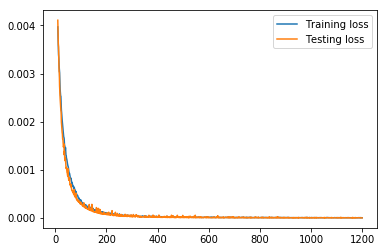

In [348]:
# Now let's train the initial network 

model = lineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

n_epochs = 1200

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)

        # make the ground truth
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
        
#     scheduler.step()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.plot(np.arange(10,n_epochs),train_loss_over_time[10:])
plt.plot(np.arange(10,n_epochs),test_loss_over_time[10:])
plt.legend(['Training loss', 'Testing loss'])

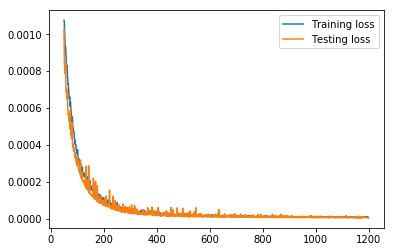

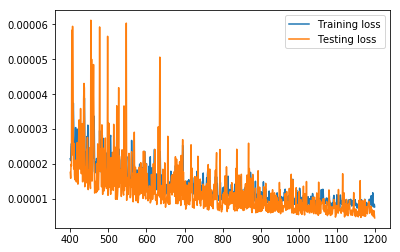

In [349]:
plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

n_start = 400
plt.figure()
plt.plot(np.arange(n_start,n_epochs),train_loss_over_time[n_start:])
plt.plot(np.arange(n_start,n_epochs),test_loss_over_time[n_start:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.1324)]


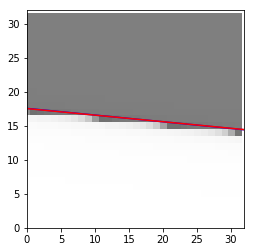

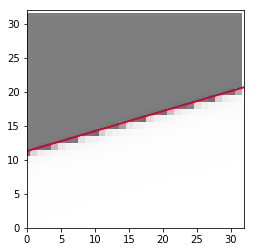

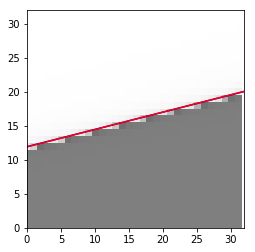

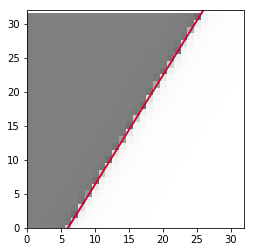

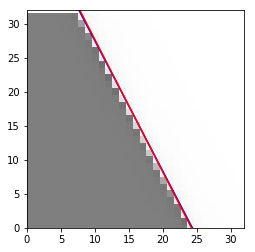

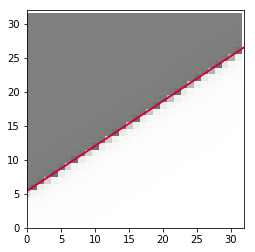

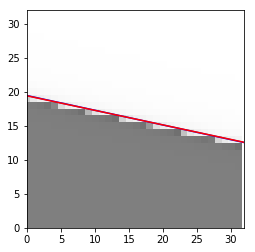

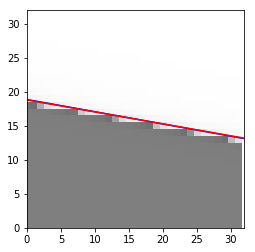

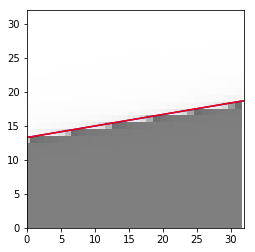

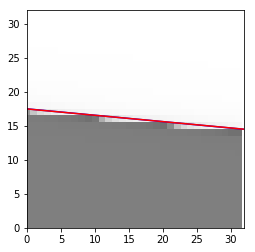

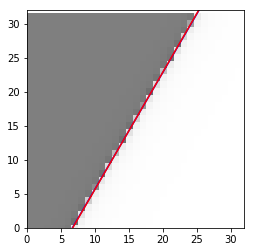

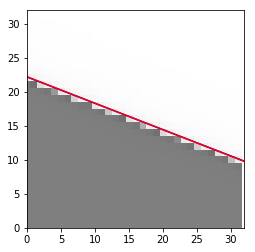

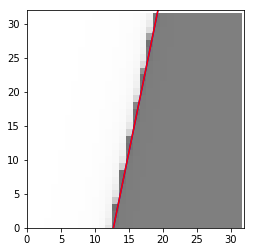

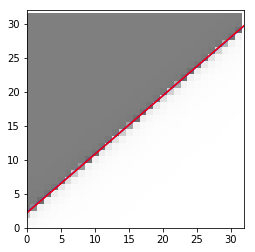

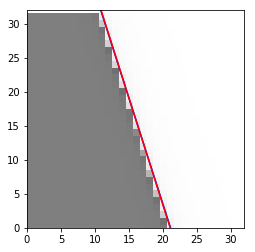

In [350]:
# Plot the Results

W,H = 32,32

model.eval();

ang_loss_all = []# torch.tensor([],device=dev)

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
    
    # Calculate angular loss
    
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)
    
print(ang_loss_all)
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')


Total convolution layers: 1
conv_layers
torch.Size([1, 1, 30, 30])
(30, 30)


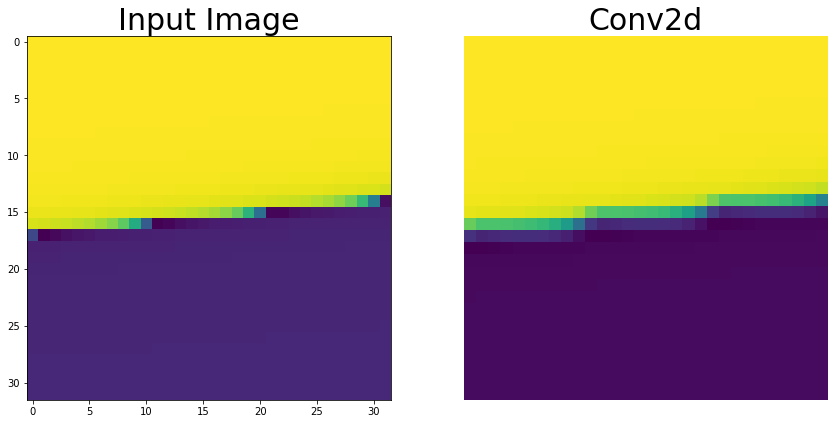

In [351]:
# Visualize the convolution layer

# Let's visualize the output of each layer

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")


outputs = []
names = []

image = inputs[0].unsqueeze(0).to(dev)

for layer in conv_layers[0:]:
    
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)
    
fig = plt.figure(figsize=(30, 50))
a = fig.add_subplot(5, 4, 1)
imgplot = plt.imshow(inputs[0].squeeze().cpu())
a.set_title('Input Image', fontsize=30)
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+2)
    imgplot = plt.imshow(processed[i].squeeze())
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [247]:
# TO DO: Visualize convolution filter
plt.figure()
plt.imshow(layer.squeeze().cpu().detach())

NameError: name 'layer' is not defined

<Figure size 432x288 with 0 Axes>

# Centers move within 25% of center, noiseless — 88 parameters

In [248]:
# What about if the centers are allowed to move within 25% of the center?

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_1000_grey_bicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [250]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)



1000


In [251]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 30, 30]              10
         MaxPool2d-2            [-1, 1, 15, 15]               0
         AvgPool2d-3              [-1, 1, 5, 5]               0
            Linear-4                    [-1, 3]              78
Total params: 88
Trainable params: 88
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 1.4075117420267176, Avg. Test Loss: 0.9227265119552612
Epoch: 2, Avg. Train Loss: 0.9065563104770802, Avg. Test Loss: 0.8955362439155579
Epoch: 3, Avg. Train Loss: 0.8937771298267223, Avg. Test Loss: 0.8829604983329773
Epoch: 4, Avg. Train Loss: 0.8768497727535389, Avg. Test Loss: 0.8683193922042847
Epoch: 5, Avg. Train Loss: 0.8623618284861246, Avg. Test Loss: 0.8508033752441406
Epoch: 6, Avg. Train Loss: 0.8447613473291751, Avg. Test Loss: 0.8311977982521057
Epoch: 7, Avg. Train Loss: 0.8288719433325308, Avg. Test Loss: 0.8105577230453491
Epoch: 8, Avg. Train Loss: 0.8103552239912527, Avg. Test Loss: 0.7880374789237976
Epoch: 9, Avg. Train Loss: 0.784330513742235, Avg. Test Loss: 0.7670024633407593
Epoch: 10, Avg. Train Loss: 0.766272019456934, Avg. Test Loss: 0.7454656958580017
Epoch: 11, Avg. Train Loss: 0.748311910364363, Avg. Test Loss: 0.724890947341919
Epoch: 12, Avg. Train Loss: 0.7326212194230821, Avg. Test Loss: 0.7054309248924255
Epoch: 13, Avg. T

Epoch: 100, Avg. Train Loss: 0.38313942761332903, Avg. Test Loss: 0.37734946608543396
Epoch: 101, Avg. Train Loss: 0.4130117677979999, Avg. Test Loss: 0.3601963520050049
Epoch: 102, Avg. Train Loss: 0.3864209039343728, Avg. Test Loss: 0.32431066036224365
Epoch: 103, Avg. Train Loss: 0.3499432106812795, Avg. Test Loss: 0.2822570502758026
Epoch: 104, Avg. Train Loss: 0.3027987011052944, Avg. Test Loss: 0.23805195093154907
Epoch: 105, Avg. Train Loss: 0.3248240644181216, Avg. Test Loss: 0.4733807444572449
Epoch: 106, Avg. Train Loss: 0.5172581076622009, Avg. Test Loss: 0.48676183819770813
Epoch: 107, Avg. Train Loss: 0.4973686083599373, Avg. Test Loss: 0.45504921674728394
Epoch: 108, Avg. Train Loss: 0.46631236871083576, Avg. Test Loss: 0.4181057810783386
Epoch: 109, Avg. Train Loss: 0.4300614187011012, Avg. Test Loss: 0.3784532845020294
Epoch: 110, Avg. Train Loss: 0.3898452145081979, Avg. Test Loss: 0.3346923887729645
Epoch: 111, Avg. Train Loss: 0.34922166058310755, Avg. Test Loss: 0.2

Epoch: 199, Avg. Train Loss: 0.06739501820670234, Avg. Test Loss: 0.05896669626235962
Epoch: 200, Avg. Train Loss: 0.065189386545508, Avg. Test Loss: 0.05705339461565018
Epoch: 201, Avg. Train Loss: 0.06395648309478054, Avg. Test Loss: 0.05552125722169876
Epoch: 202, Avg. Train Loss: 0.062444738353844044, Avg. Test Loss: 0.053783223032951355
Epoch: 203, Avg. Train Loss: 0.05982062993226228, Avg. Test Loss: 0.052161477506160736
Epoch: 204, Avg. Train Loss: 0.05814070599498572, Avg. Test Loss: 0.05077456682920456
Epoch: 205, Avg. Train Loss: 0.05658839063511954, Avg. Test Loss: 0.04949430376291275
Epoch: 206, Avg. Train Loss: 0.05538179076932095, Avg. Test Loss: 0.04797312989830971
Epoch: 207, Avg. Train Loss: 0.053748426889931714, Avg. Test Loss: 0.04691818356513977
Epoch: 208, Avg. Train Loss: 0.052566203392214246, Avg. Test Loss: 0.04580279812216759
Epoch: 209, Avg. Train Loss: 0.051042573595488513, Avg. Test Loss: 0.0445130430161953
Epoch: 210, Avg. Train Loss: 0.04977440558097981, A

Epoch: 295, Avg. Train Loss: 0.012625183116782594, Avg. Test Loss: 0.011426316574215889
Epoch: 296, Avg. Train Loss: 0.012557682408778756, Avg. Test Loss: 0.011244036257266998
Epoch: 297, Avg. Train Loss: 0.012422838282805902, Avg. Test Loss: 0.011142754927277565
Epoch: 298, Avg. Train Loss: 0.012243880062467523, Avg. Test Loss: 0.011024920269846916
Epoch: 299, Avg. Train Loss: 0.0120661577589258, Avg. Test Loss: 0.01089496724307537
Epoch: 300, Avg. Train Loss: 0.011900463986589952, Avg. Test Loss: 0.010761729441583157
Epoch: 301, Avg. Train Loss: 0.011872547782129712, Avg. Test Loss: 0.010641778819262981
Epoch: 302, Avg. Train Loss: 0.011854804707346138, Avg. Test Loss: 0.010541483759880066
Epoch: 303, Avg. Train Loss: 0.011629053977904496, Avg. Test Loss: 0.010454406961798668
Epoch: 304, Avg. Train Loss: 0.01150414992675737, Avg. Test Loss: 0.010265396907925606
Epoch: 305, Avg. Train Loss: 0.011351017177932791, Avg. Test Loss: 0.010160595178604126
Epoch: 306, Avg. Train Loss: 0.01124

Epoch: 391, Avg. Train Loss: 0.0041798346037803975, Avg. Test Loss: 0.00396660016849637
Epoch: 392, Avg. Train Loss: 0.004109820256147672, Avg. Test Loss: 0.003911642823368311
Epoch: 393, Avg. Train Loss: 0.0040803830380792975, Avg. Test Loss: 0.0038990280590951443
Epoch: 394, Avg. Train Loss: 0.0039963276401438095, Avg. Test Loss: 0.003838019911199808
Epoch: 395, Avg. Train Loss: 0.003943052841350436, Avg. Test Loss: 0.003774438053369522
Epoch: 396, Avg. Train Loss: 0.003879220285280435, Avg. Test Loss: 0.0037302516866475344
Epoch: 397, Avg. Train Loss: 0.0038440576926977547, Avg. Test Loss: 0.0037138748448342085
Epoch: 398, Avg. Train Loss: 0.0038218714072610492, Avg. Test Loss: 0.003627837635576725
Epoch: 399, Avg. Train Loss: 0.003741893675868158, Avg. Test Loss: 0.0036276078317314386
Epoch: 400, Avg. Train Loss: 0.0037061976769042237, Avg. Test Loss: 0.00354468054138124
Epoch: 401, Avg. Train Loss: 0.0036365801589218556, Avg. Test Loss: 0.0035152144264429808
Epoch: 402, Avg. Train

Epoch: 484, Avg. Train Loss: 0.0011352230471351908, Avg. Test Loss: 0.0012090823147445917
Epoch: 485, Avg. Train Loss: 0.0011293318928909247, Avg. Test Loss: 0.0011943913996219635
Epoch: 486, Avg. Train Loss: 0.001103737130674913, Avg. Test Loss: 0.0011938570532947779
Epoch: 487, Avg. Train Loss: 0.0010991322342306376, Avg. Test Loss: 0.0011782976798713207
Epoch: 488, Avg. Train Loss: 0.001070973551745906, Avg. Test Loss: 0.001140100765042007
Epoch: 489, Avg. Train Loss: 0.0010530180815193388, Avg. Test Loss: 0.0011189564829692245
Epoch: 490, Avg. Train Loss: 0.0010321337958211425, Avg. Test Loss: 0.00117145711556077
Epoch: 491, Avg. Train Loss: 0.0010288690337566314, Avg. Test Loss: 0.0010956390760838985
Epoch: 492, Avg. Train Loss: 0.0010133515137972103, Avg. Test Loss: 0.0011035369243472815
Epoch: 493, Avg. Train Loss: 0.0009997310332471021, Avg. Test Loss: 0.0010577976936474442
Epoch: 494, Avg. Train Loss: 0.0010130297547827165, Avg. Test Loss: 0.0010413825511932373
Epoch: 495, Avg

Epoch: 577, Avg. Train Loss: 0.00027819715722688233, Avg. Test Loss: 0.00035329730599187315
Epoch: 578, Avg. Train Loss: 0.0002629629711413549, Avg. Test Loss: 0.0003284801496192813
Epoch: 579, Avg. Train Loss: 0.0002702940352416287, Avg. Test Loss: 0.0003407457552384585
Epoch: 580, Avg. Train Loss: 0.0002586330994273777, Avg. Test Loss: 0.00031780858989804983
Epoch: 581, Avg. Train Loss: 0.00024857998262935627, Avg. Test Loss: 0.00030193873681128025
Epoch: 582, Avg. Train Loss: 0.00025506172527524606, Avg. Test Loss: 0.00030702713411301374
Epoch: 583, Avg. Train Loss: 0.00024534224508830383, Avg. Test Loss: 0.00029767348314635456
Epoch: 584, Avg. Train Loss: 0.0002461078666210933, Avg. Test Loss: 0.0002846896240953356
Epoch: 585, Avg. Train Loss: 0.0002528981669995658, Avg. Test Loss: 0.0003407998301554471
Epoch: 586, Avg. Train Loss: 0.0002428228175698745, Avg. Test Loss: 0.00030795071506872773
Epoch: 587, Avg. Train Loss: 0.00023686525215722482, Avg. Test Loss: 0.0002803165989462286

Epoch: 667, Avg. Train Loss: 0.00010144356902283444, Avg. Test Loss: 0.00014672796532977372
Epoch: 668, Avg. Train Loss: 0.0001235148024365858, Avg. Test Loss: 0.00015096436254680157
Epoch: 669, Avg. Train Loss: 0.00011755711764433525, Avg. Test Loss: 0.00013924743689130992
Epoch: 670, Avg. Train Loss: 0.00010782449896430114, Avg. Test Loss: 0.00011972568609053269
Epoch: 671, Avg. Train Loss: 0.00010349988574657969, Avg. Test Loss: 0.00012645845708902925
Epoch: 672, Avg. Train Loss: 0.00010051215967568742, Avg. Test Loss: 0.00013660494005307555
Epoch: 673, Avg. Train Loss: 9.922122855506907e-05, Avg. Test Loss: 0.00011648731742752716
Epoch: 674, Avg. Train Loss: 9.672261620397438e-05, Avg. Test Loss: 0.00011888510925928131
Epoch: 675, Avg. Train Loss: 0.00010960133470318935, Avg. Test Loss: 0.00013842849875800312
Epoch: 676, Avg. Train Loss: 9.874882447615232e-05, Avg. Test Loss: 0.00012529143714345992
Epoch: 677, Avg. Train Loss: 9.470841312711989e-05, Avg. Test Loss: 0.00011534416262

Epoch: 760, Avg. Train Loss: 5.690669233984038e-05, Avg. Test Loss: 8.28175398055464e-05
Epoch: 761, Avg. Train Loss: 6.002211126475164e-05, Avg. Test Loss: 8.842883835313842e-05
Epoch: 762, Avg. Train Loss: 6.581959745812196e-05, Avg. Test Loss: 7.001651829341426e-05
Epoch: 763, Avg. Train Loss: 6.577649360729588e-05, Avg. Test Loss: 7.324168109335005e-05
Epoch: 764, Avg. Train Loss: 6.184952723776439e-05, Avg. Test Loss: 7.47152662370354e-05
Epoch: 765, Avg. Train Loss: 6.495116529684444e-05, Avg. Test Loss: 8.044287824304774e-05
Epoch: 766, Avg. Train Loss: 6.89670596329961e-05, Avg. Test Loss: 7.084600656526163e-05
Epoch: 767, Avg. Train Loss: 7.083124479255207e-05, Avg. Test Loss: 6.388629117282107e-05
Epoch: 768, Avg. Train Loss: 5.8222339080034374e-05, Avg. Test Loss: 7.935935718705878e-05
Epoch: 769, Avg. Train Loss: 6.159557179435742e-05, Avg. Test Loss: 6.536189903272316e-05
Epoch: 770, Avg. Train Loss: 6.54842868378317e-05, Avg. Test Loss: 7.895448652561754e-05
Epoch: 771, A

Epoch: 853, Avg. Train Loss: 4.019225303232411e-05, Avg. Test Loss: 4.731105582322925e-05
Epoch: 854, Avg. Train Loss: 5.024171049525547e-05, Avg. Test Loss: 5.732039426220581e-05
Epoch: 855, Avg. Train Loss: 4.122282061197674e-05, Avg. Test Loss: 4.9446367484051734e-05
Epoch: 856, Avg. Train Loss: 4.61552498799628e-05, Avg. Test Loss: 5.624878031085245e-05
Epoch: 857, Avg. Train Loss: 4.502011176588928e-05, Avg. Test Loss: 4.9228470743400976e-05
Epoch: 858, Avg. Train Loss: 4.882143689933905e-05, Avg. Test Loss: 4.551826714305207e-05
Epoch: 859, Avg. Train Loss: 4.5048478636157665e-05, Avg. Test Loss: 5.621140371658839e-05
Epoch: 860, Avg. Train Loss: 4.4165636171345354e-05, Avg. Test Loss: 5.143509406480007e-05
Epoch: 861, Avg. Train Loss: 4.545063078425031e-05, Avg. Test Loss: 5.9017122111981735e-05
Epoch: 862, Avg. Train Loss: 4.196898340456688e-05, Avg. Test Loss: 5.5702083045616746e-05
Epoch: 863, Avg. Train Loss: 4.218120382035893e-05, Avg. Test Loss: 5.716221858165227e-05
Epoch

Epoch: 946, Avg. Train Loss: 4.029081059410668e-05, Avg. Test Loss: 3.949461461161263e-05
Epoch: 947, Avg. Train Loss: 3.397766327166378e-05, Avg. Test Loss: 4.119153891224414e-05
Epoch: 948, Avg. Train Loss: 3.630890906033865e-05, Avg. Test Loss: 4.4808803068008274e-05
Epoch: 949, Avg. Train Loss: 3.912765081353158e-05, Avg. Test Loss: 8.104118751361966e-05
Epoch: 950, Avg. Train Loss: 4.5844594987337824e-05, Avg. Test Loss: 4.1063354728976265e-05
Epoch: 951, Avg. Train Loss: 4.4033801950044345e-05, Avg. Test Loss: 4.42591481260024e-05
Epoch: 952, Avg. Train Loss: 3.586009087383799e-05, Avg. Test Loss: 3.831048888969235e-05
Epoch: 953, Avg. Train Loss: 3.37170123303723e-05, Avg. Test Loss: 4.027438262710348e-05
Epoch: 954, Avg. Train Loss: 3.66441453041733e-05, Avg. Test Loss: 4.746676131617278e-05
Epoch: 955, Avg. Train Loss: 4.381078893116123e-05, Avg. Test Loss: 5.318708281265572e-05
Epoch: 956, Avg. Train Loss: 3.989744059422433e-05, Avg. Test Loss: 3.6838675441686064e-05
Epoch: 9

Epoch: 1039, Avg. Train Loss: 4.0824485377352515e-05, Avg. Test Loss: 3.817580727627501e-05
Epoch: 1040, Avg. Train Loss: 3.041826857952401e-05, Avg. Test Loss: 3.311548789497465e-05
Epoch: 1041, Avg. Train Loss: 3.0784981862342206e-05, Avg. Test Loss: 3.696335625136271e-05
Epoch: 1042, Avg. Train Loss: 3.085692312904737e-05, Avg. Test Loss: 4.243857983965427e-05
Epoch: 1043, Avg. Train Loss: 3.0492492644245634e-05, Avg. Test Loss: 3.733891571755521e-05
Epoch: 1044, Avg. Train Loss: 3.362250350215213e-05, Avg. Test Loss: 4.044421439175494e-05
Epoch: 1045, Avg. Train Loss: 3.328370015272716e-05, Avg. Test Loss: 3.989313336205669e-05
Epoch: 1046, Avg. Train Loss: 3.0881010119359145e-05, Avg. Test Loss: 4.3798761907964945e-05
Epoch: 1047, Avg. Train Loss: 3.145487850512533e-05, Avg. Test Loss: 4.233849540469237e-05
Epoch: 1048, Avg. Train Loss: 2.9831214609051433e-05, Avg. Test Loss: 3.4757951652863994e-05
Epoch: 1049, Avg. Train Loss: 3.321430631331168e-05, Avg. Test Loss: 4.335209087003

Epoch: 1129, Avg. Train Loss: 3.6179875476389294e-05, Avg. Test Loss: 3.3865795558085665e-05
Epoch: 1130, Avg. Train Loss: 3.417953067347063e-05, Avg. Test Loss: 4.581052780849859e-05
Epoch: 1131, Avg. Train Loss: 3.139038226099392e-05, Avg. Test Loss: 4.491927393246442e-05
Epoch: 1132, Avg. Train Loss: 3.282708402602347e-05, Avg. Test Loss: 3.765578003367409e-05
Epoch: 1133, Avg. Train Loss: 3.229167850804515e-05, Avg. Test Loss: 3.245292464271188e-05
Epoch: 1134, Avg. Train Loss: 3.041375711526834e-05, Avg. Test Loss: 3.1670177122578025e-05
Epoch: 1135, Avg. Train Loss: 3.6660196605630015e-05, Avg. Test Loss: 3.6473760701483116e-05
Epoch: 1136, Avg. Train Loss: 3.496389089613566e-05, Avg. Test Loss: 6.232069426914677e-05
Epoch: 1137, Avg. Train Loss: 3.8426719685149794e-05, Avg. Test Loss: 4.5213619159767404e-05
Epoch: 1138, Avg. Train Loss: 2.651578937797307e-05, Avg. Test Loss: 3.303711855551228e-05
Epoch: 1139, Avg. Train Loss: 2.777017201609582e-05, Avg. Test Loss: 3.245524203521

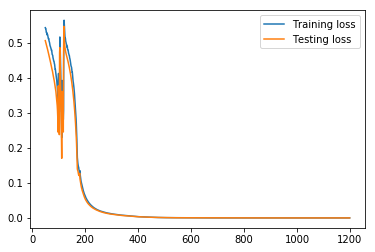

In [252]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1200

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

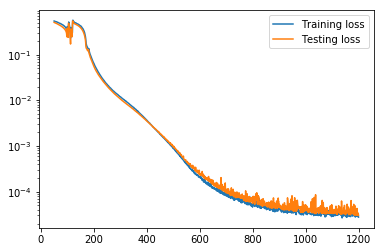

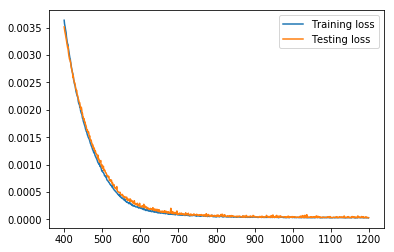

In [254]:
plt.figure()
plt.semilogy(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.semilogy(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

n_start = 400
plt.figure()
plt.plot(np.arange(n_start,n_epochs),train_loss_over_time[n_start:])
plt.plot(np.arange(n_start,n_epochs),test_loss_over_time[n_start:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.2005)]


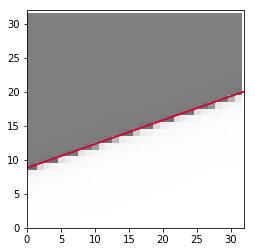

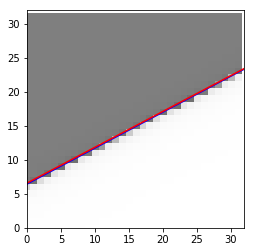

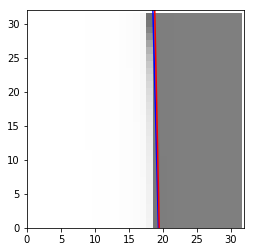

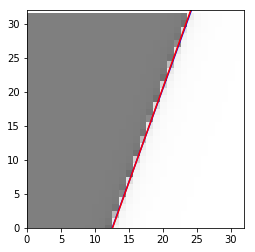

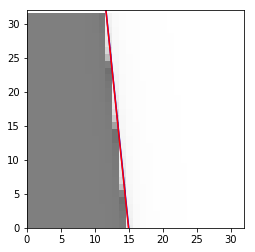

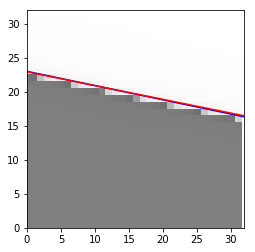

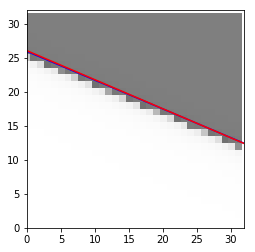

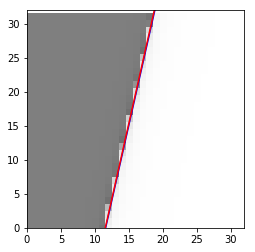

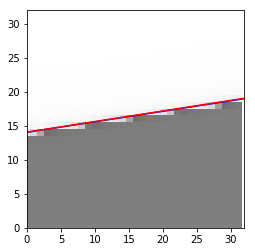

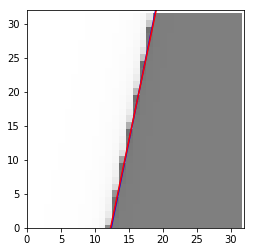

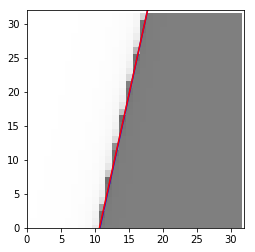

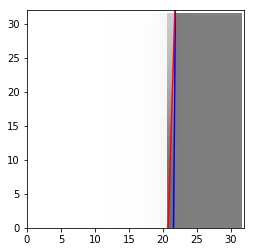

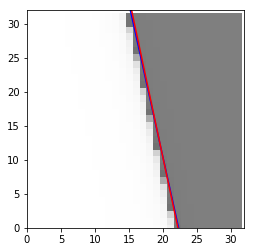

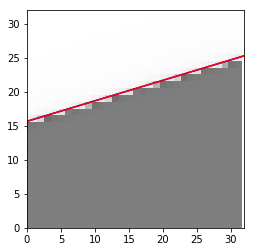

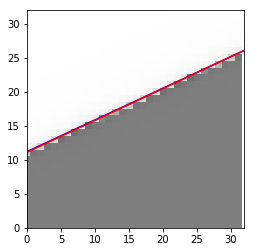

In [253]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')





Total convolution layers: 1
conv_layers
torch.Size([1, 1, 30, 30])
(30, 30)


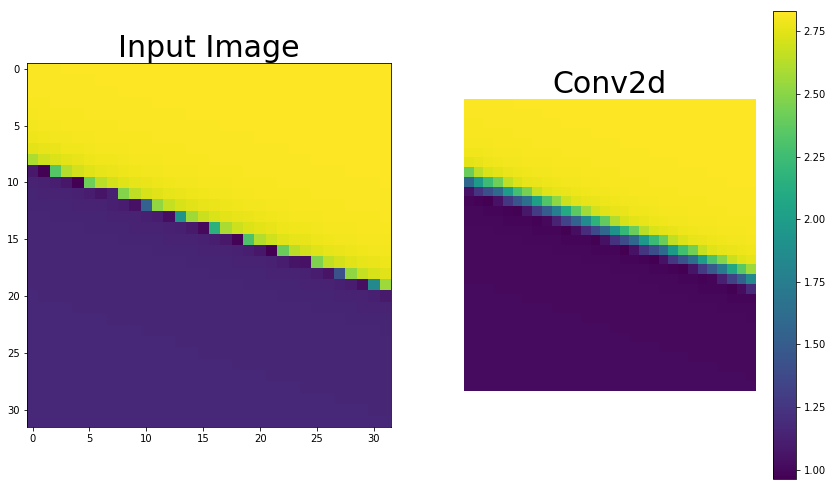

In [255]:
# Visualize the convolution layer

# Let's visualize the output of each layer

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")


outputs = []
names = []

image = inputs[0].unsqueeze(0).to(dev)

for layer in conv_layers[0:]:
    
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)
    
fig = plt.figure(figsize=(30, 50))
a = fig.add_subplot(5, 4, 1)
imgplot = plt.imshow(inputs[0].squeeze().cpu())
a.set_title('Input Image', fontsize=30)
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+2)
    imgplot = plt.imshow(processed[i].squeeze())
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
    plt.colorbar()
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
# Issue: low angular loss is not necessarily a "good" estimate
# So even if we don't need many parameters to get the angle pretty good, the displacement is still not perfect


# If lines are within 75% of center:

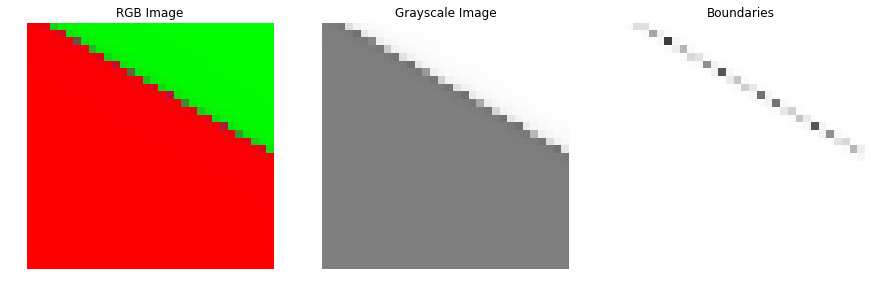

In [519]:

# What about if the centers are allowed to move within 25% of the center?

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_1000_grey_bicolor_uncentered_.75.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [520]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)




1000


Epoch: 1, Avg. Train Loss: 0.6478544208738539, Avg. Test Loss: 0.6121978163719177
Epoch: 2, Avg. Train Loss: 0.520594068147518, Avg. Test Loss: 0.45168477296829224
Epoch: 3, Avg. Train Loss: 0.3586101543020319, Avg. Test Loss: 0.2722594738006592
Epoch: 4, Avg. Train Loss: 0.21551392475763956, Avg. Test Loss: 0.16118882596492767
Epoch: 5, Avg. Train Loss: 0.13799484984742272, Avg. Test Loss: 0.11223743110895157
Epoch: 6, Avg. Train Loss: 0.09869535984816374, Avg. Test Loss: 0.08423794060945511
Epoch: 7, Avg. Train Loss: 0.08092515598292704, Avg. Test Loss: 0.06940910220146179
Epoch: 8, Avg. Train Loss: 0.06587741427399495, Avg. Test Loss: 0.06092436984181404
Epoch: 9, Avg. Train Loss: 0.05874462039382369, Avg. Test Loss: 0.05793936923146248
Epoch: 10, Avg. Train Loss: 0.05393087284432517, Avg. Test Loss: 0.05199151113629341
Epoch: 11, Avg. Train Loss: 0.049128616573633974, Avg. Test Loss: 0.04657115787267685
Epoch: 12, Avg. Train Loss: 0.04446455084339336, Avg. Test Loss: 0.042405020445

Epoch: 97, Avg. Train Loss: 0.007539088872295839, Avg. Test Loss: 0.007568812929093838
Epoch: 98, Avg. Train Loss: 0.007539582938921673, Avg. Test Loss: 0.007486347109079361
Epoch: 99, Avg. Train Loss: 0.007441211215875767, Avg. Test Loss: 0.007465855684131384
Epoch: 100, Avg. Train Loss: 0.007397956697753182, Avg. Test Loss: 0.007391679100692272
Epoch: 101, Avg. Train Loss: 0.007589509417475374, Avg. Test Loss: 0.007775411941111088
Epoch: 102, Avg. Train Loss: 0.0074607206301556695, Avg. Test Loss: 0.007404073607176542
Epoch: 103, Avg. Train Loss: 0.007246656179497087, Avg. Test Loss: 0.007407203316688538
Epoch: 104, Avg. Train Loss: 0.0072504139281119465, Avg. Test Loss: 0.007235803175717592
Epoch: 105, Avg. Train Loss: 0.007356035540363303, Avg. Test Loss: 0.007328661158680916
Epoch: 106, Avg. Train Loss: 0.007175735646375903, Avg. Test Loss: 0.007275777403265238
Epoch: 107, Avg. Train Loss: 0.007105476343659339, Avg. Test Loss: 0.0070561920292675495
Epoch: 108, Avg. Train Loss: 0.0

Epoch: 190, Avg. Train Loss: 0.005701372900080902, Avg. Test Loss: 0.005856113508343697
Epoch: 191, Avg. Train Loss: 0.005693396113605963, Avg. Test Loss: 0.0058936383575201035
Epoch: 192, Avg. Train Loss: 0.005738891661167145, Avg. Test Loss: 0.0058968220837414265
Epoch: 193, Avg. Train Loss: 0.005761001940333733, Avg. Test Loss: 0.005770829040557146
Epoch: 194, Avg. Train Loss: 0.00574721420114791, Avg. Test Loss: 0.005796806886792183
Epoch: 195, Avg. Train Loss: 0.005646707464216484, Avg. Test Loss: 0.005725651979446411
Epoch: 196, Avg. Train Loss: 0.005711595846891955, Avg. Test Loss: 0.005740165710449219
Epoch: 197, Avg. Train Loss: 0.005832321562424854, Avg. Test Loss: 0.005763682071119547
Epoch: 198, Avg. Train Loss: 0.005603074225493603, Avg. Test Loss: 0.005698781460523605
Epoch: 199, Avg. Train Loss: 0.00586794454742361, Avg. Test Loss: 0.005709964781999588
Epoch: 200, Avg. Train Loss: 0.005682387816098829, Avg. Test Loss: 0.005728508345782757
Epoch: 201, Avg. Train Loss: 0.0

Epoch: 286, Avg. Train Loss: 0.005505874321830494, Avg. Test Loss: 0.005592190194875002
Epoch: 287, Avg. Train Loss: 0.005434903695627495, Avg. Test Loss: 0.005537794902920723
Epoch: 288, Avg. Train Loss: 0.005465472953532029, Avg. Test Loss: 0.005585298873484135
Epoch: 289, Avg. Train Loss: 0.0054082689134197105, Avg. Test Loss: 0.005767894443124533
Epoch: 290, Avg. Train Loss: 0.005563773732218478, Avg. Test Loss: 0.006036474369466305
Epoch: 291, Avg. Train Loss: 0.0055088703779296744, Avg. Test Loss: 0.005593242589384317
Epoch: 292, Avg. Train Loss: 0.005436936807301309, Avg. Test Loss: 0.005559224635362625
Epoch: 293, Avg. Train Loss: 0.0054456924295259845, Avg. Test Loss: 0.005597520619630814
Epoch: 294, Avg. Train Loss: 0.00547098940997212, Avg. Test Loss: 0.005556974560022354
Epoch: 295, Avg. Train Loss: 0.005438218315787337, Avg. Test Loss: 0.005544282030314207
Epoch: 296, Avg. Train Loss: 0.005414206465637243, Avg. Test Loss: 0.005531985778361559
Epoch: 297, Avg. Train Loss: 0

Epoch: 380, Avg. Train Loss: 0.005401889120952951, Avg. Test Loss: 0.005510545335710049
Epoch: 381, Avg. Train Loss: 0.005419807913885625, Avg. Test Loss: 0.005510679446160793
Epoch: 382, Avg. Train Loss: 0.00533631672496321, Avg. Test Loss: 0.0055272942408919334
Epoch: 383, Avg. Train Loss: 0.0053861711208743075, Avg. Test Loss: 0.0055041019804775715
Epoch: 384, Avg. Train Loss: 0.005395720859437629, Avg. Test Loss: 0.005498127546161413
Epoch: 385, Avg. Train Loss: 0.005399201461976325, Avg. Test Loss: 0.0055330172181129456
Epoch: 386, Avg. Train Loss: 0.005333965204449164, Avg. Test Loss: 0.00556156923994422
Epoch: 387, Avg. Train Loss: 0.005357743939384818, Avg. Test Loss: 0.005502762738615274
Epoch: 388, Avg. Train Loss: 0.005352774807424457, Avg. Test Loss: 0.005505173932760954
Epoch: 389, Avg. Train Loss: 0.005338810039339242, Avg. Test Loss: 0.0056101856753230095
Epoch: 390, Avg. Train Loss: 0.005364662286377064, Avg. Test Loss: 0.005531227681785822
Epoch: 391, Avg. Train Loss: 

Epoch: 473, Avg. Train Loss: 0.005397269122854427, Avg. Test Loss: 0.005521371029317379
Epoch: 474, Avg. Train Loss: 0.005307624082046526, Avg. Test Loss: 0.005492196884006262
Epoch: 475, Avg. Train Loss: 0.005349600842843453, Avg. Test Loss: 0.005519315600395203
Epoch: 476, Avg. Train Loss: 0.0053400057195513335, Avg. Test Loss: 0.005619274917989969
Epoch: 477, Avg. Train Loss: 0.005415512076406567, Avg. Test Loss: 0.005493797827512026
Epoch: 478, Avg. Train Loss: 0.005332838640444809, Avg. Test Loss: 0.005479683633893728
Epoch: 479, Avg. Train Loss: 0.005371284834971583, Avg. Test Loss: 0.005507234018296003
Epoch: 480, Avg. Train Loss: 0.005347585089987627, Avg. Test Loss: 0.005528865847736597
Epoch: 481, Avg. Train Loss: 0.005311204620671493, Avg. Test Loss: 0.005479034036397934
Epoch: 482, Avg. Train Loss: 0.005406436299111832, Avg. Test Loss: 0.005477424245327711
Epoch: 483, Avg. Train Loss: 0.0054257718966928895, Avg. Test Loss: 0.005691789090633392
Epoch: 484, Avg. Train Loss: 0

Epoch: 569, Avg. Train Loss: 0.005371984120251404, Avg. Test Loss: 0.005577470175921917
Epoch: 570, Avg. Train Loss: 0.005375730080737008, Avg. Test Loss: 0.005563130136579275
Epoch: 571, Avg. Train Loss: 0.005402140681528383, Avg. Test Loss: 0.005472993943840265
Epoch: 572, Avg. Train Loss: 0.005298084092188488, Avg. Test Loss: 0.005476057529449463
Epoch: 573, Avg. Train Loss: 0.005337996529070316, Avg. Test Loss: 0.005481629632413387
Epoch: 574, Avg. Train Loss: 0.005443885853445089, Avg. Test Loss: 0.005546004045754671
Epoch: 575, Avg. Train Loss: 0.005323750441204067, Avg. Test Loss: 0.005474917124956846
Epoch: 576, Avg. Train Loss: 0.005335920809388712, Avg. Test Loss: 0.005495862103998661
Epoch: 577, Avg. Train Loss: 0.005300186333005075, Avg. Test Loss: 0.005500023253262043
Epoch: 578, Avg. Train Loss: 0.005348105302632407, Avg. Test Loss: 0.00548561941832304
Epoch: 579, Avg. Train Loss: 0.005353488795528257, Avg. Test Loss: 0.005473663564771414
Epoch: 580, Avg. Train Loss: 0.00

Epoch: 665, Avg. Train Loss: 0.005378799030074367, Avg. Test Loss: 0.005473786499351263
Epoch: 666, Avg. Train Loss: 0.005285212632130693, Avg. Test Loss: 0.0054720020852983
Epoch: 667, Avg. Train Loss: 0.005326139214621098, Avg. Test Loss: 0.00546340411528945
Epoch: 668, Avg. Train Loss: 0.005291852996581131, Avg. Test Loss: 0.005523979663848877
Epoch: 669, Avg. Train Loss: 0.005308230390289315, Avg. Test Loss: 0.0054572573862969875
Epoch: 670, Avg. Train Loss: 0.005348523509585195, Avg. Test Loss: 0.0054596224799752235
Epoch: 671, Avg. Train Loss: 0.005377407677264677, Avg. Test Loss: 0.005457635503262281
Epoch: 672, Avg. Train Loss: 0.0053033460345533155, Avg. Test Loss: 0.005463670939207077
Epoch: 673, Avg. Train Loss: 0.005342239841680836, Avg. Test Loss: 0.005479220766574144
Epoch: 674, Avg. Train Loss: 0.005385279276028827, Avg. Test Loss: 0.005460373125970364
Epoch: 675, Avg. Train Loss: 0.005279622549467065, Avg. Test Loss: 0.005458388477563858
Epoch: 676, Avg. Train Loss: 0.0

Epoch: 761, Avg. Train Loss: 0.005332788236922136, Avg. Test Loss: 0.005487984046339989
Epoch: 762, Avg. Train Loss: 0.0053896233741263, Avg. Test Loss: 0.005501284264028072
Epoch: 763, Avg. Train Loss: 0.00535300529251496, Avg. Test Loss: 0.0054566990584135056
Epoch: 764, Avg. Train Loss: 0.005272949131688586, Avg. Test Loss: 0.00549116637557745
Epoch: 765, Avg. Train Loss: 0.005248848003921685, Avg. Test Loss: 0.005469189956784248
Epoch: 766, Avg. Train Loss: 0.005313202454191115, Avg. Test Loss: 0.0054877870716154575
Epoch: 767, Avg. Train Loss: 0.005378385686695024, Avg. Test Loss: 0.005460681393742561
Epoch: 768, Avg. Train Loss: 0.0053347435141741124, Avg. Test Loss: 0.0054660639725625515
Epoch: 769, Avg. Train Loss: 0.005287047216875685, Avg. Test Loss: 0.005482462700456381
Epoch: 770, Avg. Train Loss: 0.0053170607080338175, Avg. Test Loss: 0.0054581244476139545
Epoch: 771, Avg. Train Loss: 0.005327064414612121, Avg. Test Loss: 0.005457140505313873
Epoch: 772, Avg. Train Loss: 0

Epoch: 857, Avg. Train Loss: 0.005314787703186825, Avg. Test Loss: 0.005616188049316406
Epoch: 858, Avg. Train Loss: 0.005280545041723935, Avg. Test Loss: 0.0054823411628603935
Epoch: 859, Avg. Train Loss: 0.005276293614534316, Avg. Test Loss: 0.005469999276101589
Epoch: 860, Avg. Train Loss: 0.005277798502464537, Avg. Test Loss: 0.005471471231430769
Epoch: 861, Avg. Train Loss: 0.005297010212584778, Avg. Test Loss: 0.005470049101859331
Epoch: 862, Avg. Train Loss: 0.005314453444616111, Avg. Test Loss: 0.005499505437910557
Epoch: 863, Avg. Train Loss: 0.005317607644462475, Avg. Test Loss: 0.005465210881084204
Epoch: 864, Avg. Train Loss: 0.0053120453376322985, Avg. Test Loss: 0.005495138466358185
Epoch: 865, Avg. Train Loss: 0.005276803789591348, Avg. Test Loss: 0.005466024857014418
Epoch: 866, Avg. Train Loss: 0.005315699752558161, Avg. Test Loss: 0.005508365575224161
Epoch: 867, Avg. Train Loss: 0.005354329348645276, Avg. Test Loss: 0.0054807718843221664
Epoch: 868, Avg. Train Loss: 

Epoch: 953, Avg. Train Loss: 0.0052963848467226385, Avg. Test Loss: 0.005488069262355566
Epoch: 954, Avg. Train Loss: 0.0052402562341066425, Avg. Test Loss: 0.005458303727209568
Epoch: 955, Avg. Train Loss: 0.005305313462115548, Avg. Test Loss: 0.005459122359752655
Epoch: 956, Avg. Train Loss: 0.005276749462441162, Avg. Test Loss: 0.00546678202226758
Epoch: 957, Avg. Train Loss: 0.005272158068018379, Avg. Test Loss: 0.005473815370351076
Epoch: 958, Avg. Train Loss: 0.005363898429398735, Avg. Test Loss: 0.005465436726808548
Epoch: 959, Avg. Train Loss: 0.005333194181461025, Avg. Test Loss: 0.005479794926941395
Epoch: 960, Avg. Train Loss: 0.005327098882170739, Avg. Test Loss: 0.005455928388983011
Epoch: 961, Avg. Train Loss: 0.005313808917654333, Avg. Test Loss: 0.005465702619403601
Epoch: 962, Avg. Train Loss: 0.00529265683144331, Avg. Test Loss: 0.005472519434988499
Epoch: 963, Avg. Train Loss: 0.005360838914014123, Avg. Test Loss: 0.005463300738483667
Epoch: 964, Avg. Train Loss: 0.0

Epoch: 1046, Avg. Train Loss: 0.005353020443753512, Avg. Test Loss: 0.005473446566611528
Epoch: 1047, Avg. Train Loss: 0.00529065188365402, Avg. Test Loss: 0.005496151279658079
Epoch: 1048, Avg. Train Loss: 0.005297076836642291, Avg. Test Loss: 0.005456716753542423
Epoch: 1049, Avg. Train Loss: 0.0053205028503995255, Avg. Test Loss: 0.00549890473484993
Epoch: 1050, Avg. Train Loss: 0.005345124906549851, Avg. Test Loss: 0.00551038421690464
Epoch: 1051, Avg. Train Loss: 0.005322705083354203, Avg. Test Loss: 0.005482801236212254
Epoch: 1052, Avg. Train Loss: 0.0052701205843024785, Avg. Test Loss: 0.005465435795485973
Epoch: 1053, Avg. Train Loss: 0.00526779990091368, Avg. Test Loss: 0.005473420023918152
Epoch: 1054, Avg. Train Loss: 0.005318162583366588, Avg. Test Loss: 0.0054622432217001915
Epoch: 1055, Avg. Train Loss: 0.00535356063671686, Avg. Test Loss: 0.005476297810673714
Epoch: 1056, Avg. Train Loss: 0.005267172758639963, Avg. Test Loss: 0.005456430837512016
Epoch: 1057, Avg. Train

Epoch: 1139, Avg. Train Loss: 0.005331168115070021, Avg. Test Loss: 0.005466760136187077
Epoch: 1140, Avg. Train Loss: 0.0052804871789973095, Avg. Test Loss: 0.0054873148910701275
Epoch: 1141, Avg. Train Loss: 0.005291353505863635, Avg. Test Loss: 0.0055487751960754395
Epoch: 1142, Avg. Train Loss: 0.0052782591449579705, Avg. Test Loss: 0.005495121236890554
Epoch: 1143, Avg. Train Loss: 0.005285750350190533, Avg. Test Loss: 0.00545818405225873
Epoch: 1144, Avg. Train Loss: 0.005285055652536728, Avg. Test Loss: 0.005458537023514509
Epoch: 1145, Avg. Train Loss: 0.005304515473889532, Avg. Test Loss: 0.005457383580505848
Epoch: 1146, Avg. Train Loss: 0.005259465745270804, Avg. Test Loss: 0.0054572345688939095
Epoch: 1147, Avg. Train Loss: 0.005298479727503878, Avg. Test Loss: 0.005457272287458181
Epoch: 1148, Avg. Train Loss: 0.005327194808395924, Avg. Test Loss: 0.005472893361002207
Epoch: 1149, Avg. Train Loss: 0.0052857758667044065, Avg. Test Loss: 0.005468159448355436
Epoch: 1150, Avg

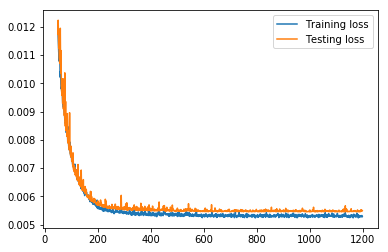

In [521]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1200

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.5244)]


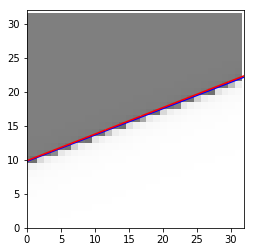

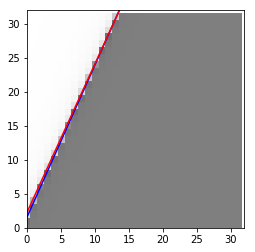

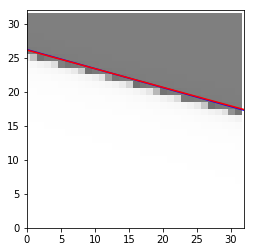

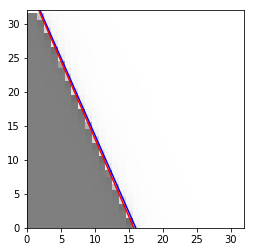

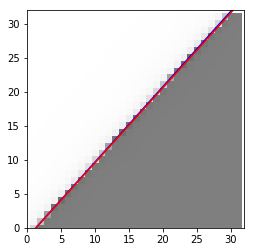

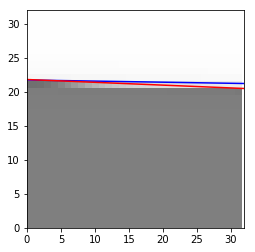

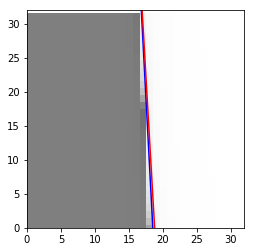

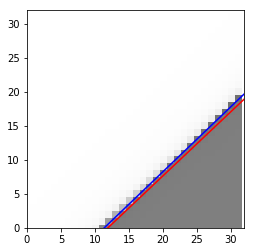

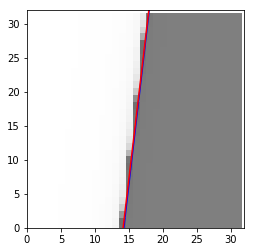

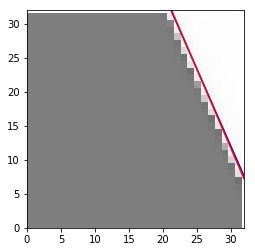

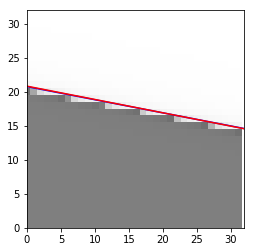

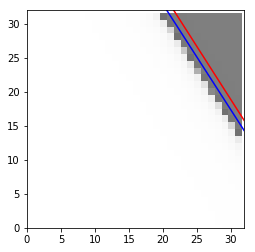

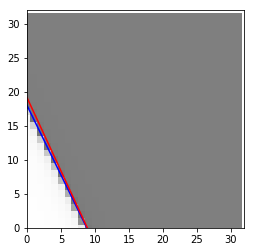

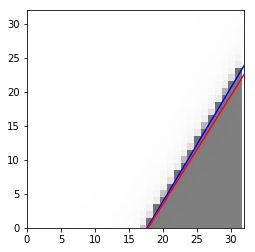

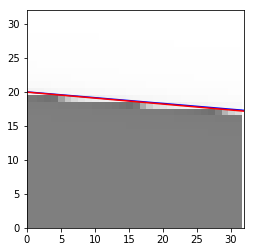

In [522]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')






# Learning Displacements — not helpful

In [355]:
# What about if the centers are allowed to move within 25% of the center?

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_1000_grey_bicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)


1000


In [394]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(4)
        self.avgpool = nn.AvgPool2d(3)
        
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, H, W)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 30, 30]              20
         MaxPool2d-2              [-1, 2, 7, 7]               0
            Linear-3                    [-1, 2]             198
Total params: 218
Trainable params: 218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 1.5127547515763178, Avg. Test Loss: 0.8634342551231384
Epoch: 2, Avg. Train Loss: 0.7769665386941698, Avg. Test Loss: 0.668992280960083
Epoch: 3, Avg. Train Loss: 0.6587831333831504, Avg. Test Loss: 0.595114529132843
Epoch: 4, Avg. Train Loss: 0.597693137548588, Avg. Test Loss: 0.5568606853485107
Epoch: 5, Avg. Train Loss: 0.5690920639921118, Avg. Test Loss: 0.5175893306732178
Epoch: 6, Avg. Train Loss: 0.5314953592088487, Avg. Test Loss: 0.4852372407913208
Epoch: 7, Avg. Train Loss: 0.5168022844526503, Avg. Test Loss: 0.4906407296657562
Epoch: 8, Avg. Train Loss: 0.48961189609986766, Avg. Test Loss: 0.45113861560821533
Epoch: 9, Avg. Train Loss: 0.49577980792080917, Avg. Test Loss: 0.5203506350517273
Epoch: 10, Avg. Train Loss: 0.461458561597047, Avg. Test Loss: 0.41715893149375916
Epoch: 11, Avg. Train Loss: 0.4220944444338481, Avg. Test Loss: 0.3880736231803894
Epoch: 12, Avg. Train Loss: 0.4070330460866292, Avg. Test Loss: 0.4237331449985504
Epoch: 13, Av

Epoch: 101, Avg. Train Loss: 0.25972295414518426, Avg. Test Loss: 0.2679558992385864
Epoch: 102, Avg. Train Loss: 0.25395139113620474, Avg. Test Loss: 0.2668607532978058
Epoch: 103, Avg. Train Loss: 0.25557321696369734, Avg. Test Loss: 0.2395489364862442
Epoch: 104, Avg. Train Loss: 0.25790330326115646, Avg. Test Loss: 0.2405051290988922
Epoch: 105, Avg. Train Loss: 0.25742530546806475, Avg. Test Loss: 0.27069687843322754
Epoch: 106, Avg. Train Loss: 0.252904764480061, Avg. Test Loss: 0.2549354135990143
Epoch: 107, Avg. Train Loss: 0.26367927425437504, Avg. Test Loss: 0.24368588626384735
Epoch: 108, Avg. Train Loss: 0.24651993811130524, Avg. Test Loss: 0.23637519776821136
Epoch: 109, Avg. Train Loss: 0.25108401974042255, Avg. Test Loss: 0.2356295883655548
Epoch: 110, Avg. Train Loss: 0.2581017232603497, Avg. Test Loss: 0.2695307731628418
Epoch: 111, Avg. Train Loss: 0.255249528421296, Avg. Test Loss: 0.23942118883132935
Epoch: 112, Avg. Train Loss: 0.2496954627611019, Avg. Test Loss: 0

Epoch: 200, Avg. Train Loss: 0.2438261933900692, Avg. Test Loss: 0.2406710833311081
Epoch: 201, Avg. Train Loss: 0.23833368497866173, Avg. Test Loss: 0.2355400174856186
Epoch: 202, Avg. Train Loss: 0.2449874276364291, Avg. Test Loss: 0.23320701718330383
Epoch: 203, Avg. Train Loss: 0.23690553340646955, Avg. Test Loss: 0.22730055451393127
Epoch: 204, Avg. Train Loss: 0.2386019417533168, Avg. Test Loss: 0.2413473129272461
Epoch: 205, Avg. Train Loss: 0.23864932468643896, Avg. Test Loss: 0.23669075965881348
Epoch: 206, Avg. Train Loss: 0.24291053028018386, Avg. Test Loss: 0.22728635370731354
Epoch: 207, Avg. Train Loss: 0.23900792278625346, Avg. Test Loss: 0.2358793169260025
Epoch: 208, Avg. Train Loss: 0.23758032145323577, Avg. Test Loss: 0.23803137242794037
Epoch: 209, Avg. Train Loss: 0.2412323714406402, Avg. Test Loss: 0.2518523335456848
Epoch: 210, Avg. Train Loss: 0.24024134156880556, Avg. Test Loss: 0.23193895816802979
Epoch: 211, Avg. Train Loss: 0.23556790749231973, Avg. Test Los

Epoch: 299, Avg. Train Loss: 0.23787821056666197, Avg. Test Loss: 0.24373701214790344
Epoch: 300, Avg. Train Loss: 0.23568016566612102, Avg. Test Loss: 0.22908252477645874
Epoch: 301, Avg. Train Loss: 0.2369642953077952, Avg. Test Loss: 0.23053960502147675
Epoch: 302, Avg. Train Loss: 0.2386827286746767, Avg. Test Loss: 0.2254459112882614
Epoch: 303, Avg. Train Loss: 0.23370026493514026, Avg. Test Loss: 0.22013263404369354
Epoch: 304, Avg. Train Loss: 0.23370416462421417, Avg. Test Loss: 0.235050767660141
Epoch: 305, Avg. Train Loss: 0.23631704460691522, Avg. Test Loss: 0.22573210299015045
Epoch: 306, Avg. Train Loss: 0.2316801404511487, Avg. Test Loss: 0.22984042763710022
Epoch: 307, Avg. Train Loss: 0.23347993912520232, Avg. Test Loss: 0.23609472811222076
Epoch: 308, Avg. Train Loss: 0.23651274762771748, Avg. Test Loss: 0.22292837500572205
Epoch: 309, Avg. Train Loss: 0.22903272757927576, Avg. Test Loss: 0.22980692982673645
Epoch: 310, Avg. Train Loss: 0.23320458994971383, Avg. Test 

Epoch: 395, Avg. Train Loss: 0.2245036807877046, Avg. Test Loss: 0.21654552221298218
Epoch: 396, Avg. Train Loss: 0.22624053723282284, Avg. Test Loss: 0.21863825619220734
Epoch: 397, Avg. Train Loss: 0.22716094774228554, Avg. Test Loss: 0.22522051632404327
Epoch: 398, Avg. Train Loss: 0.22430950237645042, Avg. Test Loss: 0.2218596488237381
Epoch: 399, Avg. Train Loss: 0.22833414541350472, Avg. Test Loss: 0.22042572498321533
Epoch: 400, Avg. Train Loss: 0.22671662602159712, Avg. Test Loss: 0.22289206087589264
Epoch: 401, Avg. Train Loss: 0.22501140556953572, Avg. Test Loss: 0.21806474030017853
Epoch: 402, Avg. Train Loss: 0.22726848831883184, Avg. Test Loss: 0.22817808389663696
Epoch: 403, Avg. Train Loss: 0.22237676271685847, Avg. Test Loss: 0.22071968019008636
Epoch: 404, Avg. Train Loss: 0.22692881966078723, Avg. Test Loss: 0.22378402948379517
Epoch: 405, Avg. Train Loss: 0.22402657237317827, Avg. Test Loss: 0.21891190111637115
Epoch: 406, Avg. Train Loss: 0.22247118309692102, Avg. T

Epoch: 493, Avg. Train Loss: 0.1366237390924383, Avg. Test Loss: 0.14260464906692505
Epoch: 494, Avg. Train Loss: 0.13424291516895648, Avg. Test Loss: 0.14430876076221466
Epoch: 495, Avg. Train Loss: 0.13268162779234074, Avg. Test Loss: 0.14066433906555176
Epoch: 496, Avg. Train Loss: 0.1300802520579762, Avg. Test Loss: 0.13538873195648193
Epoch: 497, Avg. Train Loss: 0.12890802599765636, Avg. Test Loss: 0.1376219391822815
Epoch: 498, Avg. Train Loss: 0.12666353307388448, Avg. Test Loss: 0.13075566291809082
Epoch: 499, Avg. Train Loss: 0.12370909722866835, Avg. Test Loss: 0.13096944987773895
Epoch: 500, Avg. Train Loss: 0.12350607911745708, Avg. Test Loss: 0.13269414007663727
Epoch: 501, Avg. Train Loss: 0.1217470133194217, Avg. Test Loss: 0.12720303237438202
Epoch: 502, Avg. Train Loss: 0.11893261969089508, Avg. Test Loss: 0.12266004085540771
Epoch: 503, Avg. Train Loss: 0.11681076415159085, Avg. Test Loss: 0.11915510147809982
Epoch: 504, Avg. Train Loss: 0.11542197565237682, Avg. Tes

Epoch: 589, Avg. Train Loss: 0.06540131430934977, Avg. Test Loss: 0.06513778865337372
Epoch: 590, Avg. Train Loss: 0.065544618776551, Avg. Test Loss: 0.06524299830198288
Epoch: 591, Avg. Train Loss: 0.06580990221765307, Avg. Test Loss: 0.06652800738811493
Epoch: 592, Avg. Train Loss: 0.06332074174726451, Avg. Test Loss: 0.06429007649421692
Epoch: 593, Avg. Train Loss: 0.06349772270079013, Avg. Test Loss: 0.06446917355060577
Epoch: 594, Avg. Train Loss: 0.06341496151354578, Avg. Test Loss: 0.06520164757966995
Epoch: 595, Avg. Train Loss: 0.06356043175414756, Avg. Test Loss: 0.06459556519985199
Epoch: 596, Avg. Train Loss: 0.06355229254674029, Avg. Test Loss: 0.06490615755319595
Epoch: 597, Avg. Train Loss: 0.062450794572079624, Avg. Test Loss: 0.06447575986385345
Epoch: 598, Avg. Train Loss: 0.061883849264295014, Avg. Test Loss: 0.06418737024068832
Epoch: 599, Avg. Train Loss: 0.062255483534601, Avg. Test Loss: 0.06646697223186493
Epoch: 600, Avg. Train Loss: 0.061935628177943056, Avg. 

Epoch: 685, Avg. Train Loss: 0.055989643213925536, Avg. Test Loss: 0.05908622220158577
Epoch: 686, Avg. Train Loss: 0.055560207615296044, Avg. Test Loss: 0.05869925394654274
Epoch: 687, Avg. Train Loss: 0.05608375549868301, Avg. Test Loss: 0.05869121849536896
Epoch: 688, Avg. Train Loss: 0.056571062102361964, Avg. Test Loss: 0.0608108788728714
Epoch: 689, Avg. Train Loss: 0.05841343201420925, Avg. Test Loss: 0.06126389279961586
Epoch: 690, Avg. Train Loss: 0.05650895254479514, Avg. Test Loss: 0.059637416154146194
Epoch: 691, Avg. Train Loss: 0.05581463183517809, Avg. Test Loss: 0.060291025787591934
Epoch: 692, Avg. Train Loss: 0.0551543903571588, Avg. Test Loss: 0.05800535902380943
Epoch: 693, Avg. Train Loss: 0.05444001309849598, Avg. Test Loss: 0.05816910043358803
Epoch: 694, Avg. Train Loss: 0.054813964637341325, Avg. Test Loss: 0.059588123112916946
Epoch: 695, Avg. Train Loss: 0.05589680980753015, Avg. Test Loss: 0.0581526942551136
Epoch: 696, Avg. Train Loss: 0.056483572004018004,

Epoch: 781, Avg. Train Loss: 0.05367200683664392, Avg. Test Loss: 0.055811844766139984
Epoch: 782, Avg. Train Loss: 0.052837634804072206, Avg. Test Loss: 0.05657106637954712
Epoch: 783, Avg. Train Loss: 0.054348202905169236, Avg. Test Loss: 0.059958696365356445
Epoch: 784, Avg. Train Loss: 0.05345108498025824, Avg. Test Loss: 0.054990533739328384
Epoch: 785, Avg. Train Loss: 0.052404131602357934, Avg. Test Loss: 0.05575108528137207
Epoch: 786, Avg. Train Loss: 0.05553848365390742, Avg. Test Loss: 0.05741254240274429
Epoch: 787, Avg. Train Loss: 0.05499931962953673, Avg. Test Loss: 0.05924580991268158
Epoch: 788, Avg. Train Loss: 0.05332960022820367, Avg. Test Loss: 0.05468302592635155
Epoch: 789, Avg. Train Loss: 0.05297434937070917, Avg. Test Loss: 0.05765242874622345
Epoch: 790, Avg. Train Loss: 0.05413612433605724, Avg. Test Loss: 0.05447457730770111
Epoch: 791, Avg. Train Loss: 0.05313207347083975, Avg. Test Loss: 0.056364577263593674
Epoch: 792, Avg. Train Loss: 0.0527501865117638

Epoch: 877, Avg. Train Loss: 0.05324424968825446, Avg. Test Loss: 0.05536015331745148
Epoch: 878, Avg. Train Loss: 0.055088133447700076, Avg. Test Loss: 0.05584998056292534
Epoch: 879, Avg. Train Loss: 0.051888401723570295, Avg. Test Loss: 0.053536027669906616
Epoch: 880, Avg. Train Loss: 0.05288507237478539, Avg. Test Loss: 0.05441823974251747
Epoch: 881, Avg. Train Loss: 0.05158119883250307, Avg. Test Loss: 0.0532630980014801
Epoch: 882, Avg. Train Loss: 0.05091939066295271, Avg. Test Loss: 0.05290798842906952
Epoch: 883, Avg. Train Loss: 0.05310746351325953, Avg. Test Loss: 0.057788584381341934
Epoch: 884, Avg. Train Loss: 0.053508765443607616, Avg. Test Loss: 0.05543038249015808
Epoch: 885, Avg. Train Loss: 0.05334119774677135, Avg. Test Loss: 0.05386213958263397
Epoch: 886, Avg. Train Loss: 0.05228874142523165, Avg. Test Loss: 0.05273858457803726
Epoch: 887, Avg. Train Loss: 0.051236572916860935, Avg. Test Loss: 0.054619014263153076
Epoch: 888, Avg. Train Loss: 0.05174493182588507

Epoch: 973, Avg. Train Loss: 0.052336143950621285, Avg. Test Loss: 0.05222669988870621
Epoch: 974, Avg. Train Loss: 0.05245725838122545, Avg. Test Loss: 0.05176151916384697
Epoch: 975, Avg. Train Loss: 0.05210436839196417, Avg. Test Loss: 0.05316966399550438
Epoch: 976, Avg. Train Loss: 0.05146251770633238, Avg. Test Loss: 0.0515090748667717
Epoch: 977, Avg. Train Loss: 0.0515525654234268, Avg. Test Loss: 0.05151791870594025
Epoch: 978, Avg. Train Loss: 0.05080776385687016, Avg. Test Loss: 0.05194329097867012
Epoch: 979, Avg. Train Loss: 0.05116714150817306, Avg. Test Loss: 0.052651114761829376
Epoch: 980, Avg. Train Loss: 0.05192871971262826, Avg. Test Loss: 0.05605330318212509
Epoch: 981, Avg. Train Loss: 0.05163404373107133, Avg. Test Loss: 0.05205880478024483
Epoch: 982, Avg. Train Loss: 0.051197024407210176, Avg. Test Loss: 0.05149001255631447
Epoch: 983, Avg. Train Loss: 0.05086087518268161, Avg. Test Loss: 0.05295681208372116
Epoch: 984, Avg. Train Loss: 0.05135570756263203, Avg

Epoch: 1069, Avg. Train Loss: 0.04914855667286449, Avg. Test Loss: 0.05095656216144562
Epoch: 1070, Avg. Train Loss: 0.0502476402454906, Avg. Test Loss: 0.050585415214300156
Epoch: 1071, Avg. Train Loss: 0.05101065144494728, Avg. Test Loss: 0.052386295050382614
Epoch: 1072, Avg. Train Loss: 0.04961043927404615, Avg. Test Loss: 0.049982473254203796
Epoch: 1073, Avg. Train Loss: 0.04983633577271744, Avg. Test Loss: 0.05033792182803154
Epoch: 1074, Avg. Train Loss: 0.04968932436572181, Avg. Test Loss: 0.05070982873439789
Epoch: 1075, Avg. Train Loss: 0.050199041350020304, Avg. Test Loss: 0.051403358578681946
Epoch: 1076, Avg. Train Loss: 0.04899897881680065, Avg. Test Loss: 0.05398968979716301
Epoch: 1077, Avg. Train Loss: 0.051261743875565355, Avg. Test Loss: 0.0517142191529274
Epoch: 1078, Avg. Train Loss: 0.05072123419355463, Avg. Test Loss: 0.05104818940162659
Epoch: 1079, Avg. Train Loss: 0.05043275902668635, Avg. Test Loss: 0.05066119134426117
Epoch: 1080, Avg. Train Loss: 0.0518550

Epoch: 1165, Avg. Train Loss: 0.049661658290359706, Avg. Test Loss: 0.05038432404398918
Epoch: 1166, Avg. Train Loss: 0.048718111106642974, Avg. Test Loss: 0.049724627286195755
Epoch: 1167, Avg. Train Loss: 0.04840849698693664, Avg. Test Loss: 0.05037764459848404
Epoch: 1168, Avg. Train Loss: 0.04996614475493078, Avg. Test Loss: 0.050781093537807465
Epoch: 1169, Avg. Train Loss: 0.0495317111964579, Avg. Test Loss: 0.05024585872888565
Epoch: 1170, Avg. Train Loss: 0.04901320073339674, Avg. Test Loss: 0.05105876177549362
Epoch: 1171, Avg. Train Loss: 0.052301868658374856, Avg. Test Loss: 0.05265062674880028
Epoch: 1172, Avg. Train Loss: 0.04992894290222062, Avg. Test Loss: 0.0508129820227623
Epoch: 1173, Avg. Train Loss: 0.04947860000862016, Avg. Test Loss: 0.05079269036650658
Epoch: 1174, Avg. Train Loss: 0.04924746685557895, Avg. Test Loss: 0.05196763202548027
Epoch: 1175, Avg. Train Loss: 0.04998220931048746, Avg. Test Loss: 0.051186587661504745
Epoch: 1176, Avg. Train Loss: 0.0494721

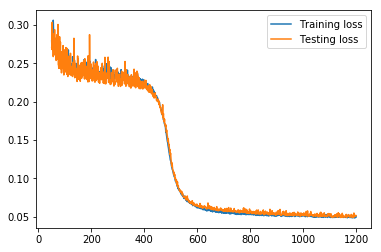

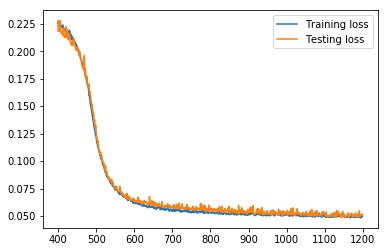

In [400]:
model = displacementNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)

n_epochs = 1200

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

n_start = 400
plt.figure()
plt.plot(np.arange(n_start,n_epochs),train_loss_over_time[n_start:])
plt.plot(np.arange(n_start,n_epochs),test_loss_over_time[n_start:])
plt.legend(['Training loss', 'Testing loss'])

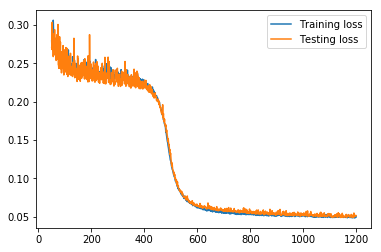

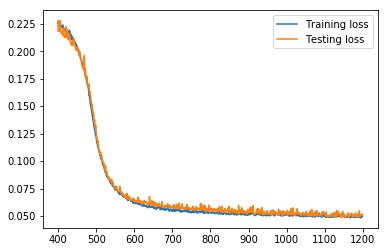

In [401]:
plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

n_start = 400
plt.figure()
plt.plot(np.arange(n_start,n_epochs),train_loss_over_time[n_start:])
plt.plot(np.arange(n_start,n_epochs),test_loss_over_time[n_start:])
plt.legend(['Training loss', 'Testing loss'])

tensor(0.0170)


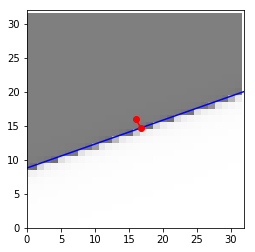

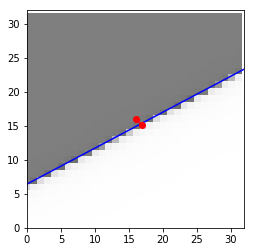

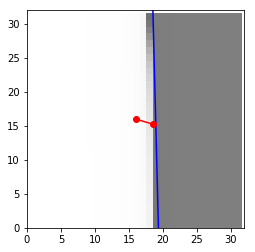

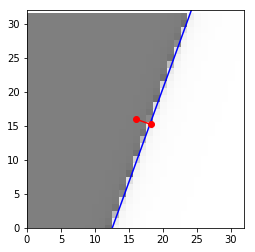

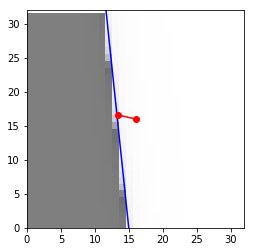

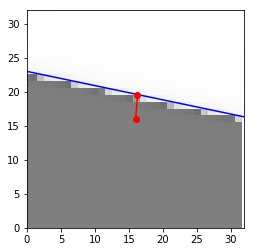

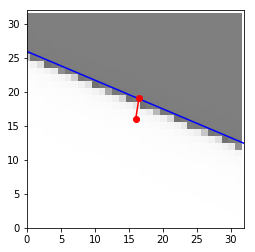

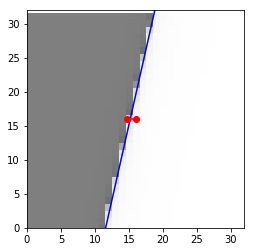

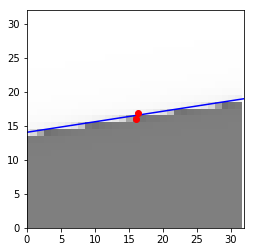

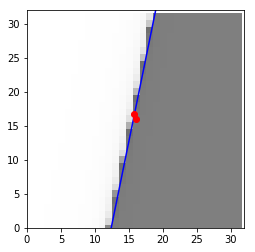

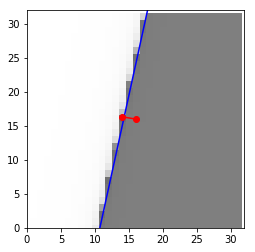

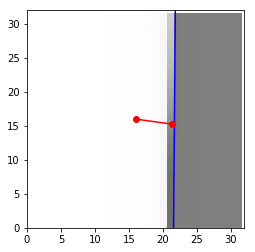

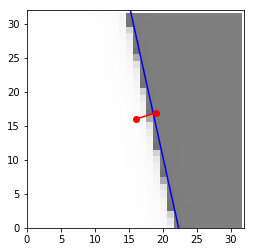

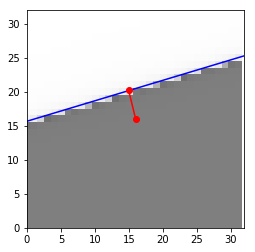

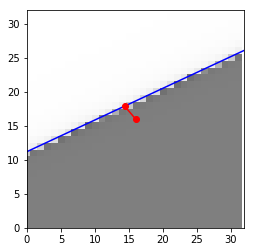

In [402]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
    
    output_displacement = torch.cat((outputs,torch.ones((len(inputs),1))),dim=1) 
    # Calculate the loss for previous metric
    loss = torch.mean(torch.abs(torch.sum(angle_params*output_displacement,1))) 
    
    print(loss)

  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([W/2,W/2]),outputs[ii]*W/2+W/2),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')








# Centered noisy (low noise) images — 62 parameters

In [141]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_bicolor_noise_.01_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32


10000


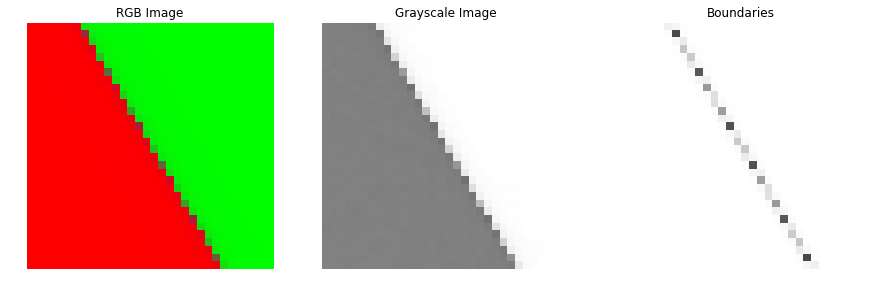

In [108]:
img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

In [144]:
class lineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x,p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = lineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 30, 30]              10
         MaxPool2d-2            [-1, 1, 15, 15]               0
         AvgPool2d-3              [-1, 1, 5, 5]               0
            Linear-4                    [-1, 2]              52
Total params: 62
Trainable params: 62
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.9813307804219863, Avg. Test Loss: 0.8894596099853516
Epoch: 2, Avg. Train Loss: 0.8451914436676923, Avg. Test Loss: 0.7147345542907715
Epoch: 3, Avg. Train Loss: 0.5437404776320738, Avg. Test Loss: 0.40181979537010193
Epoch: 4, Avg. Train Loss: 0.27567776687004986, Avg. Test Loss: 0.20301637053489685
Epoch: 5, Avg. Train Loss: 0.14926530946703517, Avg. Test Loss: 0.1087082251906395
Epoch: 6, Avg. Train Loss: 0.07889419947476949, Avg. Test Loss: 0.05871664732694626
Epoch: 7, Avg. Train Loss: 0.042005433536627716, Avg. Test Loss: 0.03242292255163193
Epoch: 8, Avg. Train Loss: 0.024028862881309846, Avg. Test Loss: 0.019715793430805206
Epoch: 9, Avg. Train Loss: 0.015864227569716817, Avg. Test Loss: 0.014002806507050991
Epoch: 10, Avg. Train Loss: 0.012203044038923347, Avg. Test Loss: 0.011351985856890678
Epoch: 11, Avg. Train Loss: 0.010435717837775456, Avg. Test Loss: 0.009852573275566101
Epoch: 12, Avg. Train Loss: 0.00930947350228534, Avg. Test Loss: 0.0088

Epoch: 95, Avg. Train Loss: 0.0004082675646607052, Avg. Test Loss: 0.0003935142594855279
Epoch: 96, Avg. Train Loss: 0.0004032806147519937, Avg. Test Loss: 0.0003888250794261694
Epoch: 97, Avg. Train Loss: 0.00039898640619974365, Avg. Test Loss: 0.00038532199687324464
Epoch: 98, Avg. Train Loss: 0.00039509835700942753, Avg. Test Loss: 0.0003803006839007139
Epoch: 99, Avg. Train Loss: 0.00039106513620080314, Avg. Test Loss: 0.00037703392445109785
Epoch: 100, Avg. Train Loss: 0.0003874702105189071, Avg. Test Loss: 0.0003733705962076783
Epoch: 101, Avg. Train Loss: 0.00038388022906420865, Avg. Test Loss: 0.0003701703972183168
Epoch: 102, Avg. Train Loss: 0.00038010290625286014, Avg. Test Loss: 0.00036746307159774005
Epoch: 103, Avg. Train Loss: 0.0003768823003423784, Avg. Test Loss: 0.00036771895247511566
Epoch: 104, Avg. Train Loss: 0.00037440586054478497, Avg. Test Loss: 0.0003600137715693563
Epoch: 105, Avg. Train Loss: 0.0003696577007170109, Avg. Test Loss: 0.0003559575416147709
Epoch

Epoch: 186, Avg. Train Loss: 0.00020429166290662526, Avg. Test Loss: 0.00019517044711392373
Epoch: 187, Avg. Train Loss: 0.0002025717865976998, Avg. Test Loss: 0.0001936766057042405
Epoch: 188, Avg. Train Loss: 0.00020176754418678363, Avg. Test Loss: 0.00019285696907900274
Epoch: 189, Avg. Train Loss: 0.0002003920971593984, Avg. Test Loss: 0.00019222352420911193
Epoch: 190, Avg. Train Loss: 0.00019969850151991362, Avg. Test Loss: 0.00019007948867511004
Epoch: 191, Avg. Train Loss: 0.00019734001098721123, Avg. Test Loss: 0.00018846317834686488
Epoch: 192, Avg. Train Loss: 0.0001960839324644493, Avg. Test Loss: 0.00018645156524144113
Epoch: 193, Avg. Train Loss: 0.00019455969381584402, Avg. Test Loss: 0.00018556800205260515
Epoch: 194, Avg. Train Loss: 0.00019311468092971207, Avg. Test Loss: 0.00018548333900980651
Epoch: 195, Avg. Train Loss: 0.00019172414613422006, Avg. Test Loss: 0.00018333844491280615
Epoch: 196, Avg. Train Loss: 0.0001906950500971802, Avg. Test Loss: 0.00018190307309

Epoch: 276, Avg. Train Loss: 0.00010583278002313284, Avg. Test Loss: 0.00010170844325330108
Epoch: 277, Avg. Train Loss: 0.00010491509558906888, Avg. Test Loss: 9.992285049520433e-05
Epoch: 278, Avg. Train Loss: 0.00010489736279637059, Avg. Test Loss: 0.00010005300282500684
Epoch: 279, Avg. Train Loss: 0.00010356554027085247, Avg. Test Loss: 9.963235061150044e-05
Epoch: 280, Avg. Train Loss: 0.00010326054667958113, Avg. Test Loss: 9.783130371943116e-05
Epoch: 281, Avg. Train Loss: 0.00010201282908811289, Avg. Test Loss: 9.751141624292359e-05
Epoch: 282, Avg. Train Loss: 0.00010130083854378695, Avg. Test Loss: 9.635253081796691e-05
Epoch: 283, Avg. Train Loss: 0.00010079327544457662, Avg. Test Loss: 9.671945008449256e-05
Epoch: 284, Avg. Train Loss: 9.968555326957037e-05, Avg. Test Loss: 9.585967927705497e-05
Epoch: 285, Avg. Train Loss: 9.949608519330949e-05, Avg. Test Loss: 9.353760833619162e-05
Epoch: 286, Avg. Train Loss: 9.852380325730123e-05, Avg. Test Loss: 9.422579751117155e-05


Epoch: 367, Avg. Train Loss: 4.839408746406929e-05, Avg. Test Loss: 4.604167042998597e-05
Epoch: 368, Avg. Train Loss: 4.808563308495864e-05, Avg. Test Loss: 4.6209985157474875e-05
Epoch: 369, Avg. Train Loss: 4.77122664639918e-05, Avg. Test Loss: 4.558802902465686e-05
Epoch: 370, Avg. Train Loss: 4.7784607886569574e-05, Avg. Test Loss: 4.527977580437437e-05
Epoch: 371, Avg. Train Loss: 4.717942133806098e-05, Avg. Test Loss: 4.5759348722640425e-05
Epoch: 372, Avg. Train Loss: 4.6582992046537314e-05, Avg. Test Loss: 4.4885407987749204e-05
Epoch: 373, Avg. Train Loss: 4.5886901181588386e-05, Avg. Test Loss: 4.361431274446659e-05
Epoch: 374, Avg. Train Loss: 4.5222294241231046e-05, Avg. Test Loss: 4.3373882363084704e-05
Epoch: 375, Avg. Train Loss: 4.508332002682009e-05, Avg. Test Loss: 4.296720362617634e-05
Epoch: 376, Avg. Train Loss: 4.478101511588594e-05, Avg. Test Loss: 4.369275120552629e-05
Epoch: 377, Avg. Train Loss: 4.458386191639447e-05, Avg. Test Loss: 4.2896601371467113e-05
Ep

Epoch: 458, Avg. Train Loss: 2.1184073856976977e-05, Avg. Test Loss: 2.0011957531096414e-05
Epoch: 459, Avg. Train Loss: 2.1005944397663424e-05, Avg. Test Loss: 1.984838854696136e-05
Epoch: 460, Avg. Train Loss: 2.1341874718714014e-05, Avg. Test Loss: 1.9855408027069643e-05
Epoch: 461, Avg. Train Loss: 2.05910320587196e-05, Avg. Test Loss: 1.9446051737759262e-05
Epoch: 462, Avg. Train Loss: 2.0792227694662014e-05, Avg. Test Loss: 1.9440241885604337e-05
Epoch: 463, Avg. Train Loss: 2.0154327584725036e-05, Avg. Test Loss: 1.9513183360686526e-05
Epoch: 464, Avg. Train Loss: 2.020359448472257e-05, Avg. Test Loss: 2.0534916984615847e-05
Epoch: 465, Avg. Train Loss: 2.019287496616872e-05, Avg. Test Loss: 2.050790499197319e-05
Epoch: 466, Avg. Train Loss: 1.985267815197243e-05, Avg. Test Loss: 1.865284502855502e-05
Epoch: 467, Avg. Train Loss: 1.9571287125205237e-05, Avg. Test Loss: 1.988714939216152e-05
Epoch: 468, Avg. Train Loss: 1.9829077834455186e-05, Avg. Test Loss: 2.02194551093271e-05

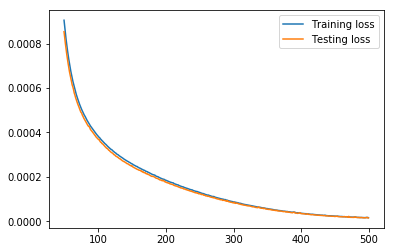

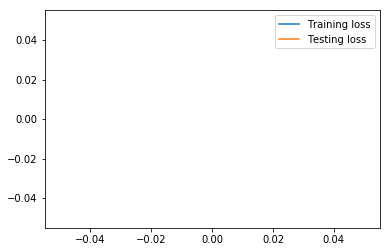

In [145]:
# Now let's train the initial network 

model = lineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

n_epochs = 500

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)

        # make the ground truth
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
        
#     scheduler.step()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

n_start = 600
plt.figure()
plt.plot(np.arange(n_start,n_epochs),train_loss_over_time[n_start:])
plt.plot(np.arange(n_start,n_epochs),test_loss_over_time[n_start:])
plt.legend(['Training loss', 'Testing loss'])



[tensor(0.2371), tensor(0.2266), tensor(0.2369)]


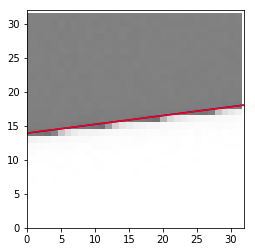

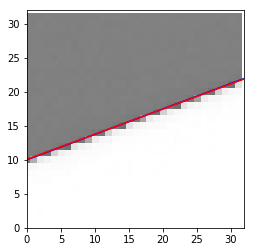

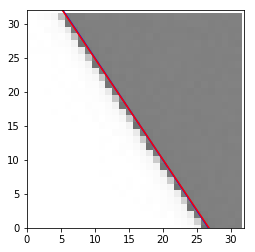

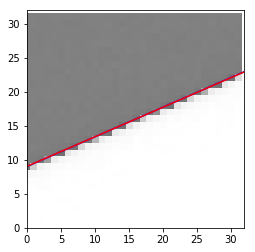

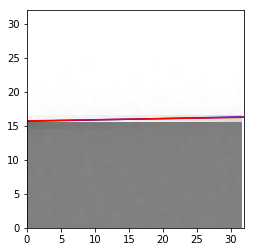

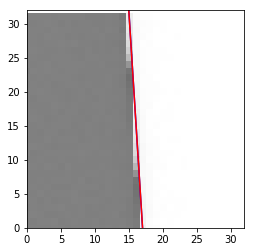

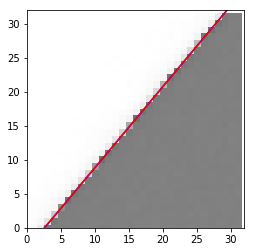

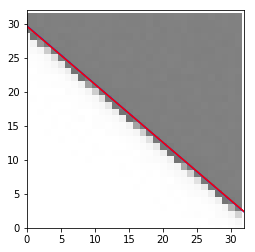

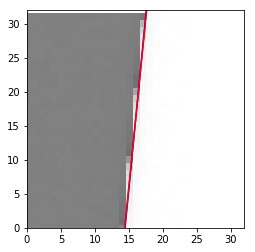

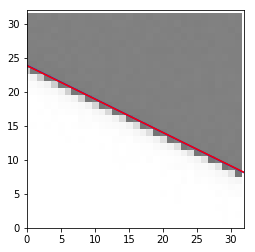

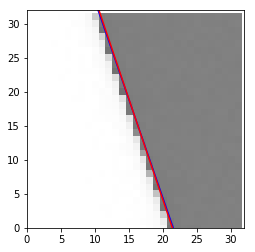

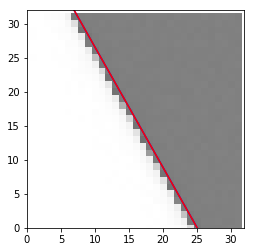

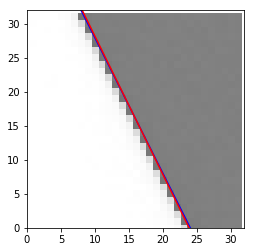

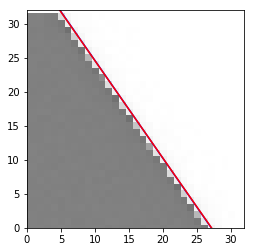

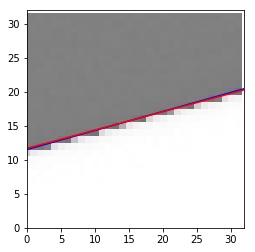

In [146]:
# Plot the Results

W,H = 32,32

# model.eval();
model.train()

ang_loss_all = []# torch.tensor([],device=dev)

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
    
#     print(outputs.shape)
#     print(angle_params[0,:])
#     print('cat')
#     print(outputs[0,:])
    
#     print(mse_loss(outputs,angle_params))
    
#     sys.quit()
    
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))
#     # Calculate angular loss
#     pred_angle = torch.rad2deg(torch.atan2(-outputs[:,0],outputs[:,1]).cpu())
#     pred_angle = (pred_angle + 360) % 360
    
#     ang_loss = torch.mean(torch.abs(pred_angle - torch.rad2deg(gt[:,0])))
    ang_loss_all.append(ang_loss)
    
print(ang_loss_all)
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')






# Increased Noise

10000


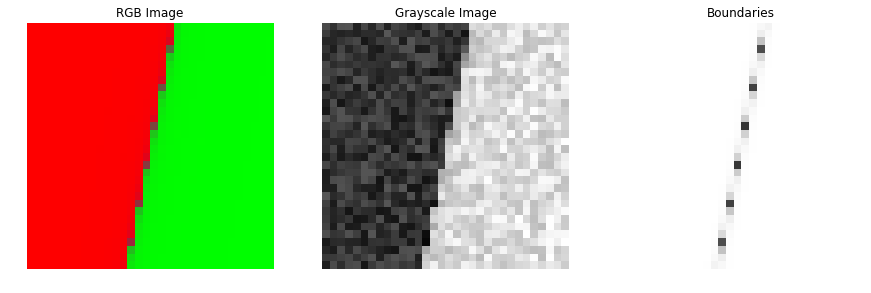

In [6]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_bicolor_noise_.2_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');



Epoch: 1, Avg. Train Loss: 0.9318706708795884, Avg. Test Loss: 0.890204131603241
Epoch: 2, Avg. Train Loss: 0.8159524027039023, Avg. Test Loss: 0.7424397468566895
Epoch: 3, Avg. Train Loss: 0.6040106678710264, Avg. Test Loss: 0.42169588804244995
Epoch: 4, Avg. Train Loss: 0.22728538688491373, Avg. Test Loss: 0.10073789209127426
Epoch: 5, Avg. Train Loss: 0.05357806132558514, Avg. Test Loss: 0.025391340255737305
Epoch: 6, Avg. Train Loss: 0.016319848158780265, Avg. Test Loss: 0.011047756299376488
Epoch: 7, Avg. Train Loss: 0.008922459694611676, Avg. Test Loss: 0.00749572180211544
Epoch: 8, Avg. Train Loss: 0.006510035299202975, Avg. Test Loss: 0.006002641282975674
Epoch: 9, Avg. Train Loss: 0.005390373140792637, Avg. Test Loss: 0.005270087160170078
Epoch: 10, Avg. Train Loss: 0.004837565178818563, Avg. Test Loss: 0.004869725089520216
Epoch: 11, Avg. Train Loss: 0.004512732875916888, Avg. Test Loss: 0.004573265090584755
Epoch: 12, Avg. Train Loss: 0.00427530479946119, Avg. Test Loss: 0.0

Epoch: 95, Avg. Train Loss: 0.0005268489955650533, Avg. Test Loss: 0.0005345999961718917
Epoch: 96, Avg. Train Loss: 0.0005148912348565372, Avg. Test Loss: 0.0005243348423391581
Epoch: 97, Avg. Train Loss: 0.0005055794283501146, Avg. Test Loss: 0.0005120054702274501
Epoch: 98, Avg. Train Loss: 0.0004957296649295398, Avg. Test Loss: 0.0005038177478127182
Epoch: 99, Avg. Train Loss: 0.00048611274756052913, Avg. Test Loss: 0.0004934492753818631
Epoch: 100, Avg. Train Loss: 0.00047658219152842373, Avg. Test Loss: 0.0004838220775127411
Epoch: 101, Avg. Train Loss: 0.000467594269567224, Avg. Test Loss: 0.0004758494906127453
Epoch: 102, Avg. Train Loss: 0.00045894034830031586, Avg. Test Loss: 0.0004652931820601225
Epoch: 103, Avg. Train Loss: 0.0004502109710729736, Avg. Test Loss: 0.00045881952974013984
Epoch: 104, Avg. Train Loss: 0.00044181496452759295, Avg. Test Loss: 0.0004493073502089828
Epoch: 105, Avg. Train Loss: 0.00043366484254982104, Avg. Test Loss: 0.00044259996502660215
Epoch: 10

Epoch: 186, Avg. Train Loss: 0.00016594580751295914, Avg. Test Loss: 0.00017154894885607064
Epoch: 187, Avg. Train Loss: 0.00016520861262346015, Avg. Test Loss: 0.00017026338900905102
Epoch: 188, Avg. Train Loss: 0.00016431460543946528, Avg. Test Loss: 0.00017180643044412136
Epoch: 189, Avg. Train Loss: 0.00016367179427213748, Avg. Test Loss: 0.00016852084081619978
Epoch: 190, Avg. Train Loss: 0.0001623869688688394, Avg. Test Loss: 0.00016738989506848156
Epoch: 191, Avg. Train Loss: 0.00016170051736373673, Avg. Test Loss: 0.00016726806643418968
Epoch: 192, Avg. Train Loss: 0.0001607722173075137, Avg. Test Loss: 0.0001656163076404482
Epoch: 193, Avg. Train Loss: 0.00015990063120090568, Avg. Test Loss: 0.0001646553137106821
Epoch: 194, Avg. Train Loss: 0.00015936489216983318, Avg. Test Loss: 0.00016424688510596752
Epoch: 195, Avg. Train Loss: 0.00015844167330000987, Avg. Test Loss: 0.00016316710389219224
Epoch: 196, Avg. Train Loss: 0.00015752586306702783, Avg. Test Loss: 0.0001623569551

Epoch: 276, Avg. Train Loss: 0.00011815718094380024, Avg. Test Loss: 0.0001200002952828072
Epoch: 277, Avg. Train Loss: 0.00011783023108043434, Avg. Test Loss: 0.00011970134801231325
Epoch: 278, Avg. Train Loss: 0.00011724767639808466, Avg. Test Loss: 0.00011900803656317294
Epoch: 279, Avg. Train Loss: 0.00011718753504443585, Avg. Test Loss: 0.00011876175267389044
Epoch: 280, Avg. Train Loss: 0.00011697346781147644, Avg. Test Loss: 0.00011790430289693177
Epoch: 281, Avg. Train Loss: 0.00011620877750615096, Avg. Test Loss: 0.00011768461263272911
Epoch: 282, Avg. Train Loss: 0.00011575586583657081, Avg. Test Loss: 0.00011736726446542889
Epoch: 283, Avg. Train Loss: 0.00011642167544992203, Avg. Test Loss: 0.00011928693857043982
Epoch: 284, Avg. Train Loss: 0.0001159645796767162, Avg. Test Loss: 0.00011732101847883314
Epoch: 285, Avg. Train Loss: 0.00011590863997459083, Avg. Test Loss: 0.00011631295637926087
Epoch: 286, Avg. Train Loss: 0.00011476700284915483, Avg. Test Loss: 0.00011591501

Epoch: 367, Avg. Train Loss: 8.9922352344729e-05, Avg. Test Loss: 8.932719356380403e-05
Epoch: 368, Avg. Train Loss: 8.973996463122175e-05, Avg. Test Loss: 8.97372592589818e-05
Epoch: 369, Avg. Train Loss: 8.970563238322297e-05, Avg. Test Loss: 8.945161243900657e-05
Epoch: 370, Avg. Train Loss: 8.980538148213836e-05, Avg. Test Loss: 8.913076453609392e-05
Epoch: 371, Avg. Train Loss: 8.930331601090181e-05, Avg. Test Loss: 8.897124644136056e-05
Epoch: 372, Avg. Train Loss: 8.906319228973349e-05, Avg. Test Loss: 8.802823140285909e-05
Epoch: 373, Avg. Train Loss: 8.867422858362689e-05, Avg. Test Loss: 8.748860273044556e-05
Epoch: 374, Avg. Train Loss: 8.830147228710463e-05, Avg. Test Loss: 8.913969213608652e-05
Epoch: 375, Avg. Train Loss: 8.8105456704986e-05, Avg. Test Loss: 8.778567280387506e-05
Epoch: 376, Avg. Train Loss: 8.812996683820315e-05, Avg. Test Loss: 8.730668923817575e-05
Epoch: 377, Avg. Train Loss: 8.796290742740144e-05, Avg. Test Loss: 8.757632167544216e-05
Epoch: 378, Avg

Epoch: 459, Avg. Train Loss: 7.295329637332436e-05, Avg. Test Loss: 7.017092138994485e-05
Epoch: 460, Avg. Train Loss: 7.16233891366488e-05, Avg. Test Loss: 7.041677599772811e-05
Epoch: 461, Avg. Train Loss: 7.217543230474214e-05, Avg. Test Loss: 7.216881931526586e-05
Epoch: 462, Avg. Train Loss: 7.204329278251594e-05, Avg. Test Loss: 7.068753620842472e-05
Epoch: 463, Avg. Train Loss: 7.121315181447084e-05, Avg. Test Loss: 7.035519229248166e-05
Epoch: 464, Avg. Train Loss: 7.142753341159893e-05, Avg. Test Loss: 7.005520456004888e-05
Epoch: 465, Avg. Train Loss: 7.125829399549676e-05, Avg. Test Loss: 6.947839574422687e-05
Epoch: 466, Avg. Train Loss: 7.12615964242586e-05, Avg. Test Loss: 6.971537368372083e-05
Epoch: 467, Avg. Train Loss: 7.183030538726598e-05, Avg. Test Loss: 7.077050395309925e-05
Epoch: 468, Avg. Train Loss: 7.436402366318576e-05, Avg. Test Loss: 7.092401938280091e-05
Epoch: 469, Avg. Train Loss: 7.211090055266944e-05, Avg. Test Loss: 7.145987183321267e-05
Epoch: 470, 

Epoch: 551, Avg. Train Loss: 6.144281124922119e-05, Avg. Test Loss: 6.078194928704761e-05
Epoch: 552, Avg. Train Loss: 6.203372001490446e-05, Avg. Test Loss: 6.076990393921733e-05
Epoch: 553, Avg. Train Loss: 6.312645799720057e-05, Avg. Test Loss: 6.429350469261408e-05
Epoch: 554, Avg. Train Loss: 6.229102548198117e-05, Avg. Test Loss: 6.0656351706711575e-05
Epoch: 555, Avg. Train Loss: 6.240550689707401e-05, Avg. Test Loss: 5.946465171291493e-05
Epoch: 556, Avg. Train Loss: 6.049487573738374e-05, Avg. Test Loss: 5.8733065088745207e-05
Epoch: 557, Avg. Train Loss: 6.132511963882921e-05, Avg. Test Loss: 6.04864108026959e-05
Epoch: 558, Avg. Train Loss: 6.207535197437905e-05, Avg. Test Loss: 5.855891140527092e-05
Epoch: 559, Avg. Train Loss: 6.121856345356825e-05, Avg. Test Loss: 5.982573929941282e-05
Epoch: 560, Avg. Train Loss: 6.10401972046341e-05, Avg. Test Loss: 6.000210851198062e-05
Epoch: 561, Avg. Train Loss: 6.098335121778826e-05, Avg. Test Loss: 5.91878269915469e-05
Epoch: 562,

Epoch: 642, Avg. Train Loss: 5.576389487353428e-05, Avg. Test Loss: 5.422591857495718e-05
Epoch: 643, Avg. Train Loss: 5.5888928995152714e-05, Avg. Test Loss: 5.820123988087289e-05
Epoch: 644, Avg. Train Loss: 5.586243402349817e-05, Avg. Test Loss: 5.388921999838203e-05
Epoch: 645, Avg. Train Loss: 5.513076008783708e-05, Avg. Test Loss: 5.334849629434757e-05
Epoch: 646, Avg. Train Loss: 5.471986150951125e-05, Avg. Test Loss: 5.424523260444403e-05
Epoch: 647, Avg. Train Loss: 5.4511132689453114e-05, Avg. Test Loss: 5.3627602028427646e-05
Epoch: 648, Avg. Train Loss: 5.509367003790377e-05, Avg. Test Loss: 5.609196887235157e-05
Epoch: 649, Avg. Train Loss: 5.467010123538785e-05, Avg. Test Loss: 5.3477968322113156e-05
Epoch: 650, Avg. Train Loss: 5.51367158871418e-05, Avg. Test Loss: 5.338608752936125e-05
Epoch: 651, Avg. Train Loss: 5.5568565157420165e-05, Avg. Test Loss: 5.48145872016903e-05
Epoch: 652, Avg. Train Loss: 5.5641893328249676e-05, Avg. Test Loss: 5.3789444791618735e-05
Epoch

Epoch: 733, Avg. Train Loss: 5.31027078121791e-05, Avg. Test Loss: 5.169644646230154e-05
Epoch: 734, Avg. Train Loss: 5.248415939550956e-05, Avg. Test Loss: 5.0970113079529256e-05
Epoch: 735, Avg. Train Loss: 5.22059340523008e-05, Avg. Test Loss: 5.0850816478487104e-05
Epoch: 736, Avg. Train Loss: 5.1746940538150206e-05, Avg. Test Loss: 5.209656956139952e-05
Epoch: 737, Avg. Train Loss: 5.244332928936381e-05, Avg. Test Loss: 5.0931499572470784e-05
Epoch: 738, Avg. Train Loss: 5.14643855721635e-05, Avg. Test Loss: 5.186696580494754e-05
Epoch: 739, Avg. Train Loss: 5.33845264084555e-05, Avg. Test Loss: 5.5106705985963345e-05
Epoch: 740, Avg. Train Loss: 5.2605203082374134e-05, Avg. Test Loss: 5.1759481721092016e-05
Epoch: 741, Avg. Train Loss: 5.2729989821433695e-05, Avg. Test Loss: 5.404004696174525e-05
Epoch: 742, Avg. Train Loss: 5.337185468627414e-05, Avg. Test Loss: 5.011205212213099e-05
Epoch: 743, Avg. Train Loss: 5.294369240051738e-05, Avg. Test Loss: 5.250591493677348e-05
Epoch:

Epoch: 824, Avg. Train Loss: 4.993197645115502e-05, Avg. Test Loss: 4.902781802229583e-05
Epoch: 825, Avg. Train Loss: 5.110904428019079e-05, Avg. Test Loss: 5.178985884413123e-05
Epoch: 826, Avg. Train Loss: 5.1379518374554155e-05, Avg. Test Loss: 4.9865768232848495e-05
Epoch: 827, Avg. Train Loss: 5.067281873540624e-05, Avg. Test Loss: 4.891367279924452e-05
Epoch: 828, Avg. Train Loss: 5.0507368167232286e-05, Avg. Test Loss: 4.859084583586082e-05
Epoch: 829, Avg. Train Loss: 5.161213887143223e-05, Avg. Test Loss: 5.761668580817059e-05
Epoch: 830, Avg. Train Loss: 5.2180665721500514e-05, Avg. Test Loss: 5.131297075422481e-05
Epoch: 831, Avg. Train Loss: 5.100308707744047e-05, Avg. Test Loss: 4.861587513005361e-05
Epoch: 832, Avg. Train Loss: 5.000942217199789e-05, Avg. Test Loss: 4.824098868994042e-05
Epoch: 833, Avg. Train Loss: 5.0049207108232245e-05, Avg. Test Loss: 5.08437333337497e-05
Epoch: 834, Avg. Train Loss: 5.0287388362716336e-05, Avg. Test Loss: 5.015026545152068e-05
Epoch

Epoch: 915, Avg. Train Loss: 5.023204764310161e-05, Avg. Test Loss: 4.9658596253721043e-05
Epoch: 916, Avg. Train Loss: 4.991745770573342e-05, Avg. Test Loss: 4.877739411313087e-05
Epoch: 917, Avg. Train Loss: 4.98066637031597e-05, Avg. Test Loss: 4.947542765876278e-05
Epoch: 918, Avg. Train Loss: 5.001243120846886e-05, Avg. Test Loss: 4.9638631026027724e-05
Epoch: 919, Avg. Train Loss: 4.944563774830278e-05, Avg. Test Loss: 4.785008422913961e-05
Epoch: 920, Avg. Train Loss: 4.9192261084338976e-05, Avg. Test Loss: 4.7395540605066344e-05
Epoch: 921, Avg. Train Loss: 4.931518582024557e-05, Avg. Test Loss: 4.759929652209394e-05
Epoch: 922, Avg. Train Loss: 4.936033228124656e-05, Avg. Test Loss: 4.7428500693058595e-05
Epoch: 923, Avg. Train Loss: 4.933603186680771e-05, Avg. Test Loss: 4.783486292581074e-05
Epoch: 924, Avg. Train Loss: 4.902047123109429e-05, Avg. Test Loss: 4.7477449697908014e-05
Epoch: 925, Avg. Train Loss: 4.986748386085417e-05, Avg. Test Loss: 4.762427124660462e-05
Epoch

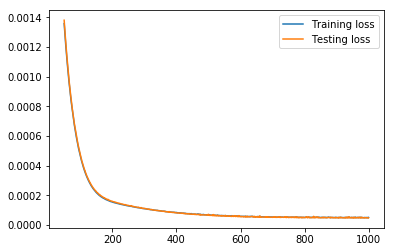

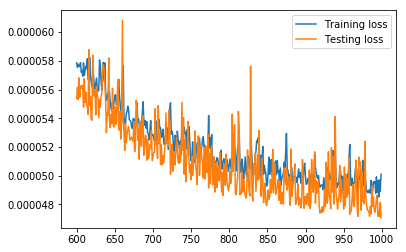

In [157]:
# Now let's train the initial network 

model = lineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

n_epochs = 1000

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)

        # make the ground truth
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
        
#     scheduler.step()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.plot(np.arange(50,n_epochs),train_loss_over_time[50:])
plt.plot(np.arange(50,n_epochs),test_loss_over_time[50:])
plt.legend(['Training loss', 'Testing loss'])

n_start = 600
plt.figure()
plt.plot(np.arange(n_start,n_epochs),train_loss_over_time[n_start:])
plt.plot(np.arange(n_start,n_epochs),test_loss_over_time[n_start:])
plt.legend(['Training loss', 'Testing loss'])




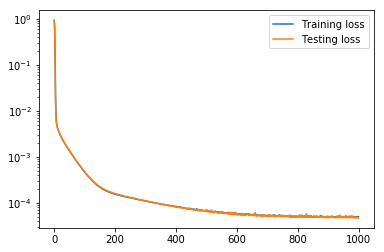

In [158]:
plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.4444), tensor(0.4428), tensor(0.4427)]


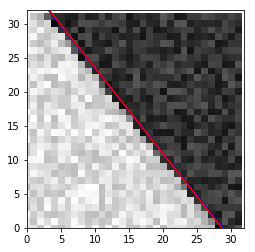

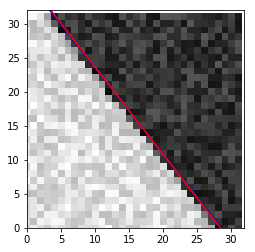

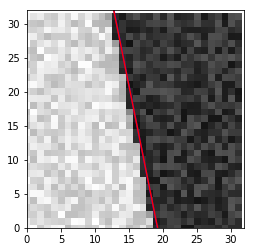

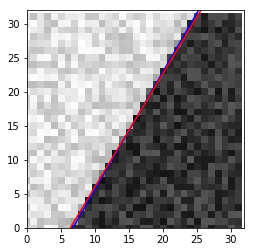

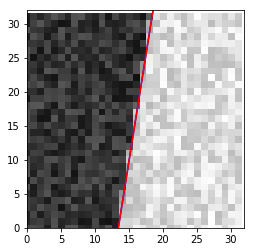

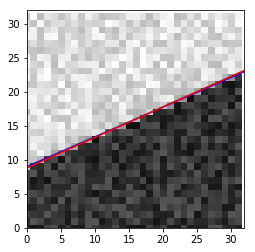

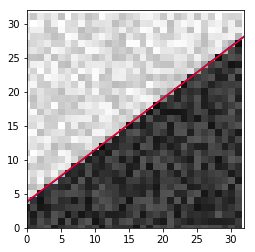

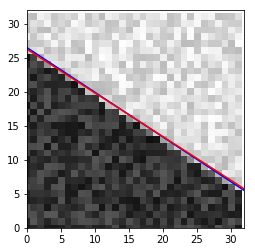

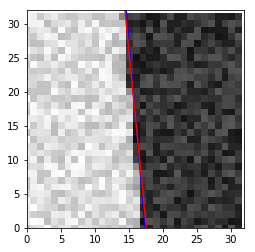

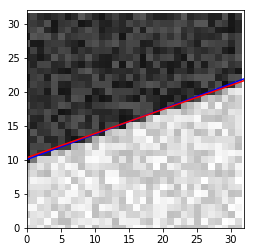

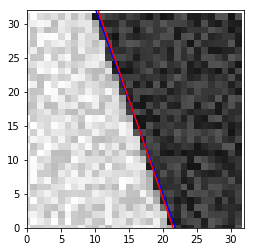

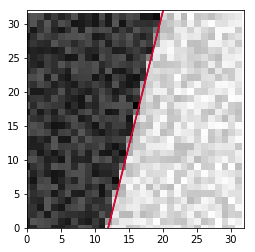

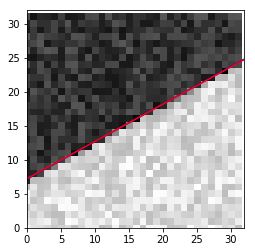

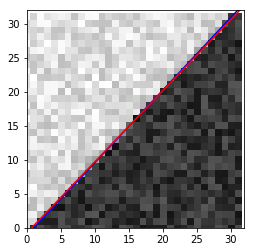

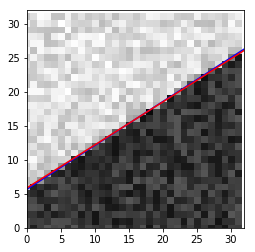

In [159]:
# Plot the Results

W,H = 32,32

# model.eval();
model.train()

ang_loss_all = []# torch.tensor([],device=dev)

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
    
#     print(outputs.shape)
#     print(angle_params[0,:])
#     print('cat')
#     print(outputs[0,:])
    
#     print(mse_loss(outputs,angle_params))
    
#     sys.quit()
    
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))
#     # Calculate angular loss
#     pred_angle = torch.rad2deg(torch.atan2(-outputs[:,0],outputs[:,1]).cpu())
#     pred_angle = (pred_angle + 360) % 360
    
#     ang_loss = torch.mean(torch.abs(pred_angle - torch.rad2deg(gt[:,0])))
    ang_loss_all.append(ang_loss)
    
print(ang_loss_all)
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')







# Amount of noise varies per image — 339 parameters

10000


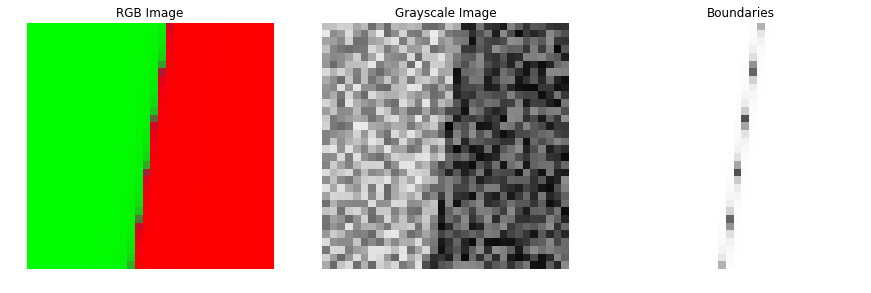

In [7]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_bicolor_noise_random_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');




In [8]:
class lineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
#         self.conv2 = nn.Conv2d(4, 4, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
#         self.batchnorm = nn.BatchNorm2d(16)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
#         x = self.batchnorm(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x,p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = lineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
            Conv2d-2            [-1, 1, 28, 28]             145
         MaxPool2d-3            [-1, 1, 14, 14]               0
         AvgPool2d-4              [-1, 1, 4, 4]               0
            Linear-5                    [-1, 2]              34
Total params: 339
Trainable params: 339
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 1.1832405749489279, Avg. Test Loss: 1.1169052124023438
Epoch: 2, Avg. Train Loss: 1.0804017010857077, Avg. Test Loss: 1.007384181022644
Epoch: 3, Avg. Train Loss: 0.9565300205174614, Avg. Test Loss: 0.8778693079948425
Epoch: 4, Avg. Train Loss: 0.8449041212306303, Avg. Test Loss: 0.7932077646255493
Epoch: 5, Avg. Train Loss: 0.7687520104296067, Avg. Test Loss: 0.7183154821395874
Epoch: 6, Avg. Train Loss: 0.6940926243277157, Avg. Test Loss: 0.6527239680290222
Epoch: 7, Avg. Train Loss: 0.6383651880656972, Avg. Test Loss: 0.6027296781539917
Epoch: 8, Avg. Train Loss: 0.5843425568412332, Avg. Test Loss: 0.5471917986869812
Epoch: 9, Avg. Train Loss: 0.5217745198922998, Avg. Test Loss: 0.47698792815208435
Epoch: 10, Avg. Train Loss: 0.43487201017491955, Avg. Test Loss: 0.3603973388671875
Epoch: 11, Avg. Train Loss: 0.24420174255090601, Avg. Test Loss: 0.14711686968803406
Epoch: 12, Avg. Train Loss: 0.11507610713734347, Avg. Test Loss: 0.09016956388950348
Epoch: 1

Epoch: 95, Avg. Train Loss: 0.000872537397834308, Avg. Test Loss: 0.0008531102794222534
Epoch: 96, Avg. Train Loss: 0.0008673222037032247, Avg. Test Loss: 0.0008507724851369858
Epoch: 97, Avg. Train Loss: 0.0008628580424770274, Avg. Test Loss: 0.0008484844584017992
Epoch: 98, Avg. Train Loss: 0.0008602010236833902, Avg. Test Loss: 0.000845409813337028
Epoch: 99, Avg. Train Loss: 0.0008568655535140459, Avg. Test Loss: 0.0008388360729441047
Epoch: 100, Avg. Train Loss: 0.0008531111114494064, Avg. Test Loss: 0.0008377688354812562
Epoch: 101, Avg. Train Loss: 0.00085010813371114, Avg. Test Loss: 0.0008336801547557116
Epoch: 102, Avg. Train Loss: 0.0008476160891244517, Avg. Test Loss: 0.0008306722156703472
Epoch: 103, Avg. Train Loss: 0.000843961096560473, Avg. Test Loss: 0.0008278677123598754
Epoch: 104, Avg. Train Loss: 0.0008415240924531484, Avg. Test Loss: 0.0008265298674814403
Epoch: 105, Avg. Train Loss: 0.0008381969357073746, Avg. Test Loss: 0.00082330999430269
Epoch: 106, Avg. Train

Epoch: 187, Avg. Train Loss: 0.0006621236611595925, Avg. Test Loss: 0.000648620305582881
Epoch: 188, Avg. Train Loss: 0.0006615998161792316, Avg. Test Loss: 0.0006453946698457003
Epoch: 189, Avg. Train Loss: 0.0006587929845623233, Avg. Test Loss: 0.0006502883043140173
Epoch: 190, Avg. Train Loss: 0.0006562737809658489, Avg. Test Loss: 0.0006425537867471576
Epoch: 191, Avg. Train Loss: 0.0006581162040888824, Avg. Test Loss: 0.0006434500101022422
Epoch: 192, Avg. Train Loss: 0.0006525183596429141, Avg. Test Loss: 0.0006408917251974344
Epoch: 193, Avg. Train Loss: 0.0006527192514006267, Avg. Test Loss: 0.0006363112479448318
Epoch: 194, Avg. Train Loss: 0.0006477918085532592, Avg. Test Loss: 0.0006391998613253236
Epoch: 195, Avg. Train Loss: 0.0006487937986522037, Avg. Test Loss: 0.0006359007675200701
Epoch: 196, Avg. Train Loss: 0.0006475345067241613, Avg. Test Loss: 0.0006298155640251935
Epoch: 197, Avg. Train Loss: 0.0006447751657105982, Avg. Test Loss: 0.0006303376285359263
Epoch: 198,

Epoch: 279, Avg. Train Loss: 0.0005146795900894658, Avg. Test Loss: 0.0005063752178102732
Epoch: 280, Avg. Train Loss: 0.0005139259635196889, Avg. Test Loss: 0.0005081452545709908
Epoch: 281, Avg. Train Loss: 0.0005124251063748755, Avg. Test Loss: 0.0005030143074691296
Epoch: 282, Avg. Train Loss: 0.0005122829427230446, Avg. Test Loss: 0.0005021055112592876
Epoch: 283, Avg. Train Loss: 0.0005063187324113268, Avg. Test Loss: 0.0004994292976334691
Epoch: 284, Avg. Train Loss: 0.0005048137613544788, Avg. Test Loss: 0.0004974083276465535
Epoch: 285, Avg. Train Loss: 0.0005065212077598142, Avg. Test Loss: 0.0004987646825611591
Epoch: 286, Avg. Train Loss: 0.0005067192987018429, Avg. Test Loss: 0.0004939059144817293
Epoch: 287, Avg. Train Loss: 0.0005019478095859728, Avg. Test Loss: 0.0004940564977005124
Epoch: 288, Avg. Train Loss: 0.0004983380769023343, Avg. Test Loss: 0.0004914681776426733
Epoch: 289, Avg. Train Loss: 0.0004987423119874781, Avg. Test Loss: 0.0004899147315882146
Epoch: 290

Epoch: 370, Avg. Train Loss: 0.00040679862585795275, Avg. Test Loss: 0.000416491471696645
Epoch: 371, Avg. Train Loss: 0.0004039215632741723, Avg. Test Loss: 0.0004111224552616477
Epoch: 372, Avg. Train Loss: 0.0004035763781490352, Avg. Test Loss: 0.0004152859910391271
Epoch: 373, Avg. Train Loss: 0.0004016065675600925, Avg. Test Loss: 0.0004106869164388627
Epoch: 374, Avg. Train Loss: 0.00040106889654827467, Avg. Test Loss: 0.00040851483936421573
Epoch: 375, Avg. Train Loss: 0.00040103030144510903, Avg. Test Loss: 0.0004078824713360518
Epoch: 376, Avg. Train Loss: 0.000402454670299502, Avg. Test Loss: 0.00041968876030296087
Epoch: 377, Avg. Train Loss: 0.0004002661581205971, Avg. Test Loss: 0.00040703476406633854
Epoch: 378, Avg. Train Loss: 0.00039910623522968413, Avg. Test Loss: 0.00041061113006435335
Epoch: 379, Avg. Train Loss: 0.000399372644845725, Avg. Test Loss: 0.0004072811861988157
Epoch: 380, Avg. Train Loss: 0.000400542639373966, Avg. Test Loss: 0.00041012553265318274
Epoch

Epoch: 461, Avg. Train Loss: 0.0003383310789050644, Avg. Test Loss: 0.0003482464817352593
Epoch: 462, Avg. Train Loss: 0.00034111744539319156, Avg. Test Loss: 0.00034415116533637047
Epoch: 463, Avg. Train Loss: 0.0003355994396021261, Avg. Test Loss: 0.0003410095814615488
Epoch: 464, Avg. Train Loss: 0.0003360823440529844, Avg. Test Loss: 0.00034199614310637116
Epoch: 465, Avg. Train Loss: 0.00033413062063867557, Avg. Test Loss: 0.0003357527020853013
Epoch: 466, Avg. Train Loss: 0.00033598664209849257, Avg. Test Loss: 0.0003365976444911212
Epoch: 467, Avg. Train Loss: 0.00033355491434443086, Avg. Test Loss: 0.0003367999743204564
Epoch: 468, Avg. Train Loss: 0.0003331781019155374, Avg. Test Loss: 0.00034629262518137693
Epoch: 469, Avg. Train Loss: 0.00033200524836395155, Avg. Test Loss: 0.0003320801188237965
Epoch: 470, Avg. Train Loss: 0.0003312311463934534, Avg. Test Loss: 0.00033152621472254395
Epoch: 471, Avg. Train Loss: 0.0003311633481644094, Avg. Test Loss: 0.0003313953639008105
E

Epoch: 552, Avg. Train Loss: 0.00030183752738487194, Avg. Test Loss: 0.0002977046824526042
Epoch: 553, Avg. Train Loss: 0.00030322244000511575, Avg. Test Loss: 0.00029857608024030924
Epoch: 554, Avg. Train Loss: 0.00030338274047929137, Avg. Test Loss: 0.0002976605901494622
Epoch: 555, Avg. Train Loss: 0.0003021409844650942, Avg. Test Loss: 0.00029805637313984334
Epoch: 556, Avg. Train Loss: 0.0002996198360479492, Avg. Test Loss: 0.0002994477399624884
Epoch: 557, Avg. Train Loss: 0.0003023819761652061, Avg. Test Loss: 0.0002941326529253274
Epoch: 558, Avg. Train Loss: 0.0002996622968245955, Avg. Test Loss: 0.00029439295758493245
Epoch: 559, Avg. Train Loss: 0.00030002723146668254, Avg. Test Loss: 0.00029366742819547653
Epoch: 560, Avg. Train Loss: 0.0002990284205332179, Avg. Test Loss: 0.00029259052826091647
Epoch: 561, Avg. Train Loss: 0.0002981823653338806, Avg. Test Loss: 0.00029716032440774143
Epoch: 562, Avg. Train Loss: 0.00030248591963968733, Avg. Test Loss: 0.0002965164021588862

Epoch: 643, Avg. Train Loss: 0.0002869721433586057, Avg. Test Loss: 0.0002844385744538158
Epoch: 644, Avg. Train Loss: 0.00028822231294778995, Avg. Test Loss: 0.0002853537444025278
Epoch: 645, Avg. Train Loss: 0.00028631906538708685, Avg. Test Loss: 0.0002834303304553032
Epoch: 646, Avg. Train Loss: 0.0002871901319047217, Avg. Test Loss: 0.00028256032965146005
Epoch: 647, Avg. Train Loss: 0.00028611536596573014, Avg. Test Loss: 0.00028301088605076075
Epoch: 648, Avg. Train Loss: 0.00028706100248896023, Avg. Test Loss: 0.00028521294007077813
Epoch: 649, Avg. Train Loss: 0.00029191351581282695, Avg. Test Loss: 0.00029174465453252196
Epoch: 650, Avg. Train Loss: 0.00029020186219200054, Avg. Test Loss: 0.0002893444325309247
Epoch: 651, Avg. Train Loss: 0.00028692313593209665, Avg. Test Loss: 0.0002841664827428758
Epoch: 652, Avg. Train Loss: 0.00028633136261144984, Avg. Test Loss: 0.0002890132600441575
Epoch: 653, Avg. Train Loss: 0.00028693855753825865, Avg. Test Loss: 0.00028381843003444

Epoch: 734, Avg. Train Loss: 0.0002838466924218023, Avg. Test Loss: 0.0002776018809527159
Epoch: 735, Avg. Train Loss: 0.0002816512903390343, Avg. Test Loss: 0.0002851331955753267
Epoch: 736, Avg. Train Loss: 0.0002833388211643871, Avg. Test Loss: 0.00028515286976471543
Epoch: 737, Avg. Train Loss: 0.0002814142661758096, Avg. Test Loss: 0.0002799771027639508
Epoch: 738, Avg. Train Loss: 0.00028022725874667656, Avg. Test Loss: 0.0002741270582191646
Epoch: 739, Avg. Train Loss: 0.00027997522984686145, Avg. Test Loss: 0.0002773596497718245
Epoch: 740, Avg. Train Loss: 0.0002810809083337731, Avg. Test Loss: 0.0002764442178886384
Epoch: 741, Avg. Train Loss: 0.0002804168256903615, Avg. Test Loss: 0.0002751979627646506
Epoch: 742, Avg. Train Loss: 0.0002818117440363173, Avg. Test Loss: 0.00027609040262177587
Epoch: 743, Avg. Train Loss: 0.00027924102922791946, Avg. Test Loss: 0.00027662154752761126
Epoch: 744, Avg. Train Loss: 0.00028010546007221015, Avg. Test Loss: 0.00028679269598796964
Ep

Epoch: 825, Avg. Train Loss: 0.00014499058306682855, Avg. Test Loss: 0.00014665958588011563
Epoch: 826, Avg. Train Loss: 0.00014351857552195296, Avg. Test Loss: 0.0001467656111344695
Epoch: 827, Avg. Train Loss: 0.0001431543907314977, Avg. Test Loss: 0.00014604169700760394
Epoch: 828, Avg. Train Loss: 0.00014420432254315957, Avg. Test Loss: 0.00014639996516052634
Epoch: 829, Avg. Train Loss: 0.00014227176228921642, Avg. Test Loss: 0.00014455450582318008
Epoch: 830, Avg. Train Loss: 0.0001421636505470173, Avg. Test Loss: 0.0001429981493856758
Epoch: 831, Avg. Train Loss: 0.00014131918792640243, Avg. Test Loss: 0.00014267049846239388
Epoch: 832, Avg. Train Loss: 0.00014109803305473179, Avg. Test Loss: 0.00014268570521380752
Epoch: 833, Avg. Train Loss: 0.0001404988279853783, Avg. Test Loss: 0.00014354150334838778
Epoch: 834, Avg. Train Loss: 0.0001395058853257283, Avg. Test Loss: 0.00014050246682018042
Epoch: 835, Avg. Train Loss: 0.00013892176460050156, Avg. Test Loss: 0.000141521508339

Epoch: 915, Avg. Train Loss: 0.0001239748132374028, Avg. Test Loss: 0.00012660246284212917
Epoch: 916, Avg. Train Loss: 0.00012357729942510452, Avg. Test Loss: 0.00012681678344961256
Epoch: 917, Avg. Train Loss: 0.00012452193700215395, Avg. Test Loss: 0.000129456544527784
Epoch: 918, Avg. Train Loss: 0.00012425320464364418, Avg. Test Loss: 0.00013090277207084
Epoch: 919, Avg. Train Loss: 0.00012353056038538103, Avg. Test Loss: 0.00012900374713353813
Epoch: 920, Avg. Train Loss: 0.0001237550994333373, Avg. Test Loss: 0.00012891803635284305
Epoch: 921, Avg. Train Loss: 0.00012366836103062858, Avg. Test Loss: 0.00012829681509174407
Epoch: 922, Avg. Train Loss: 0.00012388769648489817, Avg. Test Loss: 0.0001300184812862426
Epoch: 923, Avg. Train Loss: 0.00012468707984012058, Avg. Test Loss: 0.0001300745498156175
Epoch: 924, Avg. Train Loss: 0.0001265715070664609, Avg. Test Loss: 0.00012704628170467913
Epoch: 925, Avg. Train Loss: 0.0001235005830120131, Avg. Test Loss: 0.0001261478173546493


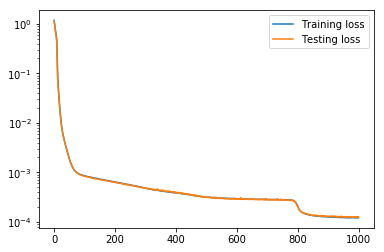

In [9]:
# Now let's train the initial network 

model = lineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

n_epochs = 1000

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)

        # make the ground truth
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
        
#     scheduler.step()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),dim=1)

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time)
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time)
plt.legend(['Training loss', 'Testing loss'])


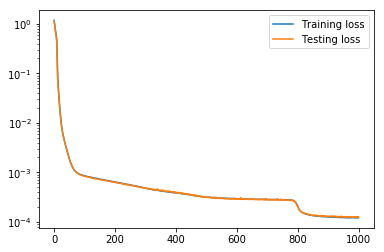

In [10]:

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time)
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time)
plt.legend(['Training loss', 'Testing loss'])




[tensor(0.6734), tensor(0.6867), tensor(0.6667)]


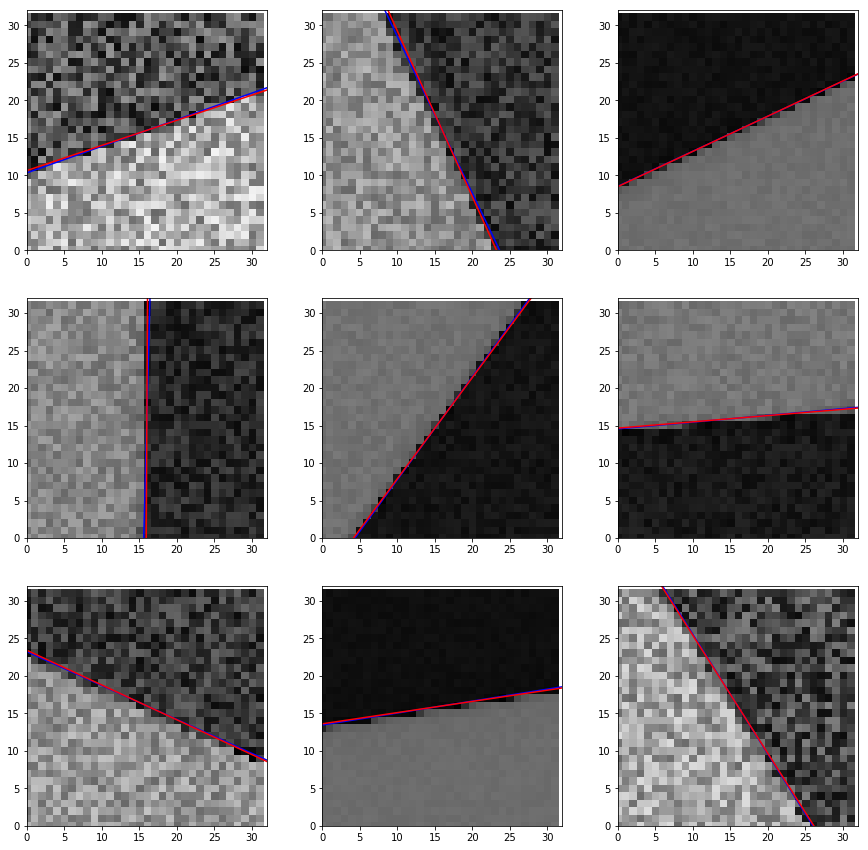

In [11]:
# Plot the Results

W,H = 32,32

# model.eval();
model.train()

ang_loss_all = []# torch.tensor([],device=dev)

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
    
#     print(outputs.shape)
#     print(angle_params[0,:])
#     print('cat')
#     print(outputs[0,:])
    
#     print(mse_loss(outputs,angle_params))
    
#     sys.quit()
    
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))
#     # Calculate angular loss
#     pred_angle = torch.rad2deg(torch.atan2(-outputs[:,0],outputs[:,1]).cpu())
#     pred_angle = (pred_angle + 360) % 360
    
#     ang_loss = torch.mean(torch.abs(pred_angle - torch.rad2deg(gt[:,0])))
    ang_loss_all.append(ang_loss)
    
print(ang_loss_all)
  
plt.figure(figsize=[15, 15])

for ii in range(9):
    
#     print('Values')
#     print(angle_params[ii,:])
#     print(outputs[ii,:])
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




## Test the trained model on images with varying colors

10000


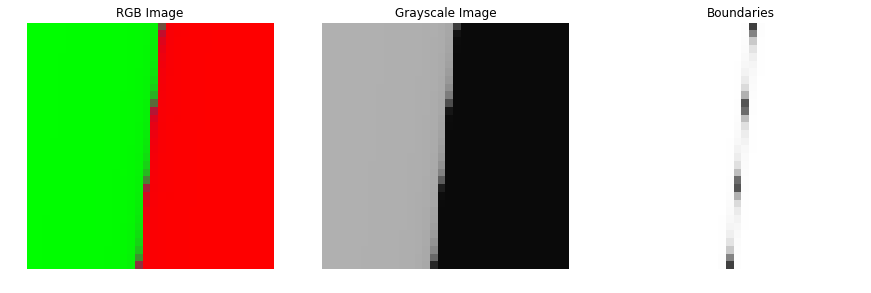

In [12]:
# line_data_32_10000_grey_multicolor_centered.pkl

# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_multicolor_centered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset_TEST, test_dataset_TEST = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader_TEST = torch.utils.data.DataLoader(train_dataset_TEST, batch_size=500, shuffle=True)
test_loader_TEST = torch.utils.data.DataLoader(test_dataset_TEST, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


[tensor(0.5352), tensor(0.5836), tensor(0.5105)]


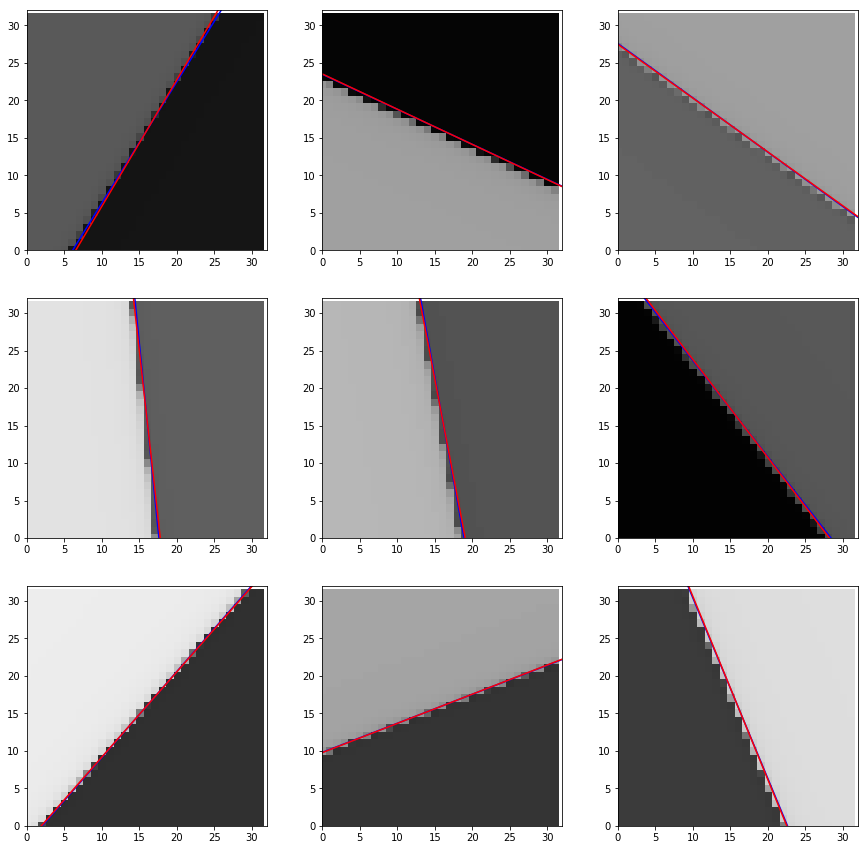

In [13]:
# Plot the Results

W,H = 32,32

# model.eval();

ang_loss_all = []# torch.tensor([],device=dev)

for batch_i, data in enumerate(test_loader_TEST):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0])),axis=1).detach().cpu()
    
#     print(angle_params[0,:])
#     print('cat')
#     print(outputs[0,:])
#     print(mse_loss(outputs,angle_params))
    
#     print(angle_params[2,:])
#     print('cat')
#     print(outputs[2,:])
    
#     sys.quit()
    
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)
    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
#     print('Values')
#     print(angle_params[ii,:])
#     print(outputs[ii,:])
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')



# Off centered noisy images - 356 parameters

20000


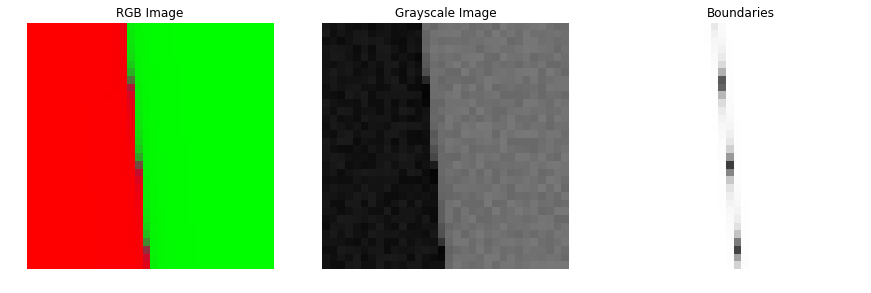

In [14]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_20000_grey_bicolor_noise_random_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');





In [18]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
#         self.conv2 = nn.Conv2d(4, 4, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
#         self.batchnorm = nn.BatchNorm2d(16)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
#         x = self.batchnorm(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
            Conv2d-2            [-1, 1, 28, 28]             145
         MaxPool2d-3            [-1, 1, 14, 14]               0
         AvgPool2d-4              [-1, 1, 4, 4]               0
            Linear-5                    [-1, 3]              51
Total params: 356
Trainable params: 356
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 1.0040591324076933, Avg. Test Loss: 0.8814336657524109
Epoch: 2, Avg. Train Loss: 0.8386765297721414, Avg. Test Loss: 0.8024661540985107
Epoch: 3, Avg. Train Loss: 0.7577159509939306, Avg. Test Loss: 0.7403284311294556
Epoch: 4, Avg. Train Loss: 0.7218202808324028, Avg. Test Loss: 0.7253711223602295
Epoch: 5, Avg. Train Loss: 0.7151920760379118, Avg. Test Loss: 0.7228919267654419
Epoch: 6, Avg. Train Loss: 0.7133445073576534, Avg. Test Loss: 0.7210601568222046
Epoch: 7, Avg. Train Loss: 0.7113967222325942, Avg. Test Loss: 0.7191881537437439
Epoch: 8, Avg. Train Loss: 0.7094746933263891, Avg. Test Loss: 0.7173646688461304
Epoch: 9, Avg. Train Loss: 0.7076047448550954, Avg. Test Loss: 0.7155343890190125
Epoch: 10, Avg. Train Loss: 0.705747621900895, Avg. Test Loss: 0.7137417197227478
Epoch: 11, Avg. Train Loss: 0.6836354276713204, Avg. Test Loss: 0.6671171188354492
Epoch: 12, Avg. Train Loss: 0.6300196542459375, Avg. Test Loss: 0.6079497933387756
Epoch: 13, Avg

Epoch: 98, Avg. Train Loss: 0.013391869635704686, Avg. Test Loss: 0.013283739797770977
Epoch: 99, Avg. Train Loss: 0.01322694621322786, Avg. Test Loss: 0.013118747621774673
Epoch: 100, Avg. Train Loss: 0.01306399012751439, Avg. Test Loss: 0.012955731712281704
Epoch: 101, Avg. Train Loss: 0.01290558563435779, Avg. Test Loss: 0.012800371274352074
Epoch: 102, Avg. Train Loss: 0.012748109341105995, Avg. Test Loss: 0.01264086365699768
Epoch: 103, Avg. Train Loss: 0.012594330343691743, Avg. Test Loss: 0.012486059218645096
Epoch: 104, Avg. Train Loss: 0.012442294782137169, Avg. Test Loss: 0.012334883213043213
Epoch: 105, Avg. Train Loss: 0.01229285673402688, Avg. Test Loss: 0.012187919579446316
Epoch: 106, Avg. Train Loss: 0.012147848877836676, Avg. Test Loss: 0.012040412984788418
Epoch: 107, Avg. Train Loss: 0.01200300214045188, Avg. Test Loss: 0.011897992342710495
Epoch: 108, Avg. Train Loss: 0.011862424257047036, Avg. Test Loss: 0.011757483705878258
Epoch: 109, Avg. Train Loss: 0.011725135

Epoch: 192, Avg. Train Loss: 0.005027869634111138, Avg. Test Loss: 0.004928416572511196
Epoch: 193, Avg. Train Loss: 0.004984089666429688, Avg. Test Loss: 0.004884480498731136
Epoch: 194, Avg. Train Loss: 0.0049409113057395995, Avg. Test Loss: 0.004842745140194893
Epoch: 195, Avg. Train Loss: 0.004899303374045035, Avg. Test Loss: 0.004799273796379566
Epoch: 196, Avg. Train Loss: 0.004855804282295353, Avg. Test Loss: 0.004758438561111689
Epoch: 197, Avg. Train Loss: 0.004815075245192822, Avg. Test Loss: 0.004716070368885994
Epoch: 198, Avg. Train Loss: 0.004773626186172752, Avg. Test Loss: 0.004676631651818752
Epoch: 199, Avg. Train Loss: 0.004731899456066244, Avg. Test Loss: 0.00463610514998436
Epoch: 200, Avg. Train Loss: 0.004689881030250998, Avg. Test Loss: 0.004594293422996998
Epoch: 201, Avg. Train Loss: 0.004650746718706454, Avg. Test Loss: 0.004555294290184975
Epoch: 202, Avg. Train Loss: 0.0046109313090496205, Avg. Test Loss: 0.004516318906098604
Epoch: 203, Avg. Train Loss: 0.

Epoch: 285, Avg. Train Loss: 0.002479576204410371, Avg. Test Loss: 0.002429845044389367
Epoch: 286, Avg. Train Loss: 0.002463292796164751, Avg. Test Loss: 0.0024142046459019184
Epoch: 287, Avg. Train Loss: 0.0024478639174691018, Avg. Test Loss: 0.0023999265395104885
Epoch: 288, Avg. Train Loss: 0.002431914525325684, Avg. Test Loss: 0.0023862288799136877
Epoch: 289, Avg. Train Loss: 0.00241539442418691, Avg. Test Loss: 0.0023674825206398964
Epoch: 290, Avg. Train Loss: 0.002399065928971943, Avg. Test Loss: 0.0023522572591900826
Epoch: 291, Avg. Train Loss: 0.002383172703797326, Avg. Test Loss: 0.002336728386580944
Epoch: 292, Avg. Train Loss: 0.0023679255151792485, Avg. Test Loss: 0.0023215848486870527
Epoch: 293, Avg. Train Loss: 0.0023528584142160766, Avg. Test Loss: 0.002306582173332572
Epoch: 294, Avg. Train Loss: 0.0023373313494684067, Avg. Test Loss: 0.0022935352753847837
Epoch: 295, Avg. Train Loss: 0.0023234142264460817, Avg. Test Loss: 0.00227759825065732
Epoch: 296, Avg. Train

Epoch: 377, Avg. Train Loss: 0.0013925587648854537, Avg. Test Loss: 0.0013825611677020788
Epoch: 378, Avg. Train Loss: 0.0013832606114994954, Avg. Test Loss: 0.001375103136524558
Epoch: 379, Avg. Train Loss: 0.001375113593359642, Avg. Test Loss: 0.0013668433530256152
Epoch: 380, Avg. Train Loss: 0.001366207335034714, Avg. Test Loss: 0.0013579963706433773
Epoch: 381, Avg. Train Loss: 0.001357252079555217, Avg. Test Loss: 0.0013539799256250262
Epoch: 382, Avg. Train Loss: 0.0013495875070528949, Avg. Test Loss: 0.0013426244258880615
Epoch: 383, Avg. Train Loss: 0.0013428073212066118, Avg. Test Loss: 0.001335920300334692
Epoch: 384, Avg. Train Loss: 0.0013328917146496037, Avg. Test Loss: 0.001327337697148323
Epoch: 385, Avg. Train Loss: 0.0013240030418862315, Avg. Test Loss: 0.0013214445207268
Epoch: 386, Avg. Train Loss: 0.00131519215510172, Avg. Test Loss: 0.0013116839108988643
Epoch: 387, Avg. Train Loss: 0.0013075171600041144, Avg. Test Loss: 0.0013037080643698573
Epoch: 388, Avg. Trai

Epoch: 469, Avg. Train Loss: 0.0009087200639495516, Avg. Test Loss: 0.0009355178917758167
Epoch: 470, Avg. Train Loss: 0.0009036557885872968, Avg. Test Loss: 0.000932857976295054
Epoch: 471, Avg. Train Loss: 0.0009016459225676954, Avg. Test Loss: 0.0009283998515456915
Epoch: 472, Avg. Train Loss: 0.000897988334626836, Avg. Test Loss: 0.0009284433908760548
Epoch: 473, Avg. Train Loss: 0.0008954239344936522, Avg. Test Loss: 0.0009238977218046784
Epoch: 474, Avg. Train Loss: 0.0008931672645677976, Avg. Test Loss: 0.0009233409073203802
Epoch: 475, Avg. Train Loss: 0.0008919763118576477, Avg. Test Loss: 0.0009213868761435151
Epoch: 476, Avg. Train Loss: 0.0008879639174077002, Avg. Test Loss: 0.0009178200270980597
Epoch: 477, Avg. Train Loss: 0.0008857177419807104, Avg. Test Loss: 0.0009173334110528231
Epoch: 478, Avg. Train Loss: 0.0008842315668623676, Avg. Test Loss: 0.0009165015071630478
Epoch: 479, Avg. Train Loss: 0.0008809061734663213, Avg. Test Loss: 0.0009128371602855623
Epoch: 480, 

Epoch: 561, Avg. Train Loss: 0.0007391477839144714, Avg. Test Loss: 0.0007696019019931555
Epoch: 562, Avg. Train Loss: 0.000739239392500809, Avg. Test Loss: 0.0007780439918860793
Epoch: 563, Avg. Train Loss: 0.00073726536185645, Avg. Test Loss: 0.0007677343674004078
Epoch: 564, Avg. Train Loss: 0.000733997388605905, Avg. Test Loss: 0.0007640050025656819
Epoch: 565, Avg. Train Loss: 0.0007369166534558377, Avg. Test Loss: 0.0007632761262357235
Epoch: 566, Avg. Train Loss: 0.0007329980726353824, Avg. Test Loss: 0.0007618240779265761
Epoch: 567, Avg. Train Loss: 0.0007313513436683399, Avg. Test Loss: 0.000762711395509541
Epoch: 568, Avg. Train Loss: 0.0007305757163147278, Avg. Test Loss: 0.0007608719170093536
Epoch: 569, Avg. Train Loss: 0.0007295031545628957, Avg. Test Loss: 0.0007594710914418101
Epoch: 570, Avg. Train Loss: 0.0007259820670108585, Avg. Test Loss: 0.0007566706626676023
Epoch: 571, Avg. Train Loss: 0.0007267386090996511, Avg. Test Loss: 0.0007554162293672562
Epoch: 572, Avg

Epoch: 653, Avg. Train Loss: 0.000654165109153837, Avg. Test Loss: 0.0006791259511373937
Epoch: 654, Avg. Train Loss: 0.0006477618726956494, Avg. Test Loss: 0.0006798325921408832
Epoch: 655, Avg. Train Loss: 0.0006491014329880915, Avg. Test Loss: 0.0006743494886904955
Epoch: 656, Avg. Train Loss: 0.0006461159894516802, Avg. Test Loss: 0.0006732935435138643
Epoch: 657, Avg. Train Loss: 0.000646124522009974, Avg. Test Loss: 0.0006777365924790502
Epoch: 658, Avg. Train Loss: 0.0006485612487749142, Avg. Test Loss: 0.0006729329470545053
Epoch: 659, Avg. Train Loss: 0.0006463952287209823, Avg. Test Loss: 0.0006747656734660268
Epoch: 660, Avg. Train Loss: 0.0006461724269149057, Avg. Test Loss: 0.0006805722950957716
Epoch: 661, Avg. Train Loss: 0.0006471144220353488, Avg. Test Loss: 0.0006722532561980188
Epoch: 662, Avg. Train Loss: 0.0006480947999721941, Avg. Test Loss: 0.0006723828846588731
Epoch: 663, Avg. Train Loss: 0.0006440956494770944, Avg. Test Loss: 0.0006709640147164464
Epoch: 664, 

Epoch: 745, Avg. Train Loss: 0.0006119564743986463, Avg. Test Loss: 0.0006394267547875643
Epoch: 746, Avg. Train Loss: 0.0006120716296958135, Avg. Test Loss: 0.0006399163976311684
Epoch: 747, Avg. Train Loss: 0.0006129344897892545, Avg. Test Loss: 0.0006383869331330061
Epoch: 748, Avg. Train Loss: 0.0006117430303300567, Avg. Test Loss: 0.0006373564247041941
Epoch: 749, Avg. Train Loss: 0.0006117779480786447, Avg. Test Loss: 0.0006393128423951566
Epoch: 750, Avg. Train Loss: 0.0006099841694402345, Avg. Test Loss: 0.0006432844675146043
Epoch: 751, Avg. Train Loss: 0.0006126342786421232, Avg. Test Loss: 0.000639734324067831
Epoch: 752, Avg. Train Loss: 0.0006084415123469251, Avg. Test Loss: 0.0006461692391894758
Epoch: 753, Avg. Train Loss: 0.0006134705104426865, Avg. Test Loss: 0.0006522738840430975
Epoch: 754, Avg. Train Loss: 0.0006151190335752771, Avg. Test Loss: 0.0006414382951334119
Epoch: 755, Avg. Train Loss: 0.000610214500578449, Avg. Test Loss: 0.0006344667635858059
Epoch: 756, 

Epoch: 836, Avg. Train Loss: 0.000311413879150196, Avg. Test Loss: 0.00032315298449248075
Epoch: 837, Avg. Train Loss: 0.0003095391165355549, Avg. Test Loss: 0.0003233575262129307
Epoch: 838, Avg. Train Loss: 0.00030902627965106685, Avg. Test Loss: 0.0003210439463146031
Epoch: 839, Avg. Train Loss: 0.0003085239372654434, Avg. Test Loss: 0.00032106763683259487
Epoch: 840, Avg. Train Loss: 0.0003085469909231452, Avg. Test Loss: 0.0003204190288670361
Epoch: 841, Avg. Train Loss: 0.00030645843841792903, Avg. Test Loss: 0.00032076839124783874
Epoch: 842, Avg. Train Loss: 0.0003067092946045758, Avg. Test Loss: 0.00032110154279507697
Epoch: 843, Avg. Train Loss: 0.000306946095353102, Avg. Test Loss: 0.0003183795779477805
Epoch: 844, Avg. Train Loss: 0.00030580788049572967, Avg. Test Loss: 0.0003174789308104664
Epoch: 845, Avg. Train Loss: 0.00030538315117797433, Avg. Test Loss: 0.0003179697669111192
Epoch: 846, Avg. Train Loss: 0.0003048920753987177, Avg. Test Loss: 0.0003246980777475983
Epoc

Epoch: 927, Avg. Train Loss: 0.00027961096459287494, Avg. Test Loss: 0.0002964308368973434
Epoch: 928, Avg. Train Loss: 0.00028088421437560637, Avg. Test Loss: 0.0002951481146737933
Epoch: 929, Avg. Train Loss: 0.0002803620488574619, Avg. Test Loss: 0.00029947611619718373
Epoch: 930, Avg. Train Loss: 0.00028080927030019024, Avg. Test Loss: 0.0002973251976072788
Epoch: 931, Avg. Train Loss: 0.0002793532724300509, Avg. Test Loss: 0.00029614739469252527
Epoch: 932, Avg. Train Loss: 0.00028059548040961516, Avg. Test Loss: 0.00029789662221446633
Epoch: 933, Avg. Train Loss: 0.00027936671668773186, Avg. Test Loss: 0.00029596721287816763
Epoch: 934, Avg. Train Loss: 0.00027978494044338516, Avg. Test Loss: 0.0002929043839685619
Epoch: 935, Avg. Train Loss: 0.0002794668390004731, Avg. Test Loss: 0.0002966148895211518
Epoch: 936, Avg. Train Loss: 0.0002807271427146214, Avg. Test Loss: 0.00029674480902031064
Epoch: 937, Avg. Train Loss: 0.0002798607405138147, Avg. Test Loss: 0.0002947496832348406

Epoch: 1018, Avg. Train Loss: 0.00026872888573801476, Avg. Test Loss: 0.00028266748995520175
Epoch: 1019, Avg. Train Loss: 0.0002696981896673713, Avg. Test Loss: 0.0002841472451109439
Epoch: 1020, Avg. Train Loss: 0.00026824367694858024, Avg. Test Loss: 0.0002844931441359222
Epoch: 1021, Avg. Train Loss: 0.00026816229407867305, Avg. Test Loss: 0.0002816355845425278
Epoch: 1022, Avg. Train Loss: 0.0002674892825512763, Avg. Test Loss: 0.0002847075229510665
Epoch: 1023, Avg. Train Loss: 0.0002686202385709347, Avg. Test Loss: 0.0002880317042581737
Epoch: 1024, Avg. Train Loss: 0.00027038506831398565, Avg. Test Loss: 0.00028448947705328465
Epoch: 1025, Avg. Train Loss: 0.0002674695193384062, Avg. Test Loss: 0.0002832583268173039
Epoch: 1026, Avg. Train Loss: 0.00026849064606187097, Avg. Test Loss: 0.0002846483257599175
Epoch: 1027, Avg. Train Loss: 0.0002673686060862725, Avg. Test Loss: 0.0002823933318722993
Epoch: 1028, Avg. Train Loss: 0.0002677733658963595, Avg. Test Loss: 0.000283525296

Epoch: 1108, Avg. Train Loss: 0.00025963914488195717, Avg. Test Loss: 0.00027669875998981297
Epoch: 1109, Avg. Train Loss: 0.0002593445627580342, Avg. Test Loss: 0.0002736337191890925
Epoch: 1110, Avg. Train Loss: 0.0002590877000543782, Avg. Test Loss: 0.0002734726876951754
Epoch: 1111, Avg. Train Loss: 0.0002584856188417796, Avg. Test Loss: 0.00027292832965031266
Epoch: 1112, Avg. Train Loss: 0.0002592184404527549, Avg. Test Loss: 0.0002725253871176392
Epoch: 1113, Avg. Train Loss: 0.00025957968575633406, Avg. Test Loss: 0.00027621793560683727
Epoch: 1114, Avg. Train Loss: 0.0002598171944127363, Avg. Test Loss: 0.00027223624056205153
Epoch: 1115, Avg. Train Loss: 0.00026034866630866686, Avg. Test Loss: 0.0002752923173829913
Epoch: 1116, Avg. Train Loss: 0.000261891760815428, Avg. Test Loss: 0.00027409137692302465
Epoch: 1117, Avg. Train Loss: 0.0002611177470124162, Avg. Test Loss: 0.0002762138028629124
Epoch: 1118, Avg. Train Loss: 0.0002603331171592478, Avg. Test Loss: 0.000273683690

Epoch: 1198, Avg. Train Loss: 0.00024998220375410337, Avg. Test Loss: 0.0002631248498801142
Epoch: 1199, Avg. Train Loss: 0.00024790112922132453, Avg. Test Loss: 0.0002632215619087219
Epoch: 1200, Avg. Train Loss: 0.0002480886546169024, Avg. Test Loss: 0.0002655791467987001
Epoch: 1201, Avg. Train Loss: 0.00024764956255881666, Avg. Test Loss: 0.00026508394512347877
Epoch: 1202, Avg. Train Loss: 0.0002459195692448274, Avg. Test Loss: 0.0002636396384332329
Epoch: 1203, Avg. Train Loss: 0.00024737824295537877, Avg. Test Loss: 0.00026293701375834644
Epoch: 1204, Avg. Train Loss: 0.00024625236555413506, Avg. Test Loss: 0.000263238325715065
Epoch: 1205, Avg. Train Loss: 0.000246720970608294, Avg. Test Loss: 0.00026333966525271535
Epoch: 1206, Avg. Train Loss: 0.00024695776622085013, Avg. Test Loss: 0.0002640274178702384
Epoch: 1207, Avg. Train Loss: 0.0002470804705380407, Avg. Test Loss: 0.0002630796516314149
Epoch: 1208, Avg. Train Loss: 0.0002467605834895307, Avg. Test Loss: 0.000263514666

Epoch: 1288, Avg. Train Loss: 0.00023990978233461434, Avg. Test Loss: 0.0002573166275396943
Epoch: 1289, Avg. Train Loss: 0.00023968776290798013, Avg. Test Loss: 0.00025456241564825177
Epoch: 1290, Avg. Train Loss: 0.00023882365990977953, Avg. Test Loss: 0.00025499751791357994
Epoch: 1291, Avg. Train Loss: 0.00023997739909271544, Avg. Test Loss: 0.000253704289207235
Epoch: 1292, Avg. Train Loss: 0.00023921707864193355, Avg. Test Loss: 0.0002561593719292432
Epoch: 1293, Avg. Train Loss: 0.0002391116106403334, Avg. Test Loss: 0.0002551001380197704
Epoch: 1294, Avg. Train Loss: 0.00024039220229229506, Avg. Test Loss: 0.00026253084070049226
Epoch: 1295, Avg. Train Loss: 0.0002410465300165336, Avg. Test Loss: 0.00025507272221148014
Epoch: 1296, Avg. Train Loss: 0.00023922497690792252, Avg. Test Loss: 0.0002563033194746822
Epoch: 1297, Avg. Train Loss: 0.00023934852095622132, Avg. Test Loss: 0.00025524827651679516
Epoch: 1298, Avg. Train Loss: 0.0002391314072370091, Avg. Test Loss: 0.0002533

Epoch: 1377, Avg. Train Loss: 0.0002338432241231203, Avg. Test Loss: 0.00025026389630511403
Epoch: 1378, Avg. Train Loss: 0.0002356246199376662, Avg. Test Loss: 0.0002493789652362466
Epoch: 1379, Avg. Train Loss: 0.00023425178283907692, Avg. Test Loss: 0.000253882200922817
Epoch: 1380, Avg. Train Loss: 0.00023514310391071965, Avg. Test Loss: 0.00024904272868297994
Epoch: 1381, Avg. Train Loss: 0.00023437879537917017, Avg. Test Loss: 0.00024991860846057534
Epoch: 1382, Avg. Train Loss: 0.00023406099439050783, Avg. Test Loss: 0.0002498212270438671
Epoch: 1383, Avg. Train Loss: 0.00023391005250981406, Avg. Test Loss: 0.00025188238942064345
Epoch: 1384, Avg. Train Loss: 0.00023458521344068954, Avg. Test Loss: 0.00025048357201740146
Epoch: 1385, Avg. Train Loss: 0.00023468152999960105, Avg. Test Loss: 0.0002492901694495231
Epoch: 1386, Avg. Train Loss: 0.00023389330411138122, Avg. Test Loss: 0.00025028016534633934
Epoch: 1387, Avg. Train Loss: 0.00023470789721399983, Avg. Test Loss: 0.00024

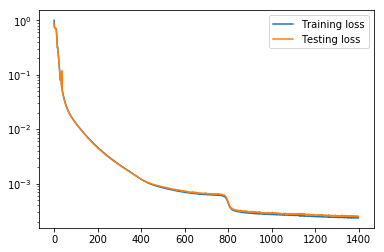

In [21]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.7439), tensor(0.6986), tensor(0.6960), tensor(0.7324), tensor(0.6820), tensor(0.6917)]


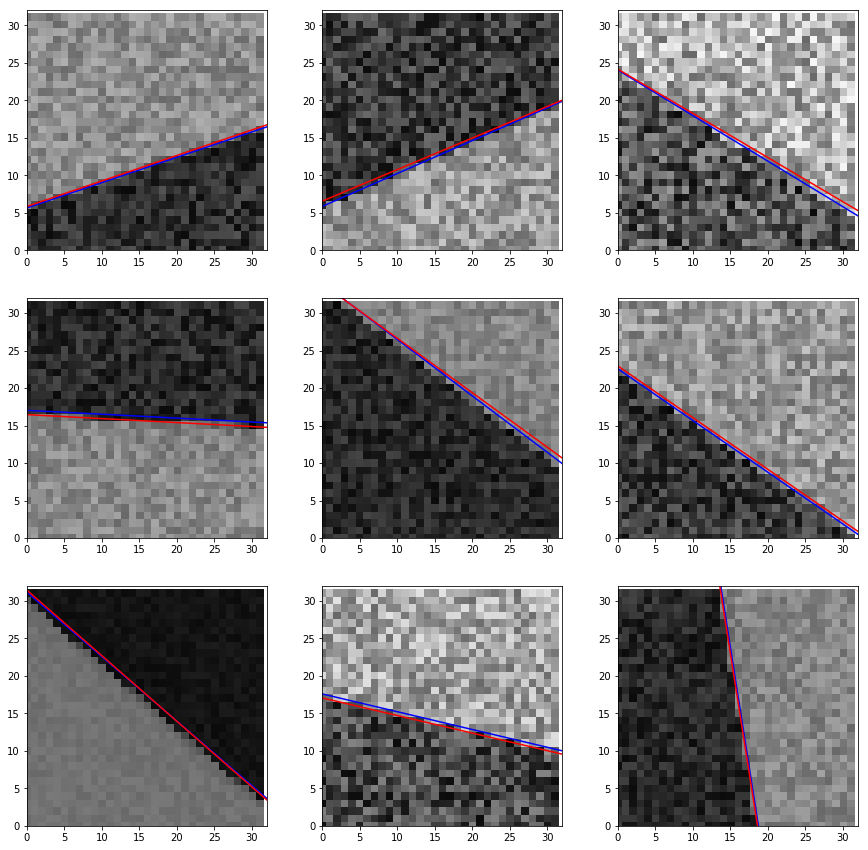

In [22]:
# Plot the Results



model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




# Add additional conv layer

In [32]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]              80
              ReLU-2            [-1, 8, 30, 30]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 1, 26, 26]              73
         MaxPool2d-6            [-1, 1, 13, 13]               0
         AvgPool2d-7              [-1, 1, 4, 4]               0
            Linear-8                    [-1, 3]              51
Total params: 788
Trainable params: 788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.00
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.36111627694438486, Avg. Test Loss: 0.1675843447446823
Epoch: 2, Avg. Train Loss: 0.09715041868826922, Avg. Test Loss: 0.055634722113609314
Epoch: 3, Avg. Train Loss: 0.038674708127098924, Avg. Test Loss: 0.02503504976630211
Epoch: 4, Avg. Train Loss: 0.020446213619673952, Avg. Test Loss: 0.019278138875961304
Epoch: 5, Avg. Train Loss: 0.01665224096573451, Avg. Test Loss: 0.015522725880146027
Epoch: 6, Avg. Train Loss: 0.014139313360347468, Avg. Test Loss: 0.013532026670873165
Epoch: 7, Avg. Train Loss: 0.012351323412183453, Avg. Test Loss: 0.011932816356420517
Epoch: 8, Avg. Train Loss: 0.010892207022098935, Avg. Test Loss: 0.010549823753535748
Epoch: 9, Avg. Train Loss: 0.009659425465061384, Avg. Test Loss: 0.009370014071464539
Epoch: 10, Avg. Train Loss: 0.00859190003179452, Avg. Test Loss: 0.008355163969099522
Epoch: 11, Avg. Train Loss: 0.007190179435864967, Avg. Test Loss: 0.006456464529037476
Epoch: 12, Avg. Train Loss: 0.005588184192995815, Avg. Test

Epoch: 94, Avg. Train Loss: 0.0004114379972794696, Avg. Test Loss: 0.00043066038051620126
Epoch: 95, Avg. Train Loss: 0.00040260793963063727, Avg. Test Loss: 0.00042120437137782574
Epoch: 96, Avg. Train Loss: 0.00039506365668357294, Avg. Test Loss: 0.0004109963483642787
Epoch: 97, Avg. Train Loss: 0.0003869273847051184, Avg. Test Loss: 0.00040420689038001
Epoch: 98, Avg. Train Loss: 0.0003813967923633754, Avg. Test Loss: 0.0004021096392534673
Epoch: 99, Avg. Train Loss: 0.00037339731523602763, Avg. Test Loss: 0.00039205243228934705
Epoch: 100, Avg. Train Loss: 0.00036913104978499603, Avg. Test Loss: 0.00038625713204964995
Epoch: 101, Avg. Train Loss: 0.00036328812369474154, Avg. Test Loss: 0.0003783516294788569
Epoch: 102, Avg. Train Loss: 0.0003582236463176634, Avg. Test Loss: 0.00037908516242168844
Epoch: 103, Avg. Train Loss: 0.0003534421591800364, Avg. Test Loss: 0.0003689151199068874
Epoch: 104, Avg. Train Loss: 0.0003505264124696088, Avg. Test Loss: 0.0003633892338257283
Epoch: 1

Epoch: 185, Avg. Train Loss: 0.0001975057170698967, Avg. Test Loss: 0.0002048354799626395
Epoch: 186, Avg. Train Loss: 0.00019639090854017173, Avg. Test Loss: 0.0002053643693216145
Epoch: 187, Avg. Train Loss: 0.0001964259897838073, Avg. Test Loss: 0.00020766185480169952
Epoch: 188, Avg. Train Loss: 0.00019514658368493924, Avg. Test Loss: 0.0002037325466517359
Epoch: 189, Avg. Train Loss: 0.00019166664980516275, Avg. Test Loss: 0.00020134028454776853
Epoch: 190, Avg. Train Loss: 0.00019105599751449465, Avg. Test Loss: 0.0002058250829577446
Epoch: 191, Avg. Train Loss: 0.00019072428232688894, Avg. Test Loss: 0.0002015535719692707
Epoch: 192, Avg. Train Loss: 0.0001900242778527386, Avg. Test Loss: 0.00019897647143807262
Epoch: 193, Avg. Train Loss: 0.00018854846797801335, Avg. Test Loss: 0.000200868264073506
Epoch: 194, Avg. Train Loss: 0.0001892611976740334, Avg. Test Loss: 0.00019890727708116174
Epoch: 195, Avg. Train Loss: 0.00018717938184957295, Avg. Test Loss: 0.00019600591622292995

Epoch: 275, Avg. Train Loss: 0.00013995043135604218, Avg. Test Loss: 0.00014991205534897745
Epoch: 276, Avg. Train Loss: 0.00013991740407244137, Avg. Test Loss: 0.00014705817739013582
Epoch: 277, Avg. Train Loss: 0.00013901266399497057, Avg. Test Loss: 0.0001473113225074485
Epoch: 278, Avg. Train Loss: 0.0001388004157514147, Avg. Test Loss: 0.0001466811227146536
Epoch: 279, Avg. Train Loss: 0.00013802142861737485, Avg. Test Loss: 0.00014577152614947408
Epoch: 280, Avg. Train Loss: 0.00013819323623251608, Avg. Test Loss: 0.00014595336688216776
Epoch: 281, Avg. Train Loss: 0.00013709628375877133, Avg. Test Loss: 0.0001443079672753811
Epoch: 282, Avg. Train Loss: 0.00013791103479246993, Avg. Test Loss: 0.00014491917681880295
Epoch: 283, Avg. Train Loss: 0.00013819952351588975, Avg. Test Loss: 0.0001446890237275511
Epoch: 284, Avg. Train Loss: 0.00013709442881757722, Avg. Test Loss: 0.0001435859448974952
Epoch: 285, Avg. Train Loss: 0.00013679407300728867, Avg. Test Loss: 0.000143413926707

Epoch: 365, Avg. Train Loss: 0.00011965758911922902, Avg. Test Loss: 0.00012515325215645134
Epoch: 366, Avg. Train Loss: 0.0001192007094847641, Avg. Test Loss: 0.00012625793169718236
Epoch: 367, Avg. Train Loss: 0.00011937445764060078, Avg. Test Loss: 0.0001273097877856344
Epoch: 368, Avg. Train Loss: 0.00011906231820295729, Avg. Test Loss: 0.00012508424697443843
Epoch: 369, Avg. Train Loss: 0.0001181861717829152, Avg. Test Loss: 0.00012528063962236047
Epoch: 370, Avg. Train Loss: 0.0001179347960072953, Avg. Test Loss: 0.00012412949581630528
Epoch: 371, Avg. Train Loss: 0.00011804503489710281, Avg. Test Loss: 0.00012434848758857697
Epoch: 372, Avg. Train Loss: 0.00011809502714587485, Avg. Test Loss: 0.00012398476246744394
Epoch: 373, Avg. Train Loss: 0.00011986489484757733, Avg. Test Loss: 0.0001249400374945253
Epoch: 374, Avg. Train Loss: 0.00011770410321118748, Avg. Test Loss: 0.00012557653826661408
Epoch: 375, Avg. Train Loss: 0.00011751358825302519, Avg. Test Loss: 0.00012394573423

Epoch: 455, Avg. Train Loss: 0.0001161752366255421, Avg. Test Loss: 0.00012190740380901843
Epoch: 456, Avg. Train Loss: 0.0001135263523525175, Avg. Test Loss: 0.00012938131112605333
Epoch: 457, Avg. Train Loss: 0.00011541688795927364, Avg. Test Loss: 0.00011831447773147374
Epoch: 458, Avg. Train Loss: 0.00011072757907266564, Avg. Test Loss: 0.000118698735604994
Epoch: 459, Avg. Train Loss: 0.00011100214974516454, Avg. Test Loss: 0.00011844755499623716
Epoch: 460, Avg. Train Loss: 0.00011138240027802942, Avg. Test Loss: 0.00011729366815416142
Epoch: 461, Avg. Train Loss: 0.00011060469114454463, Avg. Test Loss: 0.00011813169112429023
Epoch: 462, Avg. Train Loss: 0.00011103841268991614, Avg. Test Loss: 0.00011822528176708147
Epoch: 463, Avg. Train Loss: 0.00011221994346295319, Avg. Test Loss: 0.00011886879656231031
Epoch: 464, Avg. Train Loss: 0.00011195039705318563, Avg. Test Loss: 0.0001225033774971962
Epoch: 465, Avg. Train Loss: 0.00011229876219979761, Avg. Test Loss: 0.00011801727669

Epoch: 545, Avg. Train Loss: 0.00010757410499910988, Avg. Test Loss: 0.00011527407332323492
Epoch: 546, Avg. Train Loss: 0.00010654997030916788, Avg. Test Loss: 0.00011367911065462977
Epoch: 547, Avg. Train Loss: 0.00010657899496008587, Avg. Test Loss: 0.00011454845662228763
Epoch: 548, Avg. Train Loss: 0.00010855845047284246, Avg. Test Loss: 0.00011599942081375048
Epoch: 549, Avg. Train Loss: 0.00010778004584340927, Avg. Test Loss: 0.00011346103565301746
Epoch: 550, Avg. Train Loss: 0.00010684121405253845, Avg. Test Loss: 0.00011324157094350085
Epoch: 551, Avg. Train Loss: 0.00010744927011033082, Avg. Test Loss: 0.00011517349048517644
Epoch: 552, Avg. Train Loss: 0.00010839038184391992, Avg. Test Loss: 0.00011757379252230749
Epoch: 553, Avg. Train Loss: 0.00010665071835426395, Avg. Test Loss: 0.00011388994607841596
Epoch: 554, Avg. Train Loss: 0.00010615911314209156, Avg. Test Loss: 0.00011352323781466112
Epoch: 555, Avg. Train Loss: 0.00010659555418362074, Avg. Test Loss: 0.000114077

Epoch: 635, Avg. Train Loss: 0.00010355366762001616, Avg. Test Loss: 0.00011111843923572451
Epoch: 636, Avg. Train Loss: 0.00010345901768339579, Avg. Test Loss: 0.00011182334128534421
Epoch: 637, Avg. Train Loss: 0.00010379925815333776, Avg. Test Loss: 0.00011027345317415893
Epoch: 638, Avg. Train Loss: 0.00010402342398746816, Avg. Test Loss: 0.00011231100506847724
Epoch: 639, Avg. Train Loss: 0.00010335123421528431, Avg. Test Loss: 0.00010991010640282184
Epoch: 640, Avg. Train Loss: 0.00010348445271922494, Avg. Test Loss: 0.00010987029963871464
Epoch: 641, Avg. Train Loss: 0.00010288885310086805, Avg. Test Loss: 0.00010983097308780998
Epoch: 642, Avg. Train Loss: 0.00010324176015702131, Avg. Test Loss: 0.00011120131239295006
Epoch: 643, Avg. Train Loss: 0.000103175788621336, Avg. Test Loss: 0.0001093724204110913
Epoch: 644, Avg. Train Loss: 0.00010328720536028199, Avg. Test Loss: 0.00011120659473817796
Epoch: 645, Avg. Train Loss: 0.0001052569252137533, Avg. Test Loss: 0.0001105473347

Epoch: 725, Avg. Train Loss: 9.978664114468676e-05, Avg. Test Loss: 0.0001062743685906753
Epoch: 726, Avg. Train Loss: 0.00010018714366357445, Avg. Test Loss: 0.00010700407437980175
Epoch: 727, Avg. Train Loss: 0.00010048088948036927, Avg. Test Loss: 0.00010736338299466297
Epoch: 728, Avg. Train Loss: 0.00010010985801379909, Avg. Test Loss: 0.00010824854689417407
Epoch: 729, Avg. Train Loss: 0.00010020185607786784, Avg. Test Loss: 0.00010654988000169396
Epoch: 730, Avg. Train Loss: 9.986227515208371e-05, Avg. Test Loss: 0.00010744994506239891
Epoch: 731, Avg. Train Loss: 9.96122753884479e-05, Avg. Test Loss: 0.0001065379474312067
Epoch: 732, Avg. Train Loss: 9.933859409476795e-05, Avg. Test Loss: 0.00010574195766821504
Epoch: 733, Avg. Train Loss: 0.00010051220648593324, Avg. Test Loss: 0.00010817627480719239
Epoch: 734, Avg. Train Loss: 9.9984830526142e-05, Avg. Test Loss: 0.00010849731916096061
Epoch: 735, Avg. Train Loss: 9.964264694751953e-05, Avg. Test Loss: 0.0001061441726051271


Epoch: 816, Avg. Train Loss: 9.837214319679119e-05, Avg. Test Loss: 0.00010370093514211476
Epoch: 817, Avg. Train Loss: 9.943205334232462e-05, Avg. Test Loss: 0.00010427799861645326
Epoch: 818, Avg. Train Loss: 9.904445024029188e-05, Avg. Test Loss: 0.00010314222163287923
Epoch: 819, Avg. Train Loss: 9.743849445572671e-05, Avg. Test Loss: 0.00010371441021561623
Epoch: 820, Avg. Train Loss: 9.703281958697036e-05, Avg. Test Loss: 0.00010329222277505323
Epoch: 821, Avg. Train Loss: 9.709874190294238e-05, Avg. Test Loss: 0.0001032173095154576
Epoch: 822, Avg. Train Loss: 9.879678948303027e-05, Avg. Test Loss: 0.00010691925854189321
Epoch: 823, Avg. Train Loss: 9.729298001141561e-05, Avg. Test Loss: 0.00010244911391055211
Epoch: 824, Avg. Train Loss: 9.672583837527782e-05, Avg. Test Loss: 0.00010259842383675277
Epoch: 825, Avg. Train Loss: 9.681421386844972e-05, Avg. Test Loss: 0.00010450735862832516
Epoch: 826, Avg. Train Loss: 9.690945444162935e-05, Avg. Test Loss: 0.00010310841025784612


Epoch: 907, Avg. Train Loss: 9.542637930922759e-05, Avg. Test Loss: 0.00010230938642052934
Epoch: 908, Avg. Train Loss: 9.619473412920557e-05, Avg. Test Loss: 0.00010237224341835827
Epoch: 909, Avg. Train Loss: 9.617406227762866e-05, Avg. Test Loss: 0.000101602723589167
Epoch: 910, Avg. Train Loss: 9.483176964910373e-05, Avg. Test Loss: 0.00010191322508035228
Epoch: 911, Avg. Train Loss: 9.44216491702451e-05, Avg. Test Loss: 9.905976912705228e-05
Epoch: 912, Avg. Train Loss: 9.540373610113474e-05, Avg. Test Loss: 0.00010271916107740253
Epoch: 913, Avg. Train Loss: 9.636208885828691e-05, Avg. Test Loss: 0.00010246040619676933
Epoch: 914, Avg. Train Loss: 9.62215952527271e-05, Avg. Test Loss: 0.00010206320439465344
Epoch: 915, Avg. Train Loss: 9.45959597148056e-05, Avg. Test Loss: 0.00010116153134731576
Epoch: 916, Avg. Train Loss: 9.516205061706441e-05, Avg. Test Loss: 0.00010137351637240499
Epoch: 917, Avg. Train Loss: 9.527457886553534e-05, Avg. Test Loss: 0.00010078454943140969
Epoch

Epoch: 998, Avg. Train Loss: 9.227339144083945e-05, Avg. Test Loss: 9.733219485497102e-05
Epoch: 999, Avg. Train Loss: 9.253941500312922e-05, Avg. Test Loss: 9.767276787897572e-05
Epoch: 1000, Avg. Train Loss: 9.23994294306099e-05, Avg. Test Loss: 9.72739580902271e-05
Epoch: 1001, Avg. Train Loss: 9.19017376658945e-05, Avg. Test Loss: 9.746209252625704e-05
Epoch: 1002, Avg. Train Loss: 9.200940086670658e-05, Avg. Test Loss: 9.693038737168536e-05
Epoch: 1003, Avg. Train Loss: 9.242667874787003e-05, Avg. Test Loss: 9.856138785835356e-05
Epoch: 1004, Avg. Train Loss: 9.256176888490754e-05, Avg. Test Loss: 9.76853771135211e-05
Epoch: 1005, Avg. Train Loss: 9.220366465503022e-05, Avg. Test Loss: 9.934408444678411e-05
Epoch: 1006, Avg. Train Loss: 9.246683176196016e-05, Avg. Test Loss: 9.741019312059507e-05
Epoch: 1007, Avg. Train Loss: 9.151194064864231e-05, Avg. Test Loss: 9.66511870501563e-05
Epoch: 1008, Avg. Train Loss: 9.195367944330963e-05, Avg. Test Loss: 9.818408580031246e-05
Epoch:

Epoch: 1089, Avg. Train Loss: 8.990789073697455e-05, Avg. Test Loss: 9.510412928648293e-05
Epoch: 1090, Avg. Train Loss: 9.010057393050588e-05, Avg. Test Loss: 9.4459333922714e-05
Epoch: 1091, Avg. Train Loss: 9.034257142475861e-05, Avg. Test Loss: 9.472356032347307e-05
Epoch: 1092, Avg. Train Loss: 9.057903533924699e-05, Avg. Test Loss: 9.566105291014537e-05
Epoch: 1093, Avg. Train Loss: 9.140034201075596e-05, Avg. Test Loss: 9.465271432418376e-05
Epoch: 1094, Avg. Train Loss: 9.230440884814871e-05, Avg. Test Loss: 9.998303721658885e-05
Epoch: 1095, Avg. Train Loss: 9.331058347871636e-05, Avg. Test Loss: 9.724515257403255e-05
Epoch: 1096, Avg. Train Loss: 9.061889260705998e-05, Avg. Test Loss: 9.530354873277247e-05
Epoch: 1097, Avg. Train Loss: 9.044962173314107e-05, Avg. Test Loss: 9.491883974988014e-05
Epoch: 1098, Avg. Train Loss: 9.00844213046024e-05, Avg. Test Loss: 9.483251778874546e-05
Epoch: 1099, Avg. Train Loss: 9.014321575009758e-05, Avg. Test Loss: 9.561713522998616e-05
Ep

Epoch: 1180, Avg. Train Loss: 8.86680418796673e-05, Avg. Test Loss: 9.338889503851533e-05
Epoch: 1181, Avg. Train Loss: 8.920799839817097e-05, Avg. Test Loss: 9.661632066126913e-05
Epoch: 1182, Avg. Train Loss: 8.89979034100714e-05, Avg. Test Loss: 9.430399950360879e-05
Epoch: 1183, Avg. Train Loss: 8.84913991766927e-05, Avg. Test Loss: 9.355907968711108e-05
Epoch: 1184, Avg. Train Loss: 8.873388330411057e-05, Avg. Test Loss: 9.255035547539592e-05
Epoch: 1185, Avg. Train Loss: 8.838229319628547e-05, Avg. Test Loss: 9.296747157350183e-05
Epoch: 1186, Avg. Train Loss: 8.863828449701781e-05, Avg. Test Loss: 9.301240788772702e-05
Epoch: 1187, Avg. Train Loss: 8.883608268875191e-05, Avg. Test Loss: 9.331194451078773e-05
Epoch: 1188, Avg. Train Loss: 8.864650119315175e-05, Avg. Test Loss: 9.27904766285792e-05
Epoch: 1189, Avg. Train Loss: 8.891992226434762e-05, Avg. Test Loss: 9.302998660132289e-05
Epoch: 1190, Avg. Train Loss: 8.841626549838111e-05, Avg. Test Loss: 9.404966840520501e-05
Epo

Epoch: 1271, Avg. Train Loss: 8.947621673167519e-05, Avg. Test Loss: 9.369121107738465e-05
Epoch: 1272, Avg. Train Loss: 9.012564431245932e-05, Avg. Test Loss: 9.111344115808606e-05
Epoch: 1273, Avg. Train Loss: 8.905097381691175e-05, Avg. Test Loss: 9.136043809121475e-05
Epoch: 1274, Avg. Train Loss: 8.732343335663351e-05, Avg. Test Loss: 9.16786229936406e-05
Epoch: 1275, Avg. Train Loss: 8.780607116504518e-05, Avg. Test Loss: 9.108554513659328e-05
Epoch: 1276, Avg. Train Loss: 8.713097742977826e-05, Avg. Test Loss: 9.121639595832676e-05
Epoch: 1277, Avg. Train Loss: 8.6713966619059e-05, Avg. Test Loss: 9.105500066652894e-05
Epoch: 1278, Avg. Train Loss: 8.736654426149257e-05, Avg. Test Loss: 9.082611359190196e-05
Epoch: 1279, Avg. Train Loss: 8.689350044519147e-05, Avg. Test Loss: 9.233552555087954e-05
Epoch: 1280, Avg. Train Loss: 8.726837532937198e-05, Avg. Test Loss: 9.186504757963121e-05
Epoch: 1281, Avg. Train Loss: 8.68029665605932e-05, Avg. Test Loss: 9.224143286701292e-05
Epo

Epoch: 1362, Avg. Train Loss: 8.620232213562464e-05, Avg. Test Loss: 9.437522385269403e-05
Epoch: 1363, Avg. Train Loss: 8.638360390357454e-05, Avg. Test Loss: 9.056386625161394e-05
Epoch: 1364, Avg. Train Loss: 8.567952660515028e-05, Avg. Test Loss: 8.990184142021462e-05
Epoch: 1365, Avg. Train Loss: 8.547862799947753e-05, Avg. Test Loss: 8.984318992588669e-05
Epoch: 1366, Avg. Train Loss: 8.66767017321442e-05, Avg. Test Loss: 8.953564974945039e-05
Epoch: 1367, Avg. Train Loss: 8.698289286043933e-05, Avg. Test Loss: 8.918271487345919e-05
Epoch: 1368, Avg. Train Loss: 8.770651552100283e-05, Avg. Test Loss: 9.428581688553095e-05
Epoch: 1369, Avg. Train Loss: 8.591329327935134e-05, Avg. Test Loss: 8.913359488360584e-05
Epoch: 1370, Avg. Train Loss: 8.611978838042192e-05, Avg. Test Loss: 8.939084364101291e-05
Epoch: 1371, Avg. Train Loss: 8.57853190288605e-05, Avg. Test Loss: 9.026537736644968e-05
Epoch: 1372, Avg. Train Loss: 8.583591432611952e-05, Avg. Test Loss: 8.979134145192802e-05
E

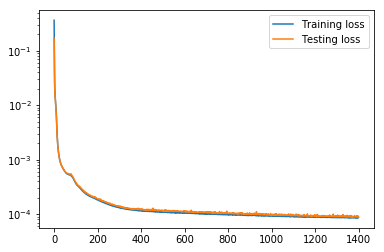

In [33]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.4917), tensor(0.4982), tensor(0.4596), tensor(0.5180), tensor(0.5194), tensor(0.4743)]


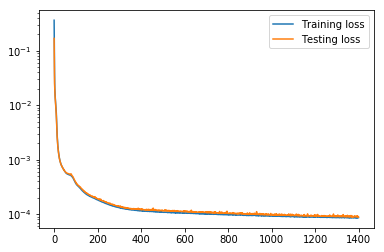

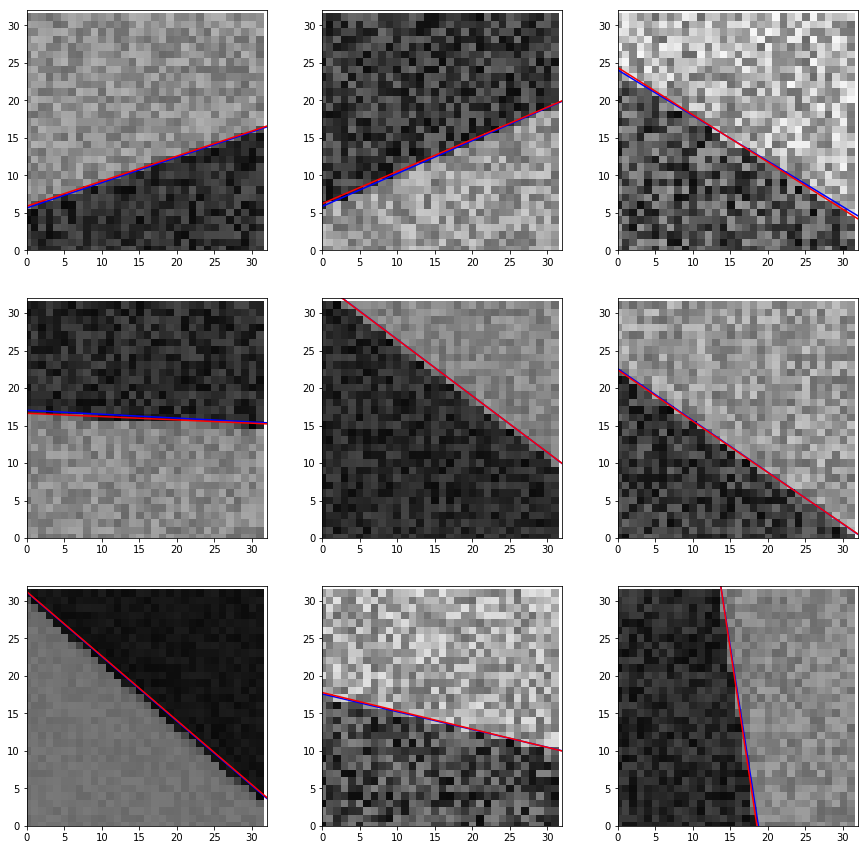

In [37]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')





# Reduce # of parameters

In [39]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3)
        self.conv3 = nn.Conv2d(4, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]              40
              ReLU-2            [-1, 4, 30, 30]               0
            Conv2d-3            [-1, 4, 28, 28]             148
              ReLU-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 1, 26, 26]              37
         MaxPool2d-6            [-1, 1, 13, 13]               0
         AvgPool2d-7              [-1, 1, 4, 4]               0
            Linear-8                    [-1, 3]              51
Total params: 276
Trainable params: 276
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.00
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.7342312861891354, Avg. Test Loss: 0.6546053886413574
Epoch: 2, Avg. Train Loss: 0.5921276614946478, Avg. Test Loss: 0.4810595214366913
Epoch: 3, Avg. Train Loss: 0.26163389270796494, Avg. Test Loss: 0.09154365956783295
Epoch: 4, Avg. Train Loss: 0.06759351031745181, Avg. Test Loss: 0.03470965102314949
Epoch: 5, Avg. Train Loss: 0.024648768169914976, Avg. Test Loss: 0.0208112895488739
Epoch: 6, Avg. Train Loss: 0.017889059586998296, Avg. Test Loss: 0.016355812549591064
Epoch: 7, Avg. Train Loss: 0.014215130578069127, Avg. Test Loss: 0.013184279203414917
Epoch: 8, Avg. Train Loss: 0.011414037743473755, Avg. Test Loss: 0.010577304288744926
Epoch: 9, Avg. Train Loss: 0.009227308061193018, Avg. Test Loss: 0.008563787676393986
Epoch: 10, Avg. Train Loss: 0.00756172912524027, Avg. Test Loss: 0.0070505584590137005
Epoch: 11, Avg. Train Loss: 0.005997193703318343, Avg. Test Loss: 0.005364858545362949
Epoch: 12, Avg. Train Loss: 0.00479039316996932, Avg. Test Loss: 0

Epoch: 94, Avg. Train Loss: 0.0005053625209257007, Avg. Test Loss: 0.0005151084624230862
Epoch: 95, Avg. Train Loss: 0.0005047527991016122, Avg. Test Loss: 0.0005131414509378374
Epoch: 96, Avg. Train Loss: 0.0005047156095422586, Avg. Test Loss: 0.0005163592286407948
Epoch: 97, Avg. Train Loss: 0.0005029004327405025, Avg. Test Loss: 0.0005112758371978998
Epoch: 98, Avg. Train Loss: 0.0005024236606379203, Avg. Test Loss: 0.0005127751501277089
Epoch: 99, Avg. Train Loss: 0.0005001226518823601, Avg. Test Loss: 0.0005142702138982713
Epoch: 100, Avg. Train Loss: 0.0005012921602054335, Avg. Test Loss: 0.0005114960949867964
Epoch: 101, Avg. Train Loss: 0.0004999453188194072, Avg. Test Loss: 0.0005130894132889807
Epoch: 102, Avg. Train Loss: 0.0005014649188310347, Avg. Test Loss: 0.0005080375703983009
Epoch: 103, Avg. Train Loss: 0.0004980497606619097, Avg. Test Loss: 0.0005099679692648351
Epoch: 104, Avg. Train Loss: 0.000498772963456919, Avg. Test Loss: 0.0005097537068650126
Epoch: 105, Avg. 

Epoch: 186, Avg. Train Loss: 0.00047580607454566397, Avg. Test Loss: 0.0004929741844534874
Epoch: 187, Avg. Train Loss: 0.0004756684870431747, Avg. Test Loss: 0.0004928178386762738
Epoch: 188, Avg. Train Loss: 0.00047377708046149244, Avg. Test Loss: 0.0004910177085548639
Epoch: 189, Avg. Train Loss: 0.00047565079705022713, Avg. Test Loss: 0.0004928308771923184
Epoch: 190, Avg. Train Loss: 0.00047318332294440447, Avg. Test Loss: 0.000492010498419404
Epoch: 191, Avg. Train Loss: 0.0004770073197398554, Avg. Test Loss: 0.0004970781737938523
Epoch: 192, Avg. Train Loss: 0.00047550376107477965, Avg. Test Loss: 0.000502491369843483
Epoch: 193, Avg. Train Loss: 0.0004763085864183, Avg. Test Loss: 0.0004933591699227691
Epoch: 194, Avg. Train Loss: 0.00047688300872002453, Avg. Test Loss: 0.0005047189770266414
Epoch: 195, Avg. Train Loss: 0.00047687715542612266, Avg. Test Loss: 0.000491245707962662
Epoch: 196, Avg. Train Loss: 0.0004724571566946585, Avg. Test Loss: 0.0004938627826049924
Epoch: 19

Epoch: 277, Avg. Train Loss: 0.0004652568621917025, Avg. Test Loss: 0.00048317492473870516
Epoch: 278, Avg. Train Loss: 0.0004701338561169584, Avg. Test Loss: 0.0004883421934209764
Epoch: 279, Avg. Train Loss: 0.00046506207196644563, Avg. Test Loss: 0.00048731453716754913
Epoch: 280, Avg. Train Loss: 0.0004666553594528095, Avg. Test Loss: 0.0004918444319628179
Epoch: 281, Avg. Train Loss: 0.00046285895822460163, Avg. Test Loss: 0.0004816229338757694
Epoch: 282, Avg. Train Loss: 0.0004602876673315597, Avg. Test Loss: 0.0004821529146283865
Epoch: 283, Avg. Train Loss: 0.00045758677023353386, Avg. Test Loss: 0.00047662132419645786
Epoch: 284, Avg. Train Loss: 0.00045518627944950233, Avg. Test Loss: 0.0004709759377874434
Epoch: 285, Avg. Train Loss: 0.00044603801079039625, Avg. Test Loss: 0.0004572163743432611
Epoch: 286, Avg. Train Loss: 0.000434601357590188, Avg. Test Loss: 0.000451578147476539
Epoch: 287, Avg. Train Loss: 0.00041977846858036867, Avg. Test Loss: 0.0004315093392506242
Epo

Epoch: 368, Avg. Train Loss: 0.00020684532543836052, Avg. Test Loss: 0.0002152028027921915
Epoch: 369, Avg. Train Loss: 0.00020512366865980714, Avg. Test Loss: 0.00021545733034145087
Epoch: 370, Avg. Train Loss: 0.00020471954143003505, Avg. Test Loss: 0.0002143504098057747
Epoch: 371, Avg. Train Loss: 0.0002044834348934648, Avg. Test Loss: 0.00021288868447300047
Epoch: 372, Avg. Train Loss: 0.00020464068545740754, Avg. Test Loss: 0.0002135760587407276
Epoch: 373, Avg. Train Loss: 0.00020289388981729965, Avg. Test Loss: 0.00021227082470431924
Epoch: 374, Avg. Train Loss: 0.00020235295746448066, Avg. Test Loss: 0.0002115225070156157
Epoch: 375, Avg. Train Loss: 0.0002015031358870842, Avg. Test Loss: 0.00021253059094306082
Epoch: 376, Avg. Train Loss: 0.0002014070495908313, Avg. Test Loss: 0.00021080246369820088
Epoch: 377, Avg. Train Loss: 0.00020109314509147012, Avg. Test Loss: 0.0002090483030769974
Epoch: 378, Avg. Train Loss: 0.00020009982279803166, Avg. Test Loss: 0.00020992345525883

Epoch: 458, Avg. Train Loss: 0.00016539506203330616, Avg. Test Loss: 0.00017307423695456237
Epoch: 459, Avg. Train Loss: 0.00016549265916075776, Avg. Test Loss: 0.00017311275587417185
Epoch: 460, Avg. Train Loss: 0.0001649735409848611, Avg. Test Loss: 0.0001707682677078992
Epoch: 461, Avg. Train Loss: 0.0001644222964601153, Avg. Test Loss: 0.00017205595213454217
Epoch: 462, Avg. Train Loss: 0.0001644979963791283, Avg. Test Loss: 0.00016958970809355378
Epoch: 463, Avg. Train Loss: 0.00016363371190998484, Avg. Test Loss: 0.00017252167162951082
Epoch: 464, Avg. Train Loss: 0.00016394763695322634, Avg. Test Loss: 0.00016924735973589122
Epoch: 465, Avg. Train Loss: 0.00016206016623661578, Avg. Test Loss: 0.00016752482042647898
Epoch: 466, Avg. Train Loss: 0.00016162895960459376, Avg. Test Loss: 0.00016762303130235523
Epoch: 467, Avg. Train Loss: 0.00016149181122754644, Avg. Test Loss: 0.0001672667422099039
Epoch: 468, Avg. Train Loss: 0.0001602159087162684, Avg. Test Loss: 0.000165263132657

Epoch: 548, Avg. Train Loss: 0.00013523813771933098, Avg. Test Loss: 0.00013563226093538105
Epoch: 549, Avg. Train Loss: 0.00013371538422207404, Avg. Test Loss: 0.00013698764087166637
Epoch: 550, Avg. Train Loss: 0.00013416174966978897, Avg. Test Loss: 0.00013724206655751914
Epoch: 551, Avg. Train Loss: 0.00013346284300924335, Avg. Test Loss: 0.0001366464130114764
Epoch: 552, Avg. Train Loss: 0.0001324209091869895, Avg. Test Loss: 0.0001354837731923908
Epoch: 553, Avg. Train Loss: 0.000131736218891627, Avg. Test Loss: 0.00013429965474642813
Epoch: 554, Avg. Train Loss: 0.0001323655340135755, Avg. Test Loss: 0.00013498580665327609
Epoch: 555, Avg. Train Loss: 0.0001317950920886634, Avg. Test Loss: 0.00013640693214256316
Epoch: 556, Avg. Train Loss: 0.00013249721258248696, Avg. Test Loss: 0.00013578534708358347
Epoch: 557, Avg. Train Loss: 0.00013225759903434664, Avg. Test Loss: 0.0001347273646388203
Epoch: 558, Avg. Train Loss: 0.0001313220795161803, Avg. Test Loss: 0.000133925146656110

Epoch: 638, Avg. Train Loss: 0.0001205083728350206, Avg. Test Loss: 0.0001238458789885044
Epoch: 639, Avg. Train Loss: 0.00012099432933609933, Avg. Test Loss: 0.00012228629202581942
Epoch: 640, Avg. Train Loss: 0.00012162692891091437, Avg. Test Loss: 0.00012303204857744277
Epoch: 641, Avg. Train Loss: 0.00012057833116748097, Avg. Test Loss: 0.00012235995382070541
Epoch: 642, Avg. Train Loss: 0.00012181344123639385, Avg. Test Loss: 0.00012304101255722344
Epoch: 643, Avg. Train Loss: 0.00012113008115728222, Avg. Test Loss: 0.00012263422831892967
Epoch: 644, Avg. Train Loss: 0.00012112414311987403, Avg. Test Loss: 0.00012199035700177774
Epoch: 645, Avg. Train Loss: 0.00011973111267092035, Avg. Test Loss: 0.00012132646224927157
Epoch: 646, Avg. Train Loss: 0.0001196153847130892, Avg. Test Loss: 0.00012115230492781848
Epoch: 647, Avg. Train Loss: 0.00011944920569315881, Avg. Test Loss: 0.00012177320604678243
Epoch: 648, Avg. Train Loss: 0.00012000602360143709, Avg. Test Loss: 0.000121357268

Epoch: 728, Avg. Train Loss: 0.00011772174484041684, Avg. Test Loss: 0.0001159641396952793
Epoch: 729, Avg. Train Loss: 0.00011559897179455113, Avg. Test Loss: 0.00011595473915804178
Epoch: 730, Avg. Train Loss: 0.00011452296894276515, Avg. Test Loss: 0.00011619260476436466
Epoch: 731, Avg. Train Loss: 0.00011428155780509663, Avg. Test Loss: 0.0001154811616288498
Epoch: 732, Avg. Train Loss: 0.00011393685503314962, Avg. Test Loss: 0.00011746375093935058
Epoch: 733, Avg. Train Loss: 0.00011509941567269648, Avg. Test Loss: 0.00011563194857444614
Epoch: 734, Avg. Train Loss: 0.00011446087335250067, Avg. Test Loss: 0.00011562810686882585
Epoch: 735, Avg. Train Loss: 0.00011392317024086985, Avg. Test Loss: 0.00011518917744979262
Epoch: 736, Avg. Train Loss: 0.00011400243709110381, Avg. Test Loss: 0.00011508884927025065
Epoch: 737, Avg. Train Loss: 0.0001137012368417345, Avg. Test Loss: 0.00011568277841433883
Epoch: 738, Avg. Train Loss: 0.00011376100112957989, Avg. Test Loss: 0.000115817398

Epoch: 818, Avg. Train Loss: 0.00011095496772802161, Avg. Test Loss: 0.00011163781164214015
Epoch: 819, Avg. Train Loss: 0.00011048593938432853, Avg. Test Loss: 0.00011342923244228587
Epoch: 820, Avg. Train Loss: 0.00011051675777279717, Avg. Test Loss: 0.00011158661072840914
Epoch: 821, Avg. Train Loss: 0.00011250006141113666, Avg. Test Loss: 0.00011244327470194548
Epoch: 822, Avg. Train Loss: 0.00011158734859611072, Avg. Test Loss: 0.00011161991278640926
Epoch: 823, Avg. Train Loss: 0.00011055280543480287, Avg. Test Loss: 0.00011251831892877817
Epoch: 824, Avg. Train Loss: 0.00011224308400414884, Avg. Test Loss: 0.00011314022412989289
Epoch: 825, Avg. Train Loss: 0.00011107363346073886, Avg. Test Loss: 0.000112998386612162
Epoch: 826, Avg. Train Loss: 0.0001099169539349318, Avg. Test Loss: 0.00011146736505907029
Epoch: 827, Avg. Train Loss: 0.00011010385702213491, Avg. Test Loss: 0.00011145564349135384
Epoch: 828, Avg. Train Loss: 0.00011028104328194305, Avg. Test Loss: 0.000112853143

Epoch: 908, Avg. Train Loss: 0.00010759294587735305, Avg. Test Loss: 0.00010952948650810868
Epoch: 909, Avg. Train Loss: 0.00010760013880345094, Avg. Test Loss: 0.00010962900705635548
Epoch: 910, Avg. Train Loss: 0.00010822946847731466, Avg. Test Loss: 0.00011471612378954887
Epoch: 911, Avg. Train Loss: 0.0001093817494727452, Avg. Test Loss: 0.0001091189551516436
Epoch: 912, Avg. Train Loss: 0.00010805223898975836, Avg. Test Loss: 0.00011191538942512125
Epoch: 913, Avg. Train Loss: 0.00010895430665079723, Avg. Test Loss: 0.00010966490663122386
Epoch: 914, Avg. Train Loss: 0.00010911463665680083, Avg. Test Loss: 0.00010930318239843473
Epoch: 915, Avg. Train Loss: 0.0001079140231869293, Avg. Test Loss: 0.00010865937656490132
Epoch: 916, Avg. Train Loss: 0.00010815229496288607, Avg. Test Loss: 0.0001095175975933671
Epoch: 917, Avg. Train Loss: 0.00010893541227286572, Avg. Test Loss: 0.00010903274232987314
Epoch: 918, Avg. Train Loss: 0.0001082112263675834, Avg. Test Loss: 0.00011046088184

Epoch: 998, Avg. Train Loss: 0.00010580008058562217, Avg. Test Loss: 0.00010680283594410866
Epoch: 999, Avg. Train Loss: 0.00010587641394094509, Avg. Test Loss: 0.00010877051681745797
Epoch: 1000, Avg. Train Loss: 0.00010548061896663378, Avg. Test Loss: 0.00010731603833846748
Epoch: 1001, Avg. Train Loss: 0.00010587162464884493, Avg. Test Loss: 0.00010711612412706017
Epoch: 1002, Avg. Train Loss: 0.00010669522752697744, Avg. Test Loss: 0.0001069467980414629
Epoch: 1003, Avg. Train Loss: 0.00010566881888628225, Avg. Test Loss: 0.0001084522227756679
Epoch: 1004, Avg. Train Loss: 0.00010612029120024731, Avg. Test Loss: 0.00010753383685369045
Epoch: 1005, Avg. Train Loss: 0.00010594479553059072, Avg. Test Loss: 0.00010858099267352372
Epoch: 1006, Avg. Train Loss: 0.00010569883135544574, Avg. Test Loss: 0.00010705374006647617
Epoch: 1007, Avg. Train Loss: 0.00010525527357137488, Avg. Test Loss: 0.00010688127076718956
Epoch: 1008, Avg. Train Loss: 0.00010592541066751651, Avg. Test Loss: 0.00

Epoch: 1087, Avg. Train Loss: 0.00010479761754943277, Avg. Test Loss: 0.00011196813284186646
Epoch: 1088, Avg. Train Loss: 0.00010620019105879371, Avg. Test Loss: 0.00010581354581518099
Epoch: 1089, Avg. Train Loss: 0.00010383052679518347, Avg. Test Loss: 0.00010529477731324732
Epoch: 1090, Avg. Train Loss: 0.0001039688230615438, Avg. Test Loss: 0.00010470037523191422
Epoch: 1091, Avg. Train Loss: 0.00010382634868352291, Avg. Test Loss: 0.00010747168562375009
Epoch: 1092, Avg. Train Loss: 0.00010425161727813676, Avg. Test Loss: 0.00010536990885157138
Epoch: 1093, Avg. Train Loss: 0.00010480169465368176, Avg. Test Loss: 0.00010484552331035957
Epoch: 1094, Avg. Train Loss: 0.0001041207108167274, Avg. Test Loss: 0.00010462266800459474
Epoch: 1095, Avg. Train Loss: 0.00010471110641340013, Avg. Test Loss: 0.00010497500625206158
Epoch: 1096, Avg. Train Loss: 0.0001034062318948974, Avg. Test Loss: 0.00010493431182112545
Epoch: 1097, Avg. Train Loss: 0.00010353625625344542, Avg. Test Loss: 0.0

Epoch: 1176, Avg. Train Loss: 0.00010294324473601163, Avg. Test Loss: 0.00010363946785219014
Epoch: 1177, Avg. Train Loss: 0.00010240745990920593, Avg. Test Loss: 0.00010471494169905782
Epoch: 1178, Avg. Train Loss: 0.00010353181706330575, Avg. Test Loss: 0.0001045923781930469
Epoch: 1179, Avg. Train Loss: 0.00010295821780078661, Avg. Test Loss: 0.00010550035949563608
Epoch: 1180, Avg. Train Loss: 0.00010409733016893049, Avg. Test Loss: 0.00010369291703682393
Epoch: 1181, Avg. Train Loss: 0.00010350880791734466, Avg. Test Loss: 0.00010466744424775243
Epoch: 1182, Avg. Train Loss: 0.0001031154439688715, Avg. Test Loss: 0.00010342372115701437
Epoch: 1183, Avg. Train Loss: 0.00010209630272584036, Avg. Test Loss: 0.00010465126251801848
Epoch: 1184, Avg. Train Loss: 0.00010269359165035626, Avg. Test Loss: 0.0001044110395014286
Epoch: 1185, Avg. Train Loss: 0.00010244185935281327, Avg. Test Loss: 0.00010362335888203233
Epoch: 1186, Avg. Train Loss: 0.00010213651737157146, Avg. Test Loss: 0.0

Epoch: 1265, Avg. Train Loss: 0.00010276945549241431, Avg. Test Loss: 0.00010296535037923604
Epoch: 1266, Avg. Train Loss: 0.00010340831795474514, Avg. Test Loss: 0.0001065334799932316
Epoch: 1267, Avg. Train Loss: 0.00010241069685434923, Avg. Test Loss: 0.00010391780961072072
Epoch: 1268, Avg. Train Loss: 0.0001012037374654456, Avg. Test Loss: 0.00010208880848949775
Epoch: 1269, Avg. Train Loss: 0.00010143946008825237, Avg. Test Loss: 0.00010393664706498384
Epoch: 1270, Avg. Train Loss: 0.00010205906993873855, Avg. Test Loss: 0.00010327155177947134
Epoch: 1271, Avg. Train Loss: 0.0001015635926331229, Avg. Test Loss: 0.00010245606245007366
Epoch: 1272, Avg. Train Loss: 0.00010072536251220085, Avg. Test Loss: 0.00010301526344846934
Epoch: 1273, Avg. Train Loss: 0.00010173032847780953, Avg. Test Loss: 0.00010300805297447369
Epoch: 1274, Avg. Train Loss: 0.00010169236595495877, Avg. Test Loss: 0.00010192317131441087
Epoch: 1275, Avg. Train Loss: 0.0001008150861975189, Avg. Test Loss: 0.00

Epoch: 1354, Avg. Train Loss: 0.00010352515613810872, Avg. Test Loss: 0.00010225907317362726
Epoch: 1355, Avg. Train Loss: 0.00010394839260056066, Avg. Test Loss: 0.00010546645353315398
Epoch: 1356, Avg. Train Loss: 0.00010249902569579289, Avg. Test Loss: 0.0001011866406770423
Epoch: 1357, Avg. Train Loss: 0.00010014744646682898, Avg. Test Loss: 0.00010106725676450878
Epoch: 1358, Avg. Train Loss: 0.00010012342168278444, Avg. Test Loss: 0.00010141359962290153
Epoch: 1359, Avg. Train Loss: 0.00010010876876014449, Avg. Test Loss: 0.0001023156801238656
Epoch: 1360, Avg. Train Loss: 0.00010059807434171329, Avg. Test Loss: 0.00010316973202861845
Epoch: 1361, Avg. Train Loss: 0.00010141879722462309, Avg. Test Loss: 0.00010134709009435028
Epoch: 1362, Avg. Train Loss: 0.00010038208925192627, Avg. Test Loss: 0.000102057951153256
Epoch: 1363, Avg. Train Loss: 0.00010047013005104793, Avg. Test Loss: 0.0001011708372971043
Epoch: 1364, Avg. Train Loss: 0.00010050277727286277, Avg. Test Loss: 0.000

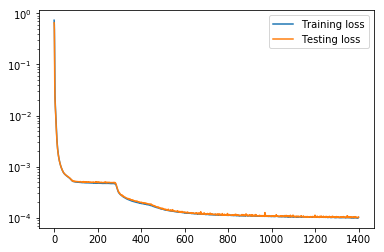

In [40]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.5234), tensor(0.5422), tensor(0.4651), tensor(0.5252), tensor(0.5485), tensor(0.4906)]


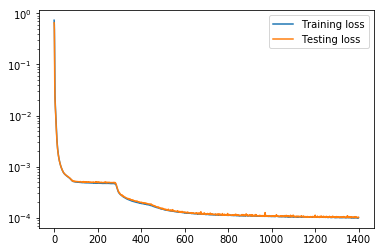

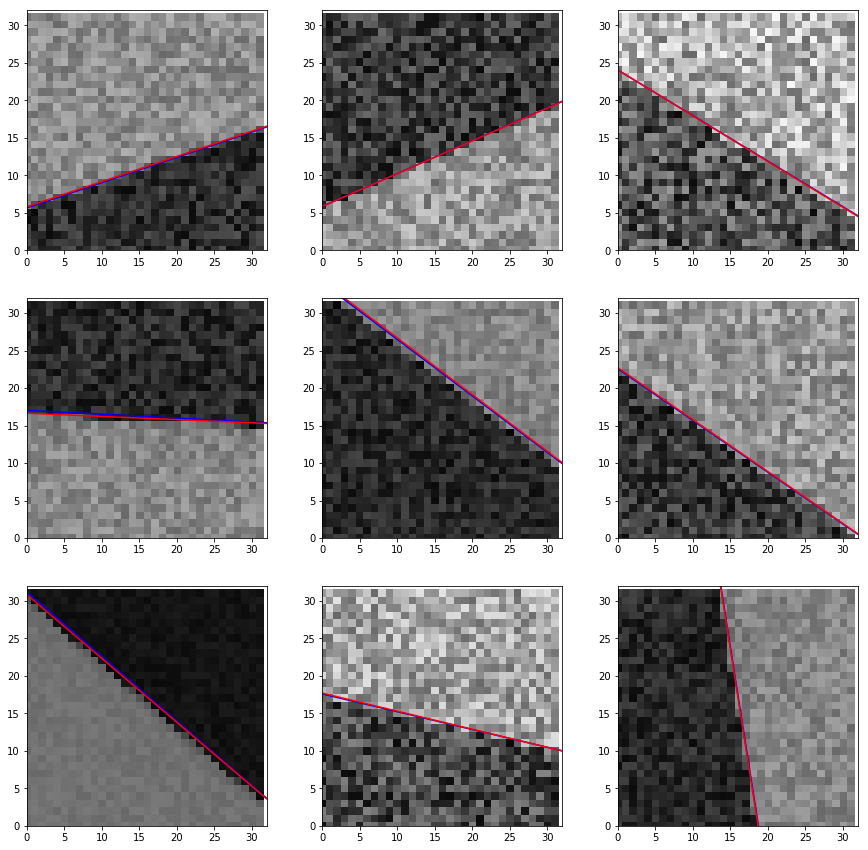

In [41]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')






# Test Network on multicolor images

10000


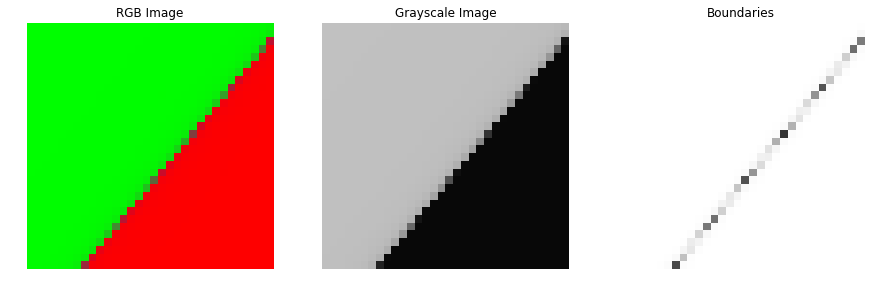

In [42]:
# line_data_32_10000_grey_multicolor_centered.pkl

# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_multicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset_TEST, test_dataset_TEST = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader_TEST = torch.utils.data.DataLoader(train_dataset_TEST, batch_size=500, shuffle=True)
test_loader_TEST = torch.utils.data.DataLoader(test_dataset_TEST, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


[tensor(10.5831), tensor(10.4288), tensor(10.5090)]
tensor([-0.9947,  0.1033,  0.2235])
tensor([-0.9862,  0.1653, -0.1802])
cat
tensor([ 0.8190, -0.5738, -0.3594])
tensor([ 0.7025, -0.7117,  1.5843])
cat
tensor([0.8842, 0.4671, 0.1248])
tensor([0.9667, 0.2559, 2.7073])
cat
tensor([-0.6655, -0.7464, -0.3772])
tensor([-0.6644, -0.7473, -0.3485])
cat
tensor([-0.5608, -0.8279, -0.2824])
tensor([-0.5580, -0.8299, -0.2774])
cat
tensor([-0.2114, -0.9774, -0.4044])
tensor([-0.1955, -0.9807, -0.3647])
cat
tensor([-0.9670, -0.2549,  0.1425])
tensor([-0.9670, -0.2549,  0.1819])
cat
tensor([-0.5217,  0.8531,  0.4492])
tensor([-0.5134,  0.8582,  0.4588])
cat
tensor([-0.9773,  0.2119,  0.3941])
tensor([-0.9823,  0.1876,  0.4029])
cat


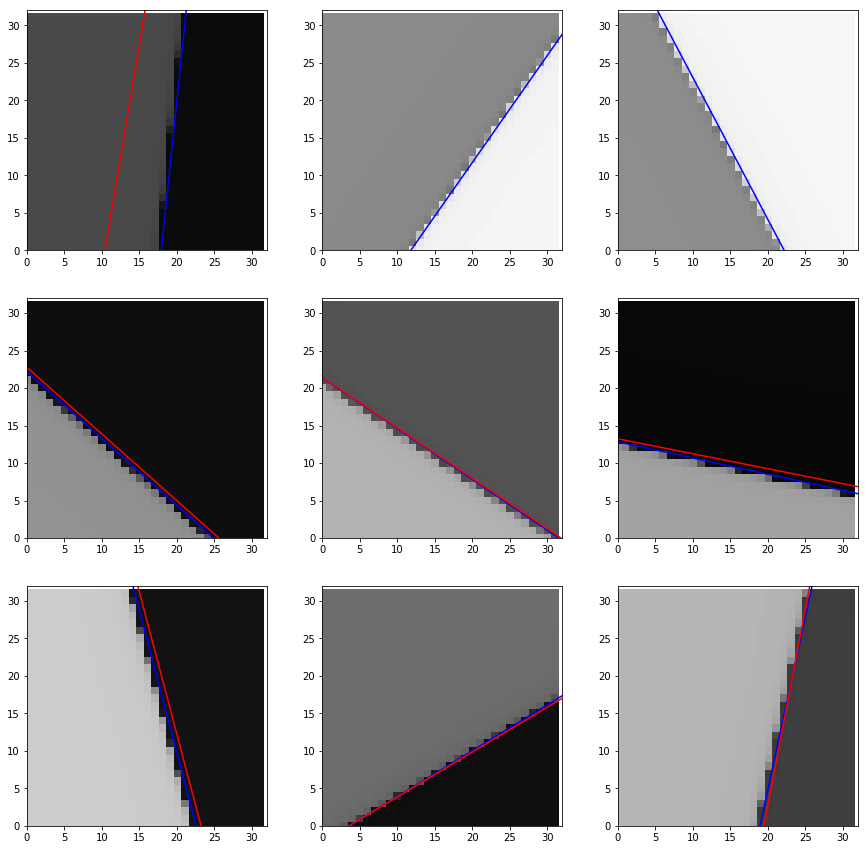

In [48]:
# Plot the Results


W,H = 32,32

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader_TEST):
    # get the input images and their corresponding labels
    
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    print(angle_params[ii,:])
    print(outputs[ii,:])
    print('cat')
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')



# Train on noisy, multicolor images

50000


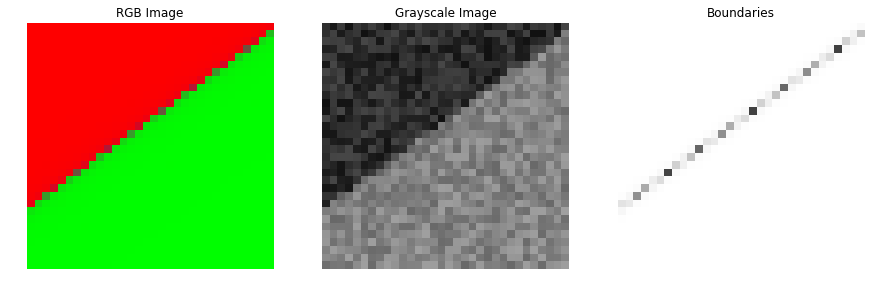

In [71]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_50000_grey_multicolor_noise_random_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');






In [78]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5            [-1, 1, 26, 26]             145
         MaxPool2d-6            [-1, 1, 13, 13]               0
         AvgPool2d-7              [-1, 1, 4, 4]               0
            Linear-8                    [-1, 3]              51
Total params: 2,676
Trainable params: 2,676
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.01
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.5879572567551635, Avg. Test Loss: 0.40938201546669006
Epoch: 2, Avg. Train Loss: 0.22712383956410165, Avg. Test Loss: 0.11857637017965317
Epoch: 3, Avg. Train Loss: 0.0982338635380878, Avg. Test Loss: 0.13516800105571747
Epoch: 4, Avg. Train Loss: 0.03642498849089756, Avg. Test Loss: 0.03633914515376091
Epoch: 5, Avg. Train Loss: 0.04079879725048708, Avg. Test Loss: 0.031597428023815155
Epoch: 6, Avg. Train Loss: 0.02128811743716861, Avg. Test Loss: 0.01782616786658764
Epoch: 7, Avg. Train Loss: 0.017058461168131162, Avg. Test Loss: 0.019417980685830116
Epoch: 8, Avg. Train Loss: 0.037058186110888805, Avg. Test Loss: 0.10818663239479065
Epoch: 9, Avg. Train Loss: 0.034429779622790424, Avg. Test Loss: 0.013447605073451996
Epoch: 10, Avg. Train Loss: 0.011155347448102263, Avg. Test Loss: 0.00998507160693407
Epoch: 11, Avg. Train Loss: 0.006801398687584456, Avg. Test Loss: 0.005154397338628769
Epoch: 12, Avg. Train Loss: 0.004169350560364681, Avg. Test Loss: 0

Epoch: 94, Avg. Train Loss: 0.0009550006943754852, Avg. Test Loss: 0.0009525557397864759
Epoch: 95, Avg. Train Loss: 0.000946355901041263, Avg. Test Loss: 0.0009475421393290162
Epoch: 96, Avg. Train Loss: 0.000949453967244386, Avg. Test Loss: 0.0009610796696506441
Epoch: 97, Avg. Train Loss: 0.0009545306783429412, Avg. Test Loss: 0.0009605076629668474
Epoch: 98, Avg. Train Loss: 0.0009522998494334346, Avg. Test Loss: 0.0009475995320826769
Epoch: 99, Avg. Train Loss: 0.0009523635191388081, Avg. Test Loss: 0.0009439685381948948
Epoch: 100, Avg. Train Loss: 0.000950517995163885, Avg. Test Loss: 0.0009466137853451073
Epoch: 101, Avg. Train Loss: 0.0009501691025053693, Avg. Test Loss: 0.0009546859073452652
Epoch: 102, Avg. Train Loss: 0.0009575074479027196, Avg. Test Loss: 0.0009613293805159628
Epoch: 103, Avg. Train Loss: 0.0009439992515348591, Avg. Test Loss: 0.0009701505769044161
Epoch: 104, Avg. Train Loss: 0.0009552494238325676, Avg. Test Loss: 0.0009395603556185961
Epoch: 105, Avg. Tr

Epoch: 186, Avg. Train Loss: 0.0008667898905831714, Avg. Test Loss: 0.0008736171876080334
Epoch: 187, Avg. Train Loss: 0.0008637676351205554, Avg. Test Loss: 0.0008853505714796484
Epoch: 188, Avg. Train Loss: 0.0008620543738415595, Avg. Test Loss: 0.0008741390192881227
Epoch: 189, Avg. Train Loss: 0.000863277112393705, Avg. Test Loss: 0.0008692160481587052
Epoch: 190, Avg. Train Loss: 0.000863372283272965, Avg. Test Loss: 0.000870773452334106
Epoch: 191, Avg. Train Loss: 0.0008675100398249924, Avg. Test Loss: 0.0008683046908117831
Epoch: 192, Avg. Train Loss: 0.000858145828228877, Avg. Test Loss: 0.0008707455708645284
Epoch: 193, Avg. Train Loss: 0.0008603793428127849, Avg. Test Loss: 0.0008722853963263333
Epoch: 194, Avg. Train Loss: 0.0008635338893983254, Avg. Test Loss: 0.0008623113972134888
Epoch: 195, Avg. Train Loss: 0.0008549857126592203, Avg. Test Loss: 0.0008634498226456344
Epoch: 196, Avg. Train Loss: 0.0008563948010072805, Avg. Test Loss: 0.0008598770364187658
Epoch: 197, Av

Epoch: 278, Avg. Train Loss: 0.0007778897564749905, Avg. Test Loss: 0.0007983057876117527
Epoch: 279, Avg. Train Loss: 0.0007788814173816422, Avg. Test Loss: 0.0007977324421517551
Epoch: 280, Avg. Train Loss: 0.0007774967559461677, Avg. Test Loss: 0.0007946437108330429
Epoch: 281, Avg. Train Loss: 0.0007757276924716872, Avg. Test Loss: 0.000785173149779439
Epoch: 282, Avg. Train Loss: 0.0007773323436700847, Avg. Test Loss: 0.0007855934090912342
Epoch: 283, Avg. Train Loss: 0.0007793511342538824, Avg. Test Loss: 0.0007918610353954136
Epoch: 284, Avg. Train Loss: 0.0007832838915461718, Avg. Test Loss: 0.0007908148691058159
Epoch: 285, Avg. Train Loss: 0.00077706579590043, Avg. Test Loss: 0.0007955587352626026
Epoch: 286, Avg. Train Loss: 0.000777686508859746, Avg. Test Loss: 0.0007867907406762242
Epoch: 287, Avg. Train Loss: 0.0007840151286705636, Avg. Test Loss: 0.0007843416533432901
Epoch: 288, Avg. Train Loss: 0.0007777781371936895, Avg. Test Loss: 0.0007841502083465457
Epoch: 289, Av

Epoch: 370, Avg. Train Loss: 0.0007433877705574728, Avg. Test Loss: 0.000744605902582407
Epoch: 371, Avg. Train Loss: 0.0007424595099765548, Avg. Test Loss: 0.0007456005550920963
Epoch: 372, Avg. Train Loss: 0.0007404767472275294, Avg. Test Loss: 0.0007355289999395609
Epoch: 373, Avg. Train Loss: 0.0007376525940936665, Avg. Test Loss: 0.0007513061282224953
Epoch: 374, Avg. Train Loss: 0.0007413632837449048, Avg. Test Loss: 0.0007312453235499561
Epoch: 375, Avg. Train Loss: 0.0007364959564319876, Avg. Test Loss: 0.0007355606066994369
Epoch: 376, Avg. Train Loss: 0.0007392375467366778, Avg. Test Loss: 0.0007285590982064605
Epoch: 377, Avg. Train Loss: 0.0007387405196421368, Avg. Test Loss: 0.0007285575265996158
Epoch: 378, Avg. Train Loss: 0.0007369938187387794, Avg. Test Loss: 0.0007290181238204241
Epoch: 379, Avg. Train Loss: 0.0007352905109697997, Avg. Test Loss: 0.0007387516088783741
Epoch: 380, Avg. Train Loss: 0.0007334555442401663, Avg. Test Loss: 0.0007271301001310349
Epoch: 381,

Epoch: 462, Avg. Train Loss: 0.0006738784844813825, Avg. Test Loss: 0.0006757988012395799
Epoch: 463, Avg. Train Loss: 0.0006804822762713356, Avg. Test Loss: 0.0006843665614724159
Epoch: 464, Avg. Train Loss: 0.00067969489312016, Avg. Test Loss: 0.000682531506754458
Epoch: 465, Avg. Train Loss: 0.0006729383942086336, Avg. Test Loss: 0.0006767814629711211
Epoch: 466, Avg. Train Loss: 0.0006777651900382236, Avg. Test Loss: 0.0006833915249444544
Epoch: 467, Avg. Train Loss: 0.0006759017164450745, Avg. Test Loss: 0.0006712697213515639
Epoch: 468, Avg. Train Loss: 0.0006717927429045356, Avg. Test Loss: 0.0006770163890905678
Epoch: 469, Avg. Train Loss: 0.0006739556218150917, Avg. Test Loss: 0.000679554243106395
Epoch: 470, Avg. Train Loss: 0.000673732185617176, Avg. Test Loss: 0.0006740216631442308
Epoch: 471, Avg. Train Loss: 0.0006752680285920411, Avg. Test Loss: 0.0006714907940477133
Epoch: 472, Avg. Train Loss: 0.0006732735769325044, Avg. Test Loss: 0.0006806168239563704
Epoch: 473, Avg

Epoch: 554, Avg. Train Loss: 0.0006488734303951956, Avg. Test Loss: 0.0006617590552195907
Epoch: 555, Avg. Train Loss: 0.0006499665621451514, Avg. Test Loss: 0.0006671723676845431
Epoch: 556, Avg. Train Loss: 0.0006482462090071897, Avg. Test Loss: 0.0006610527634620667
Epoch: 557, Avg. Train Loss: 0.0006485262636615094, Avg. Test Loss: 0.0006556961452588439
Epoch: 558, Avg. Train Loss: 0.0006459443220803731, Avg. Test Loss: 0.0006567073287442327
Epoch: 559, Avg. Train Loss: 0.0006457235769715247, Avg. Test Loss: 0.0006595333106815815
Epoch: 560, Avg. Train Loss: 0.0006476737163571077, Avg. Test Loss: 0.0006600039778277278
Epoch: 561, Avg. Train Loss: 0.0006464902314270825, Avg. Test Loss: 0.000654491363093257
Epoch: 562, Avg. Train Loss: 0.0006470500456364175, Avg. Test Loss: 0.0006554697756655514
Epoch: 563, Avg. Train Loss: 0.0006477391228166431, Avg. Test Loss: 0.0006532660336233675
Epoch: 564, Avg. Train Loss: 0.000644886385660272, Avg. Test Loss: 0.0006589074619114399
Epoch: 565, 

Epoch: 646, Avg. Train Loss: 0.0006364359382301742, Avg. Test Loss: 0.0006464528269134462
Epoch: 647, Avg. Train Loss: 0.0006321651636362943, Avg. Test Loss: 0.000648354587610811
Epoch: 648, Avg. Train Loss: 0.0006334977793009129, Avg. Test Loss: 0.0006437585107050836
Epoch: 649, Avg. Train Loss: 0.0006306641166596565, Avg. Test Loss: 0.0006443635211326182
Epoch: 650, Avg. Train Loss: 0.0006313917164820744, Avg. Test Loss: 0.0006488653016276658
Epoch: 651, Avg. Train Loss: 0.0006352728368108009, Avg. Test Loss: 0.0006488236831501126
Epoch: 652, Avg. Train Loss: 0.0006350298468998178, Avg. Test Loss: 0.0006492776446975768
Epoch: 653, Avg. Train Loss: 0.0006335446621876124, Avg. Test Loss: 0.0006443173624575138
Epoch: 654, Avg. Train Loss: 0.0006317591245914268, Avg. Test Loss: 0.0006481198943220079
Epoch: 655, Avg. Train Loss: 0.0006331703733912734, Avg. Test Loss: 0.0006417674594558775
Epoch: 656, Avg. Train Loss: 0.0006307551385509934, Avg. Test Loss: 0.0006408573244698346
Epoch: 657,

Epoch: 738, Avg. Train Loss: 0.000623562430074915, Avg. Test Loss: 0.0006368621252477169
Epoch: 739, Avg. Train Loss: 0.0006230711885511355, Avg. Test Loss: 0.0006346566951833665
Epoch: 740, Avg. Train Loss: 0.0006265402771532536, Avg. Test Loss: 0.0006347974413074553
Epoch: 741, Avg. Train Loss: 0.0006245037196962119, Avg. Test Loss: 0.0006361075211316347
Epoch: 742, Avg. Train Loss: 0.0006221900287972287, Avg. Test Loss: 0.0006375281955115497
Epoch: 743, Avg. Train Loss: 0.0006235422590899086, Avg. Test Loss: 0.0006404410232789814
Epoch: 744, Avg. Train Loss: 0.0006231709239939444, Avg. Test Loss: 0.000637105549685657
Epoch: 745, Avg. Train Loss: 0.0006258134895307554, Avg. Test Loss: 0.0006383690051734447
Epoch: 746, Avg. Train Loss: 0.0006266185096031878, Avg. Test Loss: 0.0006433104281313717
Epoch: 747, Avg. Train Loss: 0.00062567776686317, Avg. Test Loss: 0.0006398170371539891
Epoch: 748, Avg. Train Loss: 0.000623602399786631, Avg. Test Loss: 0.0006500883609987795
Epoch: 749, Avg

Epoch: 830, Avg. Train Loss: 0.000616612768363814, Avg. Test Loss: 0.0006304737762548029
Epoch: 831, Avg. Train Loss: 0.0006150716176624735, Avg. Test Loss: 0.0006334703066386282
Epoch: 832, Avg. Train Loss: 0.0006159533676149887, Avg. Test Loss: 0.0006364742293953896
Epoch: 833, Avg. Train Loss: 0.0006206367641340855, Avg. Test Loss: 0.000659691693726927
Epoch: 834, Avg. Train Loss: 0.0006186776120367265, Avg. Test Loss: 0.0006291806930676103
Epoch: 835, Avg. Train Loss: 0.0006151496944407565, Avg. Test Loss: 0.0006303421687334776
Epoch: 836, Avg. Train Loss: 0.0006167202048155284, Avg. Test Loss: 0.0006294136983342469
Epoch: 837, Avg. Train Loss: 0.0006174098288770332, Avg. Test Loss: 0.0006290249293670058
Epoch: 838, Avg. Train Loss: 0.000618070958258021, Avg. Test Loss: 0.000630307593382895
Epoch: 839, Avg. Train Loss: 0.0006184010823300584, Avg. Test Loss: 0.0006290484452620149
Epoch: 840, Avg. Train Loss: 0.0006201987758517092, Avg. Test Loss: 0.0006325343856588006
Epoch: 841, Av

Epoch: 922, Avg. Train Loss: 0.0006115521320553366, Avg. Test Loss: 0.0006277217762544751
Epoch: 923, Avg. Train Loss: 0.0006136831456557089, Avg. Test Loss: 0.0006234401371330023
Epoch: 924, Avg. Train Loss: 0.0006102304255893064, Avg. Test Loss: 0.0006327086593955755
Epoch: 925, Avg. Train Loss: 0.0006125486837591717, Avg. Test Loss: 0.0006335351499728858
Epoch: 926, Avg. Train Loss: 0.0006128693998488056, Avg. Test Loss: 0.0006238630739971995
Epoch: 927, Avg. Train Loss: 0.0006104526313043438, Avg. Test Loss: 0.0006239330978132784
Epoch: 928, Avg. Train Loss: 0.0006152358499009076, Avg. Test Loss: 0.0006217104964889586
Epoch: 929, Avg. Train Loss: 0.0006141662326922943, Avg. Test Loss: 0.0006268768920563161
Epoch: 930, Avg. Train Loss: 0.0006113456708357431, Avg. Test Loss: 0.0006202967488206923
Epoch: 931, Avg. Train Loss: 0.0006085440291763219, Avg. Test Loss: 0.0006200842908583581
Epoch: 932, Avg. Train Loss: 0.0006101409631218155, Avg. Test Loss: 0.0006247987039387226
Epoch: 933

Epoch: 1014, Avg. Train Loss: 0.0006081058040023023, Avg. Test Loss: 0.0006180961499921978
Epoch: 1015, Avg. Train Loss: 0.0006082988219595579, Avg. Test Loss: 0.0006212916341610253
Epoch: 1016, Avg. Train Loss: 0.0006058553591110679, Avg. Test Loss: 0.0006204369710758328
Epoch: 1017, Avg. Train Loss: 0.000606838142672597, Avg. Test Loss: 0.0006232222076505423
Epoch: 1018, Avg. Train Loss: 0.0006065511030989677, Avg. Test Loss: 0.0006186928949318826
Epoch: 1019, Avg. Train Loss: 0.0006060237606424232, Avg. Test Loss: 0.0006276298081502318
Epoch: 1020, Avg. Train Loss: 0.0006082526402721225, Avg. Test Loss: 0.000618313904851675
Epoch: 1021, Avg. Train Loss: 0.0006081499078116098, Avg. Test Loss: 0.0006204048404470086
Epoch: 1022, Avg. Train Loss: 0.0006050439835742636, Avg. Test Loss: 0.0006174410227686167
Epoch: 1023, Avg. Train Loss: 0.0006114167099017217, Avg. Test Loss: 0.0006208598497323692
Epoch: 1024, Avg. Train Loss: 0.0006091045540605867, Avg. Test Loss: 0.000622875930275768
Ep

Epoch: 1105, Avg. Train Loss: 0.0006061833240849853, Avg. Test Loss: 0.0006223185337148607
Epoch: 1106, Avg. Train Loss: 0.0006061292775949939, Avg. Test Loss: 0.0006204924429766834
Epoch: 1107, Avg. Train Loss: 0.0006041321186023916, Avg. Test Loss: 0.0006282977992668748
Epoch: 1108, Avg. Train Loss: 0.0006052481029507552, Avg. Test Loss: 0.0006157872849144042
Epoch: 1109, Avg. Train Loss: 0.0006041973369022788, Avg. Test Loss: 0.0006164154619909823
Epoch: 1110, Avg. Train Loss: 0.0006059931014491201, Avg. Test Loss: 0.0006220869836397469
Epoch: 1111, Avg. Train Loss: 0.0006040250232746435, Avg. Test Loss: 0.0006174594745971262
Epoch: 1112, Avg. Train Loss: 0.000604108497121393, Avg. Test Loss: 0.0006174293230287731
Epoch: 1113, Avg. Train Loss: 0.0006047224160283804, Avg. Test Loss: 0.0006202594377100468
Epoch: 1114, Avg. Train Loss: 0.0006029333230270462, Avg. Test Loss: 0.000619672064203769
Epoch: 1115, Avg. Train Loss: 0.0006039427907401046, Avg. Test Loss: 0.0006161893834359944
E

Epoch: 1196, Avg. Train Loss: 0.0006034512270436903, Avg. Test Loss: 0.000615217606537044
Epoch: 1197, Avg. Train Loss: 0.000602413066337968, Avg. Test Loss: 0.0006143004284240305
Epoch: 1198, Avg. Train Loss: 0.0006029671761965335, Avg. Test Loss: 0.0006124384817667305
Epoch: 1199, Avg. Train Loss: 0.0006003714042044309, Avg. Test Loss: 0.0006154667935334146
Epoch: 1200, Avg. Train Loss: 0.0005987575385979441, Avg. Test Loss: 0.0006129599059931934
Epoch: 1201, Avg. Train Loss: 0.0006026356402503023, Avg. Test Loss: 0.0006186339887790382
Epoch: 1202, Avg. Train Loss: 0.0006016530028847588, Avg. Test Loss: 0.0006127391825430095
Epoch: 1203, Avg. Train Loss: 0.0006012403132762154, Avg. Test Loss: 0.0006155807641334832
Epoch: 1204, Avg. Train Loss: 0.0006002239641993371, Avg. Test Loss: 0.0006147645181044936
Epoch: 1205, Avg. Train Loss: 0.0006038685732651069, Avg. Test Loss: 0.0006165375816635787
Epoch: 1206, Avg. Train Loss: 0.0006003124371365925, Avg. Test Loss: 0.0006165520171634853
E

Epoch: 1287, Avg. Train Loss: 0.0005974195407551908, Avg. Test Loss: 0.0006162045756354928
Epoch: 1288, Avg. Train Loss: 0.0006002007867209613, Avg. Test Loss: 0.0006111185066401958
Epoch: 1289, Avg. Train Loss: 0.0005972043483864602, Avg. Test Loss: 0.0006163668003864586
Epoch: 1290, Avg. Train Loss: 0.0005974917615720526, Avg. Test Loss: 0.0006092612748034298
Epoch: 1291, Avg. Train Loss: 0.0005978891899441044, Avg. Test Loss: 0.000609338516369462
Epoch: 1292, Avg. Train Loss: 0.0005960680231679404, Avg. Test Loss: 0.000610141665674746
Epoch: 1293, Avg. Train Loss: 0.0005993060930090589, Avg. Test Loss: 0.0006098731537349522
Epoch: 1294, Avg. Train Loss: 0.0005986134800518495, Avg. Test Loss: 0.0006157957250252366
Epoch: 1295, Avg. Train Loss: 0.0006003844860378047, Avg. Test Loss: 0.0006225396646186709
Epoch: 1296, Avg. Train Loss: 0.0006013119154674716, Avg. Test Loss: 0.0006144612561911345
Epoch: 1297, Avg. Train Loss: 0.00059924554485871, Avg. Test Loss: 0.0006147495587356389
Epo

Epoch: 1378, Avg. Train Loss: 0.0005957865085842651, Avg. Test Loss: 0.0006130035035312176
Epoch: 1379, Avg. Train Loss: 0.0005972192495476541, Avg. Test Loss: 0.0006129426183179021
Epoch: 1380, Avg. Train Loss: 0.0006005873302604224, Avg. Test Loss: 0.000618131656665355
Epoch: 1381, Avg. Train Loss: 0.0005988252029732562, Avg. Test Loss: 0.000609378912486136
Epoch: 1382, Avg. Train Loss: 0.0005970190625724405, Avg. Test Loss: 0.0006088736117817461
Epoch: 1383, Avg. Train Loss: 0.0005959174352113244, Avg. Test Loss: 0.0006062060710974038
Epoch: 1384, Avg. Train Loss: 0.0005960663358226072, Avg. Test Loss: 0.0006061276071704924
Epoch: 1385, Avg. Train Loss: 0.0005962733547528122, Avg. Test Loss: 0.0006082282052375376
Epoch: 1386, Avg. Train Loss: 0.0005949819257461227, Avg. Test Loss: 0.000608110218308866
Epoch: 1387, Avg. Train Loss: 0.0005950696704107835, Avg. Test Loss: 0.00061106460634619
Epoch: 1388, Avg. Train Loss: 0.0005977238801871101, Avg. Test Loss: 0.0006078821606934071
Epoc

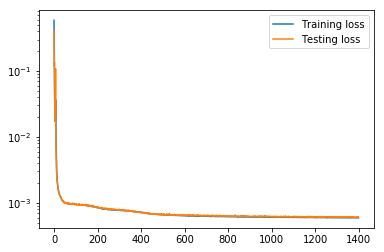

In [80]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.1010), tensor(1.2075), tensor(1.0936), tensor(1.1343), tensor(1.2266), tensor(1.1385), tensor(1.1423), tensor(1.1587), tensor(1.1968), tensor(1.1700), tensor(1.1293), tensor(1.0972), tensor(1.2019), tensor(1.2214), tensor(1.1748)]


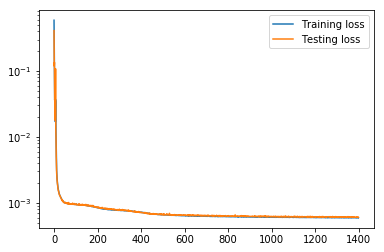

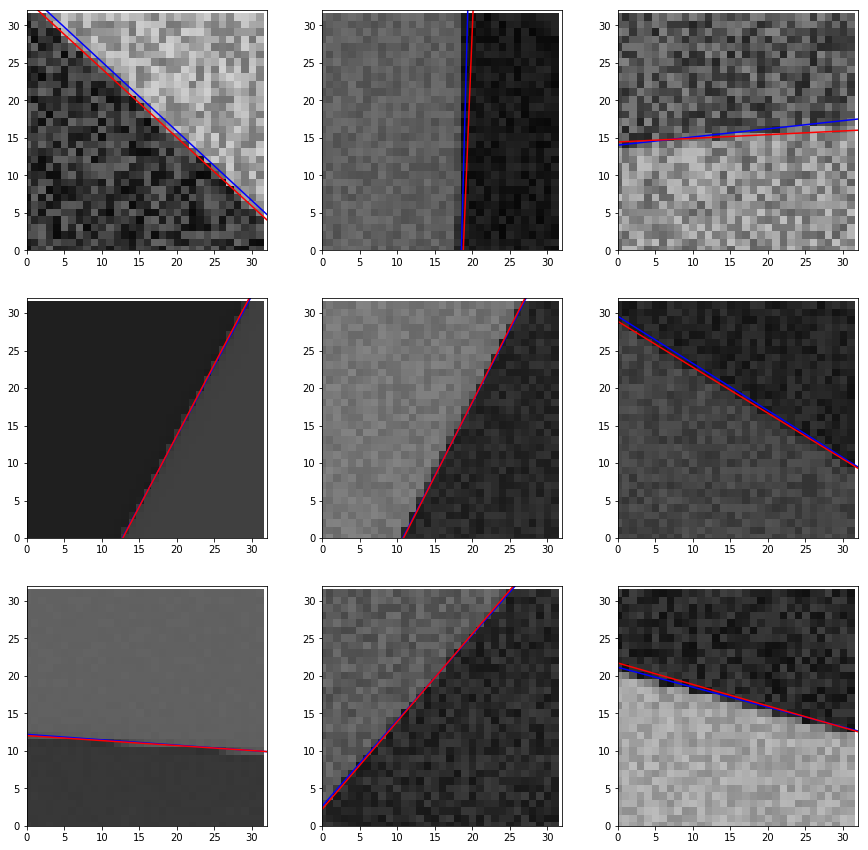

In [81]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')







# Test model on noiseless images

10000
[tensor(0.2775), tensor(0.2791), tensor(0.2962)]


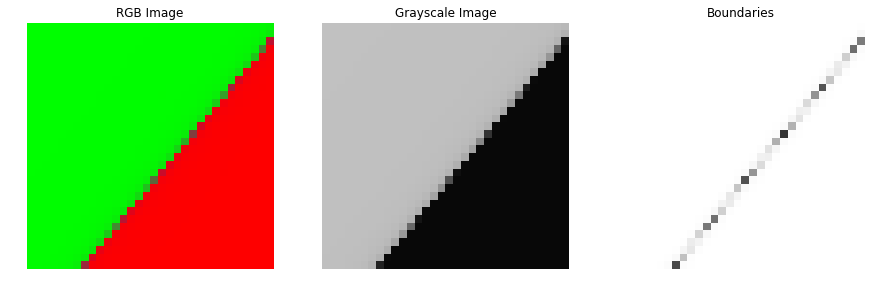

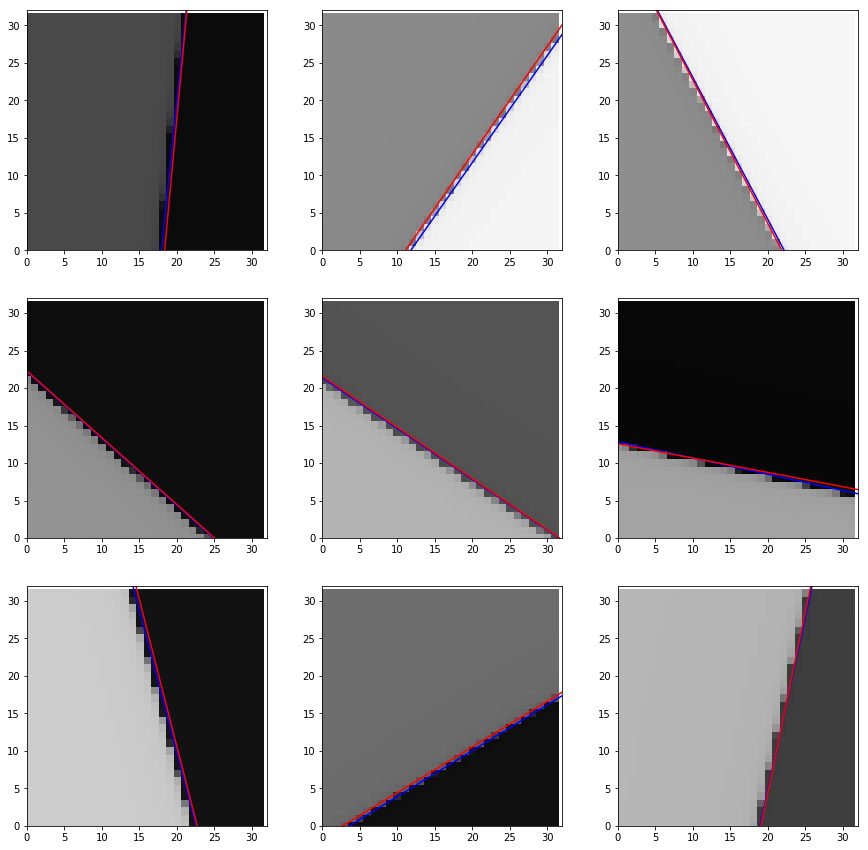

In [82]:
# Plot the Results

# line_data_32_10000_grey_multicolor_centered.pkl

# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_multicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset_TEST, test_dataset_TEST = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader_TEST = torch.utils.data.DataLoader(train_dataset_TEST, batch_size=500, shuffle=True)
test_loader_TEST = torch.utils.data.DataLoader(test_dataset_TEST, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');



W,H = 32,32

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader_TEST):
    # get the input images and their corresponding labels
    
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




# Try with fewer parameters

In [85]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(6, 6, kernel_size=3)
        self.conv3 = nn.Conv2d(6, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]              60
              ReLU-2            [-1, 6, 30, 30]               0
            Conv2d-3            [-1, 6, 28, 28]             330
              ReLU-4            [-1, 6, 28, 28]               0
            Conv2d-5            [-1, 1, 26, 26]              55
         MaxPool2d-6            [-1, 1, 13, 13]               0
         AvgPool2d-7              [-1, 1, 4, 4]               0
            Linear-8                    [-1, 3]              51
Total params: 496
Trainable params: 496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.00
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.4380338438028513, Avg. Test Loss: 0.46186989545822144
Epoch: 2, Avg. Train Loss: 0.4623845281989075, Avg. Test Loss: 0.4360150098800659
Epoch: 3, Avg. Train Loss: 0.3845756760863371, Avg. Test Loss: 0.3244640529155731
Epoch: 4, Avg. Train Loss: 0.20488615819188052, Avg. Test Loss: 0.10753218829631805
Epoch: 5, Avg. Train Loss: 0.07248324060509372, Avg. Test Loss: 0.05257531628012657
Epoch: 6, Avg. Train Loss: 0.04740591702419658, Avg. Test Loss: 0.039570797234773636
Epoch: 7, Avg. Train Loss: 0.034114989820261336, Avg. Test Loss: 0.029034240171313286
Epoch: 8, Avg. Train Loss: 0.026628364830516105, Avg. Test Loss: 0.023141905665397644
Epoch: 9, Avg. Train Loss: 0.02133292574868646, Avg. Test Loss: 0.018672028556466103
Epoch: 10, Avg. Train Loss: 0.017282886820477107, Avg. Test Loss: 0.015193881466984749
Epoch: 11, Avg. Train Loss: 0.008904635050702233, Avg. Test Loss: 0.004941968247294426
Epoch: 12, Avg. Train Loss: 0.004161383095738846, Avg. Test Loss: 0.0

Epoch: 94, Avg. Train Loss: 0.000922669859624706, Avg. Test Loss: 0.0009158579632639885
Epoch: 95, Avg. Train Loss: 0.000920372137929811, Avg. Test Loss: 0.0009067591745406389
Epoch: 96, Avg. Train Loss: 0.0009188245857394365, Avg. Test Loss: 0.0009037916315719485
Epoch: 97, Avg. Train Loss: 0.0009140321852227803, Avg. Test Loss: 0.0009062147582881153
Epoch: 98, Avg. Train Loss: 0.0009067696627489356, Avg. Test Loss: 0.0008999276324175298
Epoch: 99, Avg. Train Loss: 0.0009105210625674835, Avg. Test Loss: 0.0009052883251570165
Epoch: 100, Avg. Train Loss: 0.0009058730928552185, Avg. Test Loss: 0.0009173225262202322
Epoch: 101, Avg. Train Loss: 0.0009087959025596636, Avg. Test Loss: 0.0009042598539963365
Epoch: 102, Avg. Train Loss: 0.00090511089737722, Avg. Test Loss: 0.0009034608374349773
Epoch: 103, Avg. Train Loss: 0.0008996128521556424, Avg. Test Loss: 0.000899744569323957
Epoch: 104, Avg. Train Loss: 0.0009007426723296386, Avg. Test Loss: 0.0009026830084621906
Epoch: 105, Avg. Trai

Epoch: 186, Avg. Train Loss: 0.0008013054030016065, Avg. Test Loss: 0.0007964755641296506
Epoch: 187, Avg. Train Loss: 0.0008028348255361063, Avg. Test Loss: 0.0007943544187583029
Epoch: 188, Avg. Train Loss: 0.0008018290540095159, Avg. Test Loss: 0.0008122990257106721
Epoch: 189, Avg. Train Loss: 0.0008019146991373841, Avg. Test Loss: 0.0007943508680909872
Epoch: 190, Avg. Train Loss: 0.0007986320835148352, Avg. Test Loss: 0.0007949533173814416
Epoch: 191, Avg. Train Loss: 0.0007959383683344133, Avg. Test Loss: 0.0007938933558762074
Epoch: 192, Avg. Train Loss: 0.0007981293263498607, Avg. Test Loss: 0.0008034494239836931
Epoch: 193, Avg. Train Loss: 0.0007970345986270627, Avg. Test Loss: 0.000802711583673954
Epoch: 194, Avg. Train Loss: 0.0007951556228447792, Avg. Test Loss: 0.0007944146054796875
Epoch: 195, Avg. Train Loss: 0.0007930136093501608, Avg. Test Loss: 0.0008006936404854059
Epoch: 196, Avg. Train Loss: 0.0007903586279839104, Avg. Test Loss: 0.0007967617129907012
Epoch: 197,

Epoch: 278, Avg. Train Loss: 0.0007668417542739663, Avg. Test Loss: 0.0007696482352912426
Epoch: 279, Avg. Train Loss: 0.0007656944366063663, Avg. Test Loss: 0.0007693195366300642
Epoch: 280, Avg. Train Loss: 0.000763730970373767, Avg. Test Loss: 0.000770681828726083
Epoch: 281, Avg. Train Loss: 0.0007686807413932022, Avg. Test Loss: 0.000773285108152777
Epoch: 282, Avg. Train Loss: 0.0007648652590009882, Avg. Test Loss: 0.0007816946017555892
Epoch: 283, Avg. Train Loss: 0.0007683919000894178, Avg. Test Loss: 0.0007715199608355761
Epoch: 284, Avg. Train Loss: 0.0007648376888747132, Avg. Test Loss: 0.0007704123272560537
Epoch: 285, Avg. Train Loss: 0.0007649457371837004, Avg. Test Loss: 0.0007726651965640485
Epoch: 286, Avg. Train Loss: 0.0007634324598299383, Avg. Test Loss: 0.0007787088979966938
Epoch: 287, Avg. Train Loss: 0.0007694666368648583, Avg. Test Loss: 0.0007739405264146626
Epoch: 288, Avg. Train Loss: 0.0007678508084418989, Avg. Test Loss: 0.0007697755354456604
Epoch: 289, A

Epoch: 370, Avg. Train Loss: 0.0007559505784017749, Avg. Test Loss: 0.0007623245473951101
Epoch: 371, Avg. Train Loss: 0.0007550297169621255, Avg. Test Loss: 0.0007631063344888389
Epoch: 372, Avg. Train Loss: 0.0007568444490844254, Avg. Test Loss: 0.0007654320797882974
Epoch: 373, Avg. Train Loss: 0.0007527089369115095, Avg. Test Loss: 0.0007599340751767159
Epoch: 374, Avg. Train Loss: 0.0007592890815007998, Avg. Test Loss: 0.0007708191405981779
Epoch: 375, Avg. Train Loss: 0.000756374193452905, Avg. Test Loss: 0.0007590312161482871
Epoch: 376, Avg. Train Loss: 0.0007573645629616844, Avg. Test Loss: 0.0007715359679423273
Epoch: 377, Avg. Train Loss: 0.000755066781705462, Avg. Test Loss: 0.0007674742373637855
Epoch: 378, Avg. Train Loss: 0.0007544801730207752, Avg. Test Loss: 0.0007603983976878226
Epoch: 379, Avg. Train Loss: 0.000753365543692611, Avg. Test Loss: 0.0007639172836206853
Epoch: 380, Avg. Train Loss: 0.0007567673807877094, Avg. Test Loss: 0.0007667209138162434
Epoch: 381, A

Epoch: 462, Avg. Train Loss: 0.000745833006709121, Avg. Test Loss: 0.0007549371221102774
Epoch: 463, Avg. Train Loss: 0.0007465449391950875, Avg. Test Loss: 0.0007486079121008515
Epoch: 464, Avg. Train Loss: 0.0007464978708560731, Avg. Test Loss: 0.0007497751503251493
Epoch: 465, Avg. Train Loss: 0.0007410884799630662, Avg. Test Loss: 0.0007549377041868865
Epoch: 466, Avg. Train Loss: 0.0007443447667715507, Avg. Test Loss: 0.0007503853994421661
Epoch: 467, Avg. Train Loss: 0.0007431133539242626, Avg. Test Loss: 0.0007676243549212813
Epoch: 468, Avg. Train Loss: 0.0007462779514838097, Avg. Test Loss: 0.0007511883159168065
Epoch: 469, Avg. Train Loss: 0.0007417289199047657, Avg. Test Loss: 0.0007604155107401311
Epoch: 470, Avg. Train Loss: 0.0007513596359532067, Avg. Test Loss: 0.0007541375234723091
Epoch: 471, Avg. Train Loss: 0.0007467347273039957, Avg. Test Loss: 0.0007725434261374176
Epoch: 472, Avg. Train Loss: 0.0007428954352711349, Avg. Test Loss: 0.0007557787466794252
Epoch: 473,

Epoch: 554, Avg. Train Loss: 0.0007215792578536758, Avg. Test Loss: 0.0007336497656069696
Epoch: 555, Avg. Train Loss: 0.0007235612111101144, Avg. Test Loss: 0.0007377167348749936
Epoch: 556, Avg. Train Loss: 0.0007202135599326602, Avg. Test Loss: 0.0007281063590198755
Epoch: 557, Avg. Train Loss: 0.0007257133256644011, Avg. Test Loss: 0.0007336243870668113
Epoch: 558, Avg. Train Loss: 0.0007254971451191015, Avg. Test Loss: 0.0007274216623045504
Epoch: 559, Avg. Train Loss: 0.0007233481209855093, Avg. Test Loss: 0.0007312849629670382
Epoch: 560, Avg. Train Loss: 0.0007204939570646127, Avg. Test Loss: 0.0007334428955800831
Epoch: 561, Avg. Train Loss: 0.0007216883511932264, Avg. Test Loss: 0.0007430192199535668
Epoch: 562, Avg. Train Loss: 0.0007191876675067253, Avg. Test Loss: 0.0007296517724171281
Epoch: 563, Avg. Train Loss: 0.0007193037281679206, Avg. Test Loss: 0.0007283910526894033
Epoch: 564, Avg. Train Loss: 0.0007213307111415753, Avg. Test Loss: 0.000724349170923233
Epoch: 565,

Epoch: 646, Avg. Train Loss: 0.0006964906405787482, Avg. Test Loss: 0.0007052572327665985
Epoch: 647, Avg. Train Loss: 0.0006988835385675694, Avg. Test Loss: 0.000713869056198746
Epoch: 648, Avg. Train Loss: 0.000699484741131147, Avg. Test Loss: 0.0007008552784100175
Epoch: 649, Avg. Train Loss: 0.0006930961498319236, Avg. Test Loss: 0.0007041724165901542
Epoch: 650, Avg. Train Loss: 0.0006949499663680272, Avg. Test Loss: 0.0007000135956332088
Epoch: 651, Avg. Train Loss: 0.0006951537716938833, Avg. Test Loss: 0.0007096740300767124
Epoch: 652, Avg. Train Loss: 0.0006990187075855427, Avg. Test Loss: 0.00070749077713117
Epoch: 653, Avg. Train Loss: 0.0006958476530366339, Avg. Test Loss: 0.0007044766680337489
Epoch: 654, Avg. Train Loss: 0.0006950586725589494, Avg. Test Loss: 0.0007000694749876857
Epoch: 655, Avg. Train Loss: 0.0006959754554013354, Avg. Test Loss: 0.0007016373565420508
Epoch: 656, Avg. Train Loss: 0.0006990372541707096, Avg. Test Loss: 0.0007198502426035702
Epoch: 657, Av

Epoch: 738, Avg. Train Loss: 0.0006865705566502415, Avg. Test Loss: 0.0006929409573785961
Epoch: 739, Avg. Train Loss: 0.0006875379084132959, Avg. Test Loss: 0.0006981397746130824
Epoch: 740, Avg. Train Loss: 0.0006858262864244712, Avg. Test Loss: 0.0006966886576265097
Epoch: 741, Avg. Train Loss: 0.0006840634917797045, Avg. Test Loss: 0.0006932264659553766
Epoch: 742, Avg. Train Loss: 0.0006883196400066968, Avg. Test Loss: 0.0007058905903249979
Epoch: 743, Avg. Train Loss: 0.000683399843225299, Avg. Test Loss: 0.0006942551117390394
Epoch: 744, Avg. Train Loss: 0.0006836443884991282, Avg. Test Loss: 0.0007038100156933069
Epoch: 745, Avg. Train Loss: 0.0006861700310891624, Avg. Test Loss: 0.0006960500031709671
Epoch: 746, Avg. Train Loss: 0.0006844305628260901, Avg. Test Loss: 0.0007101149531081319
Epoch: 747, Avg. Train Loss: 0.0006923615569681969, Avg. Test Loss: 0.0007027154788374901
Epoch: 748, Avg. Train Loss: 0.000685908678691661, Avg. Test Loss: 0.000703975441865623
Epoch: 749, A

Epoch: 830, Avg. Train Loss: 0.000682907055814339, Avg. Test Loss: 0.0006986676598899066
Epoch: 831, Avg. Train Loss: 0.0006830358734289401, Avg. Test Loss: 0.0006888139760121703
Epoch: 832, Avg. Train Loss: 0.0006823252255725133, Avg. Test Loss: 0.0007023488869890571
Epoch: 833, Avg. Train Loss: 0.0006794886782678754, Avg. Test Loss: 0.0006881516892462969
Epoch: 834, Avg. Train Loss: 0.0006809695975768358, Avg. Test Loss: 0.0006868608761578798
Epoch: 835, Avg. Train Loss: 0.0006795213463023132, Avg. Test Loss: 0.0006958043086342514
Epoch: 836, Avg. Train Loss: 0.0006797907949793478, Avg. Test Loss: 0.0006899631698615849
Epoch: 837, Avg. Train Loss: 0.0006825283946750989, Avg. Test Loss: 0.0007040566997602582
Epoch: 838, Avg. Train Loss: 0.0006850784939583824, Avg. Test Loss: 0.0006943753105588257
Epoch: 839, Avg. Train Loss: 0.0006815114107286168, Avg. Test Loss: 0.0006943593616597354
Epoch: 840, Avg. Train Loss: 0.0006820108635935846, Avg. Test Loss: 0.0007048367406241596
Epoch: 841,

Epoch: 922, Avg. Train Loss: 0.0006764487669326712, Avg. Test Loss: 0.000687086780089885
Epoch: 923, Avg. Train Loss: 0.0006757818262612577, Avg. Test Loss: 0.0006910691736266017
Epoch: 924, Avg. Train Loss: 0.0006798792029406096, Avg. Test Loss: 0.0006958299200050533
Epoch: 925, Avg. Train Loss: 0.0006764702875232107, Avg. Test Loss: 0.0006850183708593249
Epoch: 926, Avg. Train Loss: 0.0006744003906131311, Avg. Test Loss: 0.0006865718169137836
Epoch: 927, Avg. Train Loss: 0.0006778986331313676, Avg. Test Loss: 0.0006931271636858582
Epoch: 928, Avg. Train Loss: 0.0006789888558519441, Avg. Test Loss: 0.00068558199563995
Epoch: 929, Avg. Train Loss: 0.0006788183331251317, Avg. Test Loss: 0.0006914437981322408
Epoch: 930, Avg. Train Loss: 0.0006778572962164532, Avg. Test Loss: 0.0006868295022286475
Epoch: 931, Avg. Train Loss: 0.0006812056431785053, Avg. Test Loss: 0.0006855746614746749
Epoch: 932, Avg. Train Loss: 0.000678621644024239, Avg. Test Loss: 0.0006924981717020273
Epoch: 933, Av

Epoch: 1014, Avg. Train Loss: 0.0006759388258594066, Avg. Test Loss: 0.0006885065231472254
Epoch: 1015, Avg. Train Loss: 0.0006778538524887936, Avg. Test Loss: 0.000696443603374064
Epoch: 1016, Avg. Train Loss: 0.0006780486478102068, Avg. Test Loss: 0.0006887831841595471
Epoch: 1017, Avg. Train Loss: 0.000679300055665852, Avg. Test Loss: 0.000686638813931495
Epoch: 1018, Avg. Train Loss: 0.0006754502266926994, Avg. Test Loss: 0.0006837655673734844
Epoch: 1019, Avg. Train Loss: 0.0006800725714974972, Avg. Test Loss: 0.00068989850115031
Epoch: 1020, Avg. Train Loss: 0.0006810942079958528, Avg. Test Loss: 0.0006859786808490753
Epoch: 1021, Avg. Train Loss: 0.0006781617534173609, Avg. Test Loss: 0.0006841380381956697
Epoch: 1022, Avg. Train Loss: 0.0006757435540473739, Avg. Test Loss: 0.0006870590150356293
Epoch: 1023, Avg. Train Loss: 0.000678685289363615, Avg. Test Loss: 0.0006876822444610298
Epoch: 1024, Avg. Train Loss: 0.0006756636877219345, Avg. Test Loss: 0.000685189210344106
Epoch:

Epoch: 1105, Avg. Train Loss: 0.0006731389602104766, Avg. Test Loss: 0.0006827915203757584
Epoch: 1106, Avg. Train Loss: 0.0006745424145984269, Avg. Test Loss: 0.0006804309086874127
Epoch: 1107, Avg. Train Loss: 0.000676048934448857, Avg. Test Loss: 0.0006933115073479712
Epoch: 1108, Avg. Train Loss: 0.0006754742082489958, Avg. Test Loss: 0.0006826083990745246
Epoch: 1109, Avg. Train Loss: 0.000672427378324142, Avg. Test Loss: 0.0006851678481325507
Epoch: 1110, Avg. Train Loss: 0.0006761697749065799, Avg. Test Loss: 0.0006921549211256206
Epoch: 1111, Avg. Train Loss: 0.0006762376003682094, Avg. Test Loss: 0.0006858971901237965
Epoch: 1112, Avg. Train Loss: 0.0006717646773363096, Avg. Test Loss: 0.0006851499201729894
Epoch: 1113, Avg. Train Loss: 0.0006754816886102564, Avg. Test Loss: 0.0006895103142596781
Epoch: 1114, Avg. Train Loss: 0.0006759924676031047, Avg. Test Loss: 0.0006863482994958758
Epoch: 1115, Avg. Train Loss: 0.0006734619815942159, Avg. Test Loss: 0.0006835097447037697
E

Epoch: 1196, Avg. Train Loss: 0.0006751330815753791, Avg. Test Loss: 0.0006904497276991606
Epoch: 1197, Avg. Train Loss: 0.0006719930828440675, Avg. Test Loss: 0.0006809270707890391
Epoch: 1198, Avg. Train Loss: 0.0006750468611392345, Avg. Test Loss: 0.0006937129073776305
Epoch: 1199, Avg. Train Loss: 0.0006750462140866317, Avg. Test Loss: 0.0006784397410228848
Epoch: 1200, Avg. Train Loss: 0.0006760131746400581, Avg. Test Loss: 0.0006902706227265298
Epoch: 1201, Avg. Train Loss: 0.0006733362232659791, Avg. Test Loss: 0.0006828199839219451
Epoch: 1202, Avg. Train Loss: 0.0006755574600944339, Avg. Test Loss: 0.000690606830175966
Epoch: 1203, Avg. Train Loss: 0.0006769697742298418, Avg. Test Loss: 0.0006938505684956908
Epoch: 1204, Avg. Train Loss: 0.000675943965731232, Avg. Test Loss: 0.0006851285579614341
Epoch: 1205, Avg. Train Loss: 0.0006742514236721882, Avg. Test Loss: 0.0006834003143012524
Epoch: 1206, Avg. Train Loss: 0.0006740026860931065, Avg. Test Loss: 0.0006916798884049058
E

Epoch: 1287, Avg. Train Loss: 0.0006746652002749575, Avg. Test Loss: 0.0006836612010374665
Epoch: 1288, Avg. Train Loss: 0.0006765152942280957, Avg. Test Loss: 0.0006846829201094806
Epoch: 1289, Avg. Train Loss: 0.0006760692177881854, Avg. Test Loss: 0.000688959495164454
Epoch: 1290, Avg. Train Loss: 0.0006709282955176436, Avg. Test Loss: 0.0006901298766024411
Epoch: 1291, Avg. Train Loss: 0.0006726156841681967, Avg. Test Loss: 0.000683993159327656
Epoch: 1292, Avg. Train Loss: 0.0006739310135111905, Avg. Test Loss: 0.0006792218191549182
Epoch: 1293, Avg. Train Loss: 0.0006730968517056385, Avg. Test Loss: 0.0006791131454519928
Epoch: 1294, Avg. Train Loss: 0.0006729567282681548, Avg. Test Loss: 0.000689918000716716
Epoch: 1295, Avg. Train Loss: 0.0006749753442289697, Avg. Test Loss: 0.0006795754306949675
Epoch: 1296, Avg. Train Loss: 0.0006758316696166645, Avg. Test Loss: 0.000688590866047889
Epoch: 1297, Avg. Train Loss: 0.0006739547798345082, Avg. Test Loss: 0.0006860257126390934
Epo

Epoch: 1378, Avg. Train Loss: 0.0006711344426866014, Avg. Test Loss: 0.0006890409276820719
Epoch: 1379, Avg. Train Loss: 0.0006746155843355281, Avg. Test Loss: 0.0006895710248500109
Epoch: 1380, Avg. Train Loss: 0.0006739757833244323, Avg. Test Loss: 0.0006932317046448588
Epoch: 1381, Avg. Train Loss: 0.0006715719233440279, Avg. Test Loss: 0.0006836901302449405
Epoch: 1382, Avg. Train Loss: 0.0006703079182676278, Avg. Test Loss: 0.0006799634429626167
Epoch: 1383, Avg. Train Loss: 0.0006716048986607686, Avg. Test Loss: 0.0006950451643206179
Epoch: 1384, Avg. Train Loss: 0.0006757634380550752, Avg. Test Loss: 0.0006890532677061856
Epoch: 1385, Avg. Train Loss: 0.0006733262616339638, Avg. Test Loss: 0.0006808307371102273
Epoch: 1386, Avg. Train Loss: 0.0006764969913029047, Avg. Test Loss: 0.0006837024120613933
Epoch: 1387, Avg. Train Loss: 0.0006732830959155636, Avg. Test Loss: 0.0006824450101703405
Epoch: 1388, Avg. Train Loss: 0.0006710925900247381, Avg. Test Loss: 0.0006815616507083178

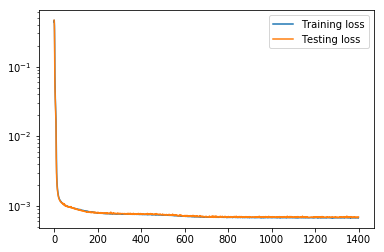

In [86]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.1565), tensor(1.2987), tensor(1.1643), tensor(1.2268), tensor(1.2621), tensor(1.2070), tensor(1.1655), tensor(1.2302), tensor(1.2653), tensor(1.2730), tensor(1.1705), tensor(1.1439), tensor(1.2535), tensor(1.2723), tensor(1.2136)]


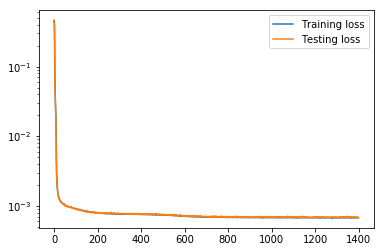

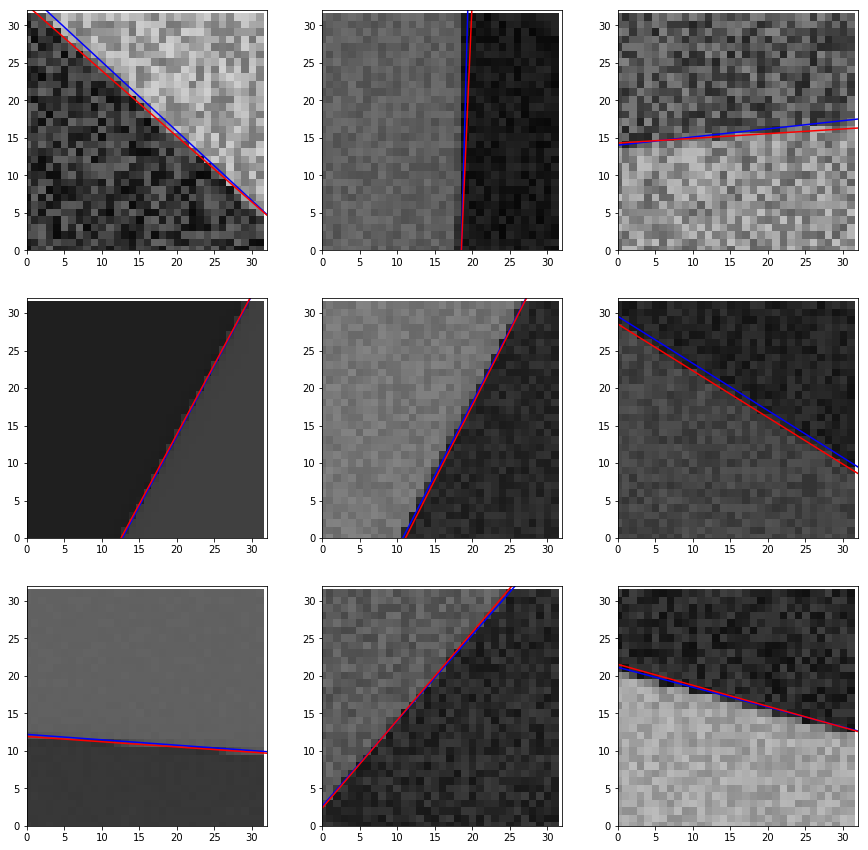

In [87]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')








# Add a 4th conv

In [88]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(3, 3, kernel_size=3)
        self.conv3 = nn.Conv2d(3, 3, kernel_size=3)
        self.conv4 = nn.Conv2d(3, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 30, 30]              30
              ReLU-2            [-1, 3, 30, 30]               0
            Conv2d-3            [-1, 3, 28, 28]              84
              ReLU-4            [-1, 3, 28, 28]               0
            Conv2d-5            [-1, 3, 26, 26]              84
              ReLU-6            [-1, 3, 26, 26]               0
            Conv2d-7            [-1, 1, 24, 24]              28
         MaxPool2d-8            [-1, 1, 12, 12]               0
         AvgPool2d-9              [-1, 1, 4, 4]               0
           Linear-10                    [-1, 3]              51
Total params: 277
Trainable params: 277
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.00
Estimated Total Siz

Epoch: 1, Avg. Train Loss: 0.48860722364381304, Avg. Test Loss: 0.3650892674922943
Epoch: 2, Avg. Train Loss: 0.4526286291521649, Avg. Test Loss: 0.5622403621673584
Epoch: 3, Avg. Train Loss: 0.5671967919482741, Avg. Test Loss: 0.571733832359314
Epoch: 4, Avg. Train Loss: 0.5633926807447921, Avg. Test Loss: 0.5638573169708252
Epoch: 5, Avg. Train Loss: 0.5554225112116614, Avg. Test Loss: 0.5555009245872498
Epoch: 6, Avg. Train Loss: 0.546770547711572, Avg. Test Loss: 0.5459396839141846
Epoch: 7, Avg. Train Loss: 0.5362871954607409, Avg. Test Loss: 0.5339404344558716
Epoch: 8, Avg. Train Loss: 0.522331411062285, Avg. Test Loss: 0.5181103944778442
Epoch: 9, Avg. Train Loss: 0.5042554895545162, Avg. Test Loss: 0.4955240786075592
Epoch: 10, Avg. Train Loss: 0.4780075660971708, Avg. Test Loss: 0.4650232195854187
Epoch: 11, Avg. Train Loss: 0.4080668611581935, Avg. Test Loss: 0.3393467962741852
Epoch: 12, Avg. Train Loss: 0.21765205073495245, Avg. Test Loss: 0.10269127786159515
Epoch: 13, Av

Epoch: 96, Avg. Train Loss: 0.0020299292017900666, Avg. Test Loss: 0.001980774337425828
Epoch: 97, Avg. Train Loss: 0.0020070910307600403, Avg. Test Loss: 0.0019613478798419237
Epoch: 98, Avg. Train Loss: 0.0019855789899782734, Avg. Test Loss: 0.001935137202963233
Epoch: 99, Avg. Train Loss: 0.001966135124242756, Avg. Test Loss: 0.001910857972688973
Epoch: 100, Avg. Train Loss: 0.0019476456448522417, Avg. Test Loss: 0.0018974359845742583
Epoch: 101, Avg. Train Loss: 0.0019263754230599071, Avg. Test Loss: 0.0018664906965568662
Epoch: 102, Avg. Train Loss: 0.0018994653391716785, Avg. Test Loss: 0.00184734002687037
Epoch: 103, Avg. Train Loss: 0.0018814318829627578, Avg. Test Loss: 0.0018282822566106915
Epoch: 104, Avg. Train Loss: 0.001863878187831751, Avg. Test Loss: 0.0018083908362314105
Epoch: 105, Avg. Train Loss: 0.001841659267801185, Avg. Test Loss: 0.0017870018491521478
Epoch: 106, Avg. Train Loss: 0.0018201404478574215, Avg. Test Loss: 0.001769229187630117
Epoch: 107, Avg. Train 

Epoch: 188, Avg. Train Loss: 0.0011156091796840693, Avg. Test Loss: 0.0010886897798627615
Epoch: 189, Avg. Train Loss: 0.0011121924712084407, Avg. Test Loss: 0.0010909371776506305
Epoch: 190, Avg. Train Loss: 0.0011073178990722396, Avg. Test Loss: 0.0010860987240448594
Epoch: 191, Avg. Train Loss: 0.001103605784010142, Avg. Test Loss: 0.0010698947589844465
Epoch: 192, Avg. Train Loss: 0.0010942821783490133, Avg. Test Loss: 0.0010623702546581626
Epoch: 193, Avg. Train Loss: 0.001086310670321244, Avg. Test Loss: 0.0010711507638916373
Epoch: 194, Avg. Train Loss: 0.0010821526575032188, Avg. Test Loss: 0.001047460245899856
Epoch: 195, Avg. Train Loss: 0.001071599844117584, Avg. Test Loss: 0.0010423185303807259
Epoch: 196, Avg. Train Loss: 0.0010620657582009255, Avg. Test Loss: 0.0010460350895300508
Epoch: 197, Avg. Train Loss: 0.0010547042745815286, Avg. Test Loss: 0.0010508697014302015
Epoch: 198, Avg. Train Loss: 0.0010554938019404923, Avg. Test Loss: 0.0010195905342698097
Epoch: 199, Av

Epoch: 280, Avg. Train Loss: 0.0009227033141393994, Avg. Test Loss: 0.0008870767778716981
Epoch: 281, Avg. Train Loss: 0.0009185365620502379, Avg. Test Loss: 0.0008973451913334429
Epoch: 282, Avg. Train Loss: 0.0009169430406980736, Avg. Test Loss: 0.0009257469791918993
Epoch: 283, Avg. Train Loss: 0.0009227320606018915, Avg. Test Loss: 0.0008946851594373584
Epoch: 284, Avg. Train Loss: 0.0009146420756181658, Avg. Test Loss: 0.0009113742271438241
Epoch: 285, Avg. Train Loss: 0.0009187980064970636, Avg. Test Loss: 0.0009003617451526225
Epoch: 286, Avg. Train Loss: 0.0009149429158220977, Avg. Test Loss: 0.0009001889848150313
Epoch: 287, Avg. Train Loss: 0.0009157863922070625, Avg. Test Loss: 0.0009318646625615656
Epoch: 288, Avg. Train Loss: 0.0009242632808055469, Avg. Test Loss: 0.0008977030520327389
Epoch: 289, Avg. Train Loss: 0.0009174554576274267, Avg. Test Loss: 0.0009015487739816308
Epoch: 290, Avg. Train Loss: 0.0009122005674641493, Avg. Test Loss: 0.0008862695540301502
Epoch: 291

Epoch: 372, Avg. Train Loss: 0.0008745370717004461, Avg. Test Loss: 0.0008699591271579266
Epoch: 373, Avg. Train Loss: 0.0008851094550431467, Avg. Test Loss: 0.0008574505336582661
Epoch: 374, Avg. Train Loss: 0.0008774751467023824, Avg. Test Loss: 0.0008765243110246956
Epoch: 375, Avg. Train Loss: 0.0008863492213666092, Avg. Test Loss: 0.0008877703221514821
Epoch: 376, Avg. Train Loss: 0.0008734740075915185, Avg. Test Loss: 0.0008739090408198535
Epoch: 377, Avg. Train Loss: 0.0008844313060128411, Avg. Test Loss: 0.0008735203300602734
Epoch: 378, Avg. Train Loss: 0.0008865173250913273, Avg. Test Loss: 0.0008689559763297439
Epoch: 379, Avg. Train Loss: 0.0008772106754571892, Avg. Test Loss: 0.0008695489377714694
Epoch: 380, Avg. Train Loss: 0.0008739061588638051, Avg. Test Loss: 0.0008607534691691399
Epoch: 381, Avg. Train Loss: 0.0008779538600424001, Avg. Test Loss: 0.0008761958451941609
Epoch: 382, Avg. Train Loss: 0.0008769774441282417, Avg. Test Loss: 0.0008639952284283936
Epoch: 383

Epoch: 464, Avg. Train Loss: 0.0008658432201374063, Avg. Test Loss: 0.0008696274016983807
Epoch: 465, Avg. Train Loss: 0.0008731721643206858, Avg. Test Loss: 0.0008531830972060561
Epoch: 466, Avg. Train Loss: 0.0008662521316626564, Avg. Test Loss: 0.0008527690079063177
Epoch: 467, Avg. Train Loss: 0.0008673393005115348, Avg. Test Loss: 0.0008596630650572479
Epoch: 468, Avg. Train Loss: 0.0008635799208287756, Avg. Test Loss: 0.000859262072481215
Epoch: 469, Avg. Train Loss: 0.0008622593906989624, Avg. Test Loss: 0.0008516791858710349
Epoch: 470, Avg. Train Loss: 0.0008672604792166588, Avg. Test Loss: 0.0008618850843049586
Epoch: 471, Avg. Train Loss: 0.0008658783166496039, Avg. Test Loss: 0.0008507855818606913
Epoch: 472, Avg. Train Loss: 0.0008659703050588452, Avg. Test Loss: 0.0008522510179318488
Epoch: 473, Avg. Train Loss: 0.0008681117608428521, Avg. Test Loss: 0.0008839307702146471
Epoch: 474, Avg. Train Loss: 0.0008715207358215783, Avg. Test Loss: 0.0008557140827178955
Epoch: 475,

Epoch: 556, Avg. Train Loss: 0.0008568579729018343, Avg. Test Loss: 0.0008701136102899909
Epoch: 557, Avg. Train Loss: 0.0008558374843126986, Avg. Test Loss: 0.0008511660853400826
Epoch: 558, Avg. Train Loss: 0.0008571625478717304, Avg. Test Loss: 0.0008519607363268733
Epoch: 559, Avg. Train Loss: 0.0008590642855567641, Avg. Test Loss: 0.0008533936343155801
Epoch: 560, Avg. Train Loss: 0.0008600006654295464, Avg. Test Loss: 0.0008464943966828287
Epoch: 561, Avg. Train Loss: 0.0008544522286176162, Avg. Test Loss: 0.0008460133685730398
Epoch: 562, Avg. Train Loss: 0.0008585437493355469, Avg. Test Loss: 0.0008468253072351217
Epoch: 563, Avg. Train Loss: 0.0008602612381151249, Avg. Test Loss: 0.00086200115038082
Epoch: 564, Avg. Train Loss: 0.0008524684695700227, Avg. Test Loss: 0.0008583403541706502
Epoch: 565, Avg. Train Loss: 0.0008565148021917531, Avg. Test Loss: 0.0008442106773145497
Epoch: 566, Avg. Train Loss: 0.0008517964702467759, Avg. Test Loss: 0.0008559832931496203
Epoch: 567, 

Epoch: 648, Avg. Train Loss: 0.000843716356199408, Avg. Test Loss: 0.0008409589063376188
Epoch: 649, Avg. Train Loss: 0.0008444067356068382, Avg. Test Loss: 0.0008392318850383162
Epoch: 650, Avg. Train Loss: 0.0008477430078634169, Avg. Test Loss: 0.0008542136638425291
Epoch: 651, Avg. Train Loss: 0.0008511451359968199, Avg. Test Loss: 0.0008427464636042714
Epoch: 652, Avg. Train Loss: 0.0008452246114503333, Avg. Test Loss: 0.0008506838930770755
Epoch: 653, Avg. Train Loss: 0.0008440688523182342, Avg. Test Loss: 0.0008526863530278206
Epoch: 654, Avg. Train Loss: 0.0008563708505853144, Avg. Test Loss: 0.0008456801879219711
Epoch: 655, Avg. Train Loss: 0.000851742259963134, Avg. Test Loss: 0.0008538794936612248
Epoch: 656, Avg. Train Loss: 0.0008497621300955151, Avg. Test Loss: 0.0008634799160063267
Epoch: 657, Avg. Train Loss: 0.0008500204895363125, Avg. Test Loss: 0.0008403118699789047
Epoch: 658, Avg. Train Loss: 0.0008507109758833987, Avg. Test Loss: 0.0008508998434990644
Epoch: 659, 

Epoch: 740, Avg. Train Loss: 0.0008377612156923427, Avg. Test Loss: 0.0008403398096561432
Epoch: 741, Avg. Train Loss: 0.0008439328765150073, Avg. Test Loss: 0.0008412890019826591
Epoch: 742, Avg. Train Loss: 0.0008465151551591102, Avg. Test Loss: 0.0008446697611361742
Epoch: 743, Avg. Train Loss: 0.0008450907175862339, Avg. Test Loss: 0.0008360658539459109
Epoch: 744, Avg. Train Loss: 0.0008391752598135797, Avg. Test Loss: 0.0008396154153160751
Epoch: 745, Avg. Train Loss: 0.000839657272038938, Avg. Test Loss: 0.0008361353538930416
Epoch: 746, Avg. Train Loss: 0.0008379589430554662, Avg. Test Loss: 0.0008398219360969961
Epoch: 747, Avg. Train Loss: 0.000842490509628903, Avg. Test Loss: 0.0008422164246439934
Epoch: 748, Avg. Train Loss: 0.0008457634289380769, Avg. Test Loss: 0.0008401532541029155
Epoch: 749, Avg. Train Loss: 0.0008397149355259052, Avg. Test Loss: 0.0008403916144743562
Epoch: 750, Avg. Train Loss: 0.0008384568270209223, Avg. Test Loss: 0.0008385458495467901
Epoch: 751, 

Epoch: 832, Avg. Train Loss: 0.0008339058583450698, Avg. Test Loss: 0.0008455424685962498
Epoch: 833, Avg. Train Loss: 0.0008463020880468363, Avg. Test Loss: 0.0008285173680633307
Epoch: 834, Avg. Train Loss: 0.000837112361359475, Avg. Test Loss: 0.0008357389597222209
Epoch: 835, Avg. Train Loss: 0.0008411455945501668, Avg. Test Loss: 0.0008588164928369224
Epoch: 836, Avg. Train Loss: 0.0008384505825572063, Avg. Test Loss: 0.0008337546605616808
Epoch: 837, Avg. Train Loss: 0.0008346077371496967, Avg. Test Loss: 0.0008326038368977606
Epoch: 838, Avg. Train Loss: 0.0008378350162380483, Avg. Test Loss: 0.0008382641244679689
Epoch: 839, Avg. Train Loss: 0.0008431228735960673, Avg. Test Loss: 0.0008367925765924156
Epoch: 840, Avg. Train Loss: 0.0008370497231479994, Avg. Test Loss: 0.0008312694262713194
Epoch: 841, Avg. Train Loss: 0.0008398243510380907, Avg. Test Loss: 0.0008353330777026713
Epoch: 842, Avg. Train Loss: 0.0008381442004424888, Avg. Test Loss: 0.0008341085049323738
Epoch: 843,

Epoch: 924, Avg. Train Loss: 0.0008321025092046448, Avg. Test Loss: 0.0008258384186774492
Epoch: 925, Avg. Train Loss: 0.0008335848458024651, Avg. Test Loss: 0.0008351707365363836
Epoch: 926, Avg. Train Loss: 0.0008385729066334492, Avg. Test Loss: 0.0008313779253512621
Epoch: 927, Avg. Train Loss: 0.0008309346279887439, Avg. Test Loss: 0.0008363221422769129
Epoch: 928, Avg. Train Loss: 0.0008303739176521641, Avg. Test Loss: 0.0008336702012456954
Epoch: 929, Avg. Train Loss: 0.0008353225380550464, Avg. Test Loss: 0.0008387133711948991
Epoch: 930, Avg. Train Loss: 0.0008406754634559674, Avg. Test Loss: 0.0008581167785450816
Epoch: 931, Avg. Train Loss: 0.0008337356225955625, Avg. Test Loss: 0.0008321076165884733
Epoch: 932, Avg. Train Loss: 0.0008295034735225314, Avg. Test Loss: 0.0008293522405438125
Epoch: 933, Avg. Train Loss: 0.000839818844322635, Avg. Test Loss: 0.0008368325652554631
Epoch: 934, Avg. Train Loss: 0.0008370839668502814, Avg. Test Loss: 0.0008445785497315228
Epoch: 935,

Epoch: 1016, Avg. Train Loss: 0.0008308819933729463, Avg. Test Loss: 0.0008304263465106487
Epoch: 1017, Avg. Train Loss: 0.0008336821026818524, Avg. Test Loss: 0.000828764692414552
Epoch: 1018, Avg. Train Loss: 0.0008344553522007584, Avg. Test Loss: 0.000826678704470396
Epoch: 1019, Avg. Train Loss: 0.0008293090734717458, Avg. Test Loss: 0.0008311753626912832
Epoch: 1020, Avg. Train Loss: 0.0008298759632960482, Avg. Test Loss: 0.0008367892005480826
Epoch: 1021, Avg. Train Loss: 0.0008361212283827711, Avg. Test Loss: 0.0008319601183757186
Epoch: 1022, Avg. Train Loss: 0.0008310598597406994, Avg. Test Loss: 0.0008255001739598811
Epoch: 1023, Avg. Train Loss: 0.0008315678231071594, Avg. Test Loss: 0.0008355529862456024
Epoch: 1024, Avg. Train Loss: 0.0008282726332761867, Avg. Test Loss: 0.0008297397871501744
Epoch: 1025, Avg. Train Loss: 0.0008289769324365744, Avg. Test Loss: 0.0008303755894303322
Epoch: 1026, Avg. Train Loss: 0.000827693564514088, Avg. Test Loss: 0.0008320670458488166
Ep

Epoch: 1107, Avg. Train Loss: 0.0008277190919575649, Avg. Test Loss: 0.0008290552068501711
Epoch: 1108, Avg. Train Loss: 0.0008298403632199002, Avg. Test Loss: 0.0008289064862765372
Epoch: 1109, Avg. Train Loss: 0.0008323873626068234, Avg. Test Loss: 0.0008253827109001577
Epoch: 1110, Avg. Train Loss: 0.0008313913266499375, Avg. Test Loss: 0.0008262991905212402
Epoch: 1111, Avg. Train Loss: 0.0008340665101355245, Avg. Test Loss: 0.0008376724435947835
Epoch: 1112, Avg. Train Loss: 0.0008285953379019575, Avg. Test Loss: 0.0008304037619382143
Epoch: 1113, Avg. Train Loss: 0.0008247056028394159, Avg. Test Loss: 0.0008222112082876265
Epoch: 1114, Avg. Train Loss: 0.000829047458462937, Avg. Test Loss: 0.0008290099794976413
Epoch: 1115, Avg. Train Loss: 0.0008293844754049598, Avg. Test Loss: 0.000837741419672966
Epoch: 1116, Avg. Train Loss: 0.0008311914036396977, Avg. Test Loss: 0.0008245749049820006
Epoch: 1117, Avg. Train Loss: 0.0008276703897430453, Avg. Test Loss: 0.0008321814239025116
E

Epoch: 1198, Avg. Train Loss: 0.0008235229612436405, Avg. Test Loss: 0.0008231433457694948
Epoch: 1199, Avg. Train Loss: 0.0008245744190157153, Avg. Test Loss: 0.0008266534423455596
Epoch: 1200, Avg. Train Loss: 0.0008283459844046034, Avg. Test Loss: 0.0008319210610352457
Epoch: 1201, Avg. Train Loss: 0.0008278160848719783, Avg. Test Loss: 0.0008223929326049984
Epoch: 1202, Avg. Train Loss: 0.0008263426662292765, Avg. Test Loss: 0.0008266791701316833
Epoch: 1203, Avg. Train Loss: 0.0008276825077658475, Avg. Test Loss: 0.0008292461861856282
Epoch: 1204, Avg. Train Loss: 0.0008253878426499838, Avg. Test Loss: 0.0008237473666667938
Epoch: 1205, Avg. Train Loss: 0.0008288145804409544, Avg. Test Loss: 0.0008250940009020269
Epoch: 1206, Avg. Train Loss: 0.0008206635369745971, Avg. Test Loss: 0.000823811162263155
Epoch: 1207, Avg. Train Loss: 0.0008248235924754205, Avg. Test Loss: 0.0008247748482972383
Epoch: 1208, Avg. Train Loss: 0.0008235010210164758, Avg. Test Loss: 0.0008229672093875706


Epoch: 1289, Avg. Train Loss: 0.0008214052988562819, Avg. Test Loss: 0.0008266220684163272
Epoch: 1290, Avg. Train Loss: 0.0008215788822231251, Avg. Test Loss: 0.0008413493633270264
Epoch: 1291, Avg. Train Loss: 0.0008298988010041243, Avg. Test Loss: 0.0008320534252561629
Epoch: 1292, Avg. Train Loss: 0.000823034864287217, Avg. Test Loss: 0.0008245109347626567
Epoch: 1293, Avg. Train Loss: 0.0008227200799643301, Avg. Test Loss: 0.0008236031862907112
Epoch: 1294, Avg. Train Loss: 0.0008256550144599101, Avg. Test Loss: 0.0008228872902691364
Epoch: 1295, Avg. Train Loss: 0.0008245794641308833, Avg. Test Loss: 0.0008395981276407838
Epoch: 1296, Avg. Train Loss: 0.0008228087952078948, Avg. Test Loss: 0.0008223982877098024
Epoch: 1297, Avg. Train Loss: 0.0008247815678979075, Avg. Test Loss: 0.0008237476577050984
Epoch: 1298, Avg. Train Loss: 0.0008227064580180098, Avg. Test Loss: 0.0008259187452495098
Epoch: 1299, Avg. Train Loss: 0.0008213299091060668, Avg. Test Loss: 0.0008226056233979762


Epoch: 1380, Avg. Train Loss: 0.0008222512944146644, Avg. Test Loss: 0.0008271333645097911
Epoch: 1381, Avg. Train Loss: 0.0008225382987929638, Avg. Test Loss: 0.0008255366701632738
Epoch: 1382, Avg. Train Loss: 0.0008218989147111601, Avg. Test Loss: 0.0008225021883845329
Epoch: 1383, Avg. Train Loss: 0.0008203577518268207, Avg. Test Loss: 0.0008294399012811482
Epoch: 1384, Avg. Train Loss: 0.0008227891128965069, Avg. Test Loss: 0.0008218577713705599
Epoch: 1385, Avg. Train Loss: 0.0008252133157775673, Avg. Test Loss: 0.0008228363003581762
Epoch: 1386, Avg. Train Loss: 0.0008209908183469156, Avg. Test Loss: 0.0008207159698940814
Epoch: 1387, Avg. Train Loss: 0.0008217181244236959, Avg. Test Loss: 0.000821550318505615
Epoch: 1388, Avg. Train Loss: 0.0008251506491390944, Avg. Test Loss: 0.0008296825690194964
Epoch: 1389, Avg. Train Loss: 0.0008223068028645114, Avg. Test Loss: 0.000823120353743434
Epoch: 1390, Avg. Train Loss: 0.0008248430365414987, Avg. Test Loss: 0.0008413086179643869
E

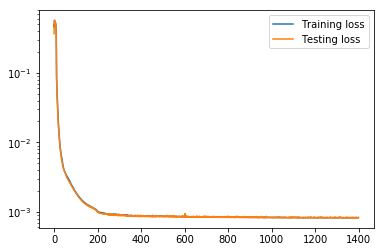

In [89]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.2547), tensor(1.3857), tensor(1.2240), tensor(1.3463), tensor(1.3928), tensor(1.2278), tensor(1.2917), tensor(1.2639), tensor(1.3426), tensor(1.3508), tensor(1.2611), tensor(1.3024), tensor(1.3580), tensor(1.4252), tensor(1.3007)]


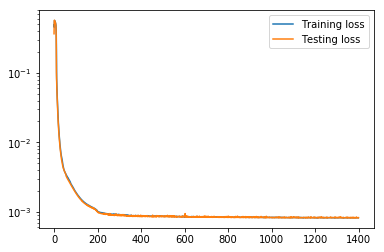

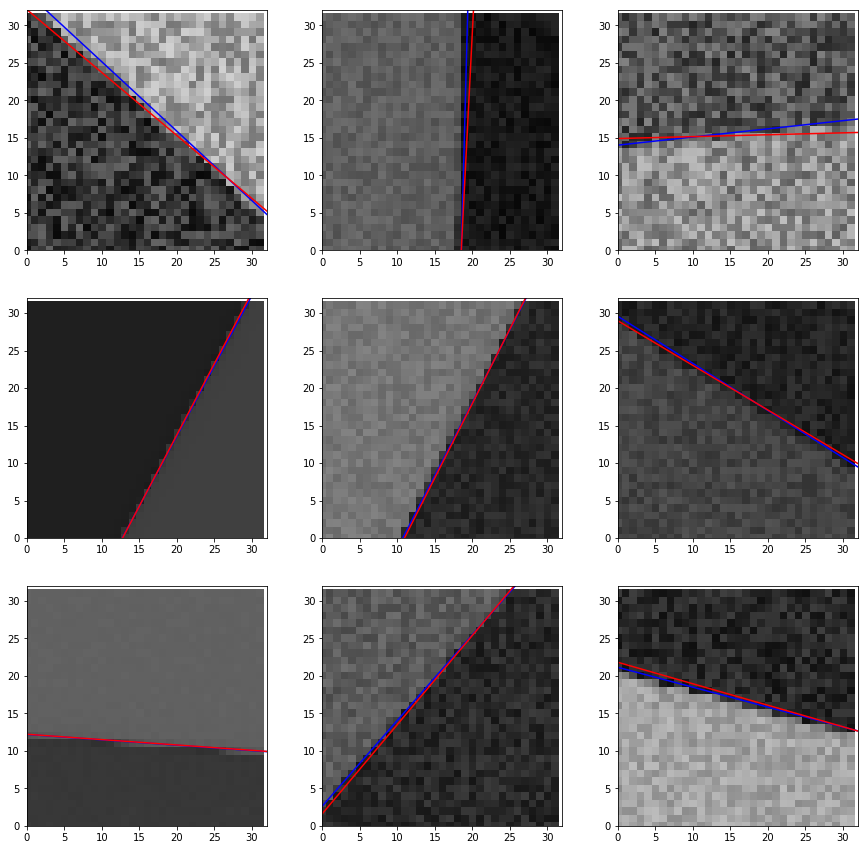

In [90]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')









In [91]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(6, 6, kernel_size=3)
        self.conv3 = nn.Conv2d(6, 6, kernel_size=3)
        self.conv4 = nn.Conv2d(6, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]              60
              ReLU-2            [-1, 6, 30, 30]               0
            Conv2d-3            [-1, 6, 28, 28]             330
              ReLU-4            [-1, 6, 28, 28]               0
            Conv2d-5            [-1, 6, 26, 26]             330
              ReLU-6            [-1, 6, 26, 26]               0
            Conv2d-7            [-1, 1, 24, 24]              55
         MaxPool2d-8            [-1, 1, 12, 12]               0
         AvgPool2d-9              [-1, 1, 4, 4]               0
           Linear-10                    [-1, 3]              51
Total params: 826
Trainable params: 826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.00
Estimated Total Siz

Epoch: 1, Avg. Train Loss: 0.5541668312494145, Avg. Test Loss: 0.4017559885978699
Epoch: 2, Avg. Train Loss: 0.302833941093711, Avg. Test Loss: 0.38142117857933044
Epoch: 3, Avg. Train Loss: 0.337245017636654, Avg. Test Loss: 0.2539917528629303
Epoch: 4, Avg. Train Loss: 0.16416883330012477, Avg. Test Loss: 0.10073535144329071
Epoch: 5, Avg. Train Loss: 0.08178041095650473, Avg. Test Loss: 0.06570802628993988
Epoch: 6, Avg. Train Loss: 0.058254623049220376, Avg. Test Loss: 0.06124342978000641
Epoch: 7, Avg. Train Loss: 0.04360841543868531, Avg. Test Loss: 0.03475022315979004
Epoch: 8, Avg. Train Loss: 0.030643617474409038, Avg. Test Loss: 0.027179254218935966
Epoch: 9, Avg. Train Loss: 0.024322324280822, Avg. Test Loss: 0.021768298000097275
Epoch: 10, Avg. Train Loss: 0.019628552763268005, Avg. Test Loss: 0.017673145979642868
Epoch: 11, Avg. Train Loss: 0.013505405313227066, Avg. Test Loss: 0.01029119547456503
Epoch: 12, Avg. Train Loss: 0.008588198821471875, Avg. Test Loss: 0.00719984

Epoch: 95, Avg. Train Loss: 0.0008996448352348146, Avg. Test Loss: 0.0008644259069114923
Epoch: 96, Avg. Train Loss: 0.0008968303892436589, Avg. Test Loss: 0.0008774291491135955
Epoch: 97, Avg. Train Loss: 0.0008989923070509766, Avg. Test Loss: 0.0008705993532203138
Epoch: 98, Avg. Train Loss: 0.0008958377834777673, Avg. Test Loss: 0.0008697525481693447
Epoch: 99, Avg. Train Loss: 0.0009011957228595261, Avg. Test Loss: 0.0008831475861370564
Epoch: 100, Avg. Train Loss: 0.000893693057235417, Avg. Test Loss: 0.0008687229710631073
Epoch: 101, Avg. Train Loss: 0.0008967125634013047, Avg. Test Loss: 0.0008653824334032834
Epoch: 102, Avg. Train Loss: 0.0008901136421035369, Avg. Test Loss: 0.0008783791563473642
Epoch: 103, Avg. Train Loss: 0.0008940831270761961, Avg. Test Loss: 0.0008644221816211939
Epoch: 104, Avg. Train Loss: 0.0008903020765459121, Avg. Test Loss: 0.0008611777448095381
Epoch: 105, Avg. Train Loss: 0.0008917125280361709, Avg. Test Loss: 0.0008589763892814517
Epoch: 106, Avg.

Epoch: 187, Avg. Train Loss: 0.000862119770825429, Avg. Test Loss: 0.0008460167446173728
Epoch: 188, Avg. Train Loss: 0.000858904376929236, Avg. Test Loss: 0.0008455435745418072
Epoch: 189, Avg. Train Loss: 0.0008592528932684556, Avg. Test Loss: 0.0008537938701920211
Epoch: 190, Avg. Train Loss: 0.0008628813178971583, Avg. Test Loss: 0.0008632690296508372
Epoch: 191, Avg. Train Loss: 0.0008591327391196649, Avg. Test Loss: 0.0008416143245995045
Epoch: 192, Avg. Train Loss: 0.0008585146739320873, Avg. Test Loss: 0.0008400585502386093
Epoch: 193, Avg. Train Loss: 0.0008535906049791117, Avg. Test Loss: 0.0008474045898765326
Epoch: 194, Avg. Train Loss: 0.0008623627864560762, Avg. Test Loss: 0.0008491695625707507
Epoch: 195, Avg. Train Loss: 0.0008557892667107977, Avg. Test Loss: 0.0008578310953453183
Epoch: 196, Avg. Train Loss: 0.0008627673391750905, Avg. Test Loss: 0.0008440917008556426
Epoch: 197, Avg. Train Loss: 0.0008536582855984222, Avg. Test Loss: 0.0008460723329335451
Epoch: 198, 

Epoch: 279, Avg. Train Loss: 0.0008551454236514347, Avg. Test Loss: 0.0008394225733354688
Epoch: 280, Avg. Train Loss: 0.0008518130973327991, Avg. Test Loss: 0.0008458434604108334
Epoch: 281, Avg. Train Loss: 0.0008464961957056509, Avg. Test Loss: 0.0008371862932108343
Epoch: 282, Avg. Train Loss: 0.0008480468978780474, Avg. Test Loss: 0.0008474822388961911
Epoch: 283, Avg. Train Loss: 0.0008434597971350994, Avg. Test Loss: 0.0008308779797516763
Epoch: 284, Avg. Train Loss: 0.0008464793060083202, Avg. Test Loss: 0.0008350007119588554
Epoch: 285, Avg. Train Loss: 0.0008438768550255444, Avg. Test Loss: 0.0008387152920477092
Epoch: 286, Avg. Train Loss: 0.0008445541701972658, Avg. Test Loss: 0.0008556798566132784
Epoch: 287, Avg. Train Loss: 0.0008565948485548413, Avg. Test Loss: 0.0008338841143995523
Epoch: 288, Avg. Train Loss: 0.0008437284322585477, Avg. Test Loss: 0.0008424420957453549
Epoch: 289, Avg. Train Loss: 0.0008459319198114234, Avg. Test Loss: 0.000846543931402266
Epoch: 290,

Epoch: 371, Avg. Train Loss: 0.0008328806089107381, Avg. Test Loss: 0.0008305797819048166
Epoch: 372, Avg. Train Loss: 0.0008378719564440638, Avg. Test Loss: 0.0008264585630968213
Epoch: 373, Avg. Train Loss: 0.0008423047283729322, Avg. Test Loss: 0.000824163609649986
Epoch: 374, Avg. Train Loss: 0.0008371281640625797, Avg. Test Loss: 0.0008333246223628521
Epoch: 375, Avg. Train Loss: 0.0008401956238653944, Avg. Test Loss: 0.000829061958938837
Epoch: 376, Avg. Train Loss: 0.0008431897812717875, Avg. Test Loss: 0.0008247962687164545
Epoch: 377, Avg. Train Loss: 0.0008338651684827583, Avg. Test Loss: 0.0008283142815344036
Epoch: 378, Avg. Train Loss: 0.0008403261078434974, Avg. Test Loss: 0.0008233353728428483
Epoch: 379, Avg. Train Loss: 0.0008317338191730858, Avg. Test Loss: 0.0008252375992015004
Epoch: 380, Avg. Train Loss: 0.000833049715702357, Avg. Test Loss: 0.0008217162103392184
Epoch: 381, Avg. Train Loss: 0.0008363055517398861, Avg. Test Loss: 0.0008251402177847922
Epoch: 382, A

Epoch: 463, Avg. Train Loss: 0.0008320608663610941, Avg. Test Loss: 0.0008266762597486377
Epoch: 464, Avg. Train Loss: 0.0008304296900669849, Avg. Test Loss: 0.0008197256247512996
Epoch: 465, Avg. Train Loss: 0.0008324658495460659, Avg. Test Loss: 0.0008178642601706088
Epoch: 466, Avg. Train Loss: 0.0008335276533914513, Avg. Test Loss: 0.0008261725888587534
Epoch: 467, Avg. Train Loss: 0.0008370822057301222, Avg. Test Loss: 0.0008183157769963145
Epoch: 468, Avg. Train Loss: 0.0008308105698656724, Avg. Test Loss: 0.0008197155548259616
Epoch: 469, Avg. Train Loss: 0.0008341142837348026, Avg. Test Loss: 0.0008293319842778146
Epoch: 470, Avg. Train Loss: 0.0008310889744004885, Avg. Test Loss: 0.000817755120806396
Epoch: 471, Avg. Train Loss: 0.0008325756643898785, Avg. Test Loss: 0.0008214670233428478
Epoch: 472, Avg. Train Loss: 0.0008298925051010798, Avg. Test Loss: 0.0008226765203289688
Epoch: 473, Avg. Train Loss: 0.0008339845510416253, Avg. Test Loss: 0.0008313136058859527
Epoch: 474,

Epoch: 555, Avg. Train Loss: 0.0008203544556488131, Avg. Test Loss: 0.0008113482035696507
Epoch: 556, Avg. Train Loss: 0.0008168123137249156, Avg. Test Loss: 0.0008098410326056182
Epoch: 557, Avg. Train Loss: 0.0008180836719179223, Avg. Test Loss: 0.0008134660311043262
Epoch: 558, Avg. Train Loss: 0.0008222843022194019, Avg. Test Loss: 0.0008083536522462964
Epoch: 559, Avg. Train Loss: 0.0008174671864591886, Avg. Test Loss: 0.0008112714858725667
Epoch: 560, Avg. Train Loss: 0.0008212431864596383, Avg. Test Loss: 0.0008094615186564624
Epoch: 561, Avg. Train Loss: 0.0008258466286649711, Avg. Test Loss: 0.0008070236071944237
Epoch: 562, Avg. Train Loss: 0.000819010597783639, Avg. Test Loss: 0.0008094633813016117
Epoch: 563, Avg. Train Loss: 0.0008179626581908832, Avg. Test Loss: 0.0008074338547885418
Epoch: 564, Avg. Train Loss: 0.0008149236754709205, Avg. Test Loss: 0.0008061604457907379
Epoch: 565, Avg. Train Loss: 0.0008161895242411384, Avg. Test Loss: 0.0008136312826536596
Epoch: 566,

Epoch: 647, Avg. Train Loss: 0.0007936670079415794, Avg. Test Loss: 0.0008060167310759425
Epoch: 648, Avg. Train Loss: 0.0007965415675561269, Avg. Test Loss: 0.0007863776409067214
Epoch: 649, Avg. Train Loss: 0.0007959339459058504, Avg. Test Loss: 0.0007915755268186331
Epoch: 650, Avg. Train Loss: 0.0007981096196724752, Avg. Test Loss: 0.0008027187432162464
Epoch: 651, Avg. Train Loss: 0.0007986167789610147, Avg. Test Loss: 0.0007995804189704359
Epoch: 652, Avg. Train Loss: 0.0007950793383209858, Avg. Test Loss: 0.000786074495408684
Epoch: 653, Avg. Train Loss: 0.0007940951645439274, Avg. Test Loss: 0.0007956690387800336
Epoch: 654, Avg. Train Loss: 0.0007917967118691047, Avg. Test Loss: 0.000794115592725575
Epoch: 655, Avg. Train Loss: 0.0007923768378447655, Avg. Test Loss: 0.0007922010845504701
Epoch: 656, Avg. Train Loss: 0.0007933434572742256, Avg. Test Loss: 0.0007883502403274179
Epoch: 657, Avg. Train Loss: 0.0007946375137476554, Avg. Test Loss: 0.0008075006771832705
Epoch: 658, 

Epoch: 739, Avg. Train Loss: 0.0007844847562008126, Avg. Test Loss: 0.0007892484427429736
Epoch: 740, Avg. Train Loss: 0.000787315622167012, Avg. Test Loss: 0.0007939914939925075
Epoch: 741, Avg. Train Loss: 0.000786152076745016, Avg. Test Loss: 0.0007833423442207277
Epoch: 742, Avg. Train Loss: 0.0007858760032239695, Avg. Test Loss: 0.0008064124267548323
Epoch: 743, Avg. Train Loss: 0.0007896900087659962, Avg. Test Loss: 0.0007807366200722754
Epoch: 744, Avg. Train Loss: 0.0007853805761632704, Avg. Test Loss: 0.0007828972302377224
Epoch: 745, Avg. Train Loss: 0.0007835275731807531, Avg. Test Loss: 0.0007887150277383626
Epoch: 746, Avg. Train Loss: 0.000785543552199162, Avg. Test Loss: 0.0007884458755142987
Epoch: 747, Avg. Train Loss: 0.0007902845919002281, Avg. Test Loss: 0.000781921437010169
Epoch: 748, Avg. Train Loss: 0.0007825354357834819, Avg. Test Loss: 0.0007856125012040138
Epoch: 749, Avg. Train Loss: 0.0007865153426347776, Avg. Test Loss: 0.0007775795529596508
Epoch: 750, Av

Epoch: 831, Avg. Train Loss: 0.0007797687390256067, Avg. Test Loss: 0.0007794270059093833
Epoch: 832, Avg. Train Loss: 0.0007811456872691768, Avg. Test Loss: 0.0007857280434109271
Epoch: 833, Avg. Train Loss: 0.0007752235044811874, Avg. Test Loss: 0.0007868492393754423
Epoch: 834, Avg. Train Loss: 0.0007769300962451759, Avg. Test Loss: 0.0007850300753489137
Epoch: 835, Avg. Train Loss: 0.0007810201915522474, Avg. Test Loss: 0.0007932517910376191
Epoch: 836, Avg. Train Loss: 0.000782267335358314, Avg. Test Loss: 0.0007875773590058088
Epoch: 837, Avg. Train Loss: 0.0007816414148438463, Avg. Test Loss: 0.0007881403435021639
Epoch: 838, Avg. Train Loss: 0.0007777747462590247, Avg. Test Loss: 0.0007805108325555921
Epoch: 839, Avg. Train Loss: 0.0007790355526214076, Avg. Test Loss: 0.0007847113301977515
Epoch: 840, Avg. Train Loss: 0.0007778771430102372, Avg. Test Loss: 0.0007924835663288832
Epoch: 841, Avg. Train Loss: 0.0007793919500071815, Avg. Test Loss: 0.0007862061611376703
Epoch: 842,

Epoch: 923, Avg. Train Loss: 0.0007709447283644316, Avg. Test Loss: 0.000775037391576916
Epoch: 924, Avg. Train Loss: 0.0007716188136878056, Avg. Test Loss: 0.0007766899652779102
Epoch: 925, Avg. Train Loss: 0.0007711418127359519, Avg. Test Loss: 0.0007802908658050001
Epoch: 926, Avg. Train Loss: 0.0007737391603958988, Avg. Test Loss: 0.0007727001793682575
Epoch: 927, Avg. Train Loss: 0.0007704770663579882, Avg. Test Loss: 0.0007764042820781469
Epoch: 928, Avg. Train Loss: 0.0007749512672510951, Avg. Test Loss: 0.0007820632308721542
Epoch: 929, Avg. Train Loss: 0.0007712968265052971, Avg. Test Loss: 0.0007797327707521617
Epoch: 930, Avg. Train Loss: 0.0007719858089288653, Avg. Test Loss: 0.000777366803959012
Epoch: 931, Avg. Train Loss: 0.0007731573423370719, Avg. Test Loss: 0.0007770030642859638
Epoch: 932, Avg. Train Loss: 0.0007747004382572201, Avg. Test Loss: 0.0007734075770713389
Epoch: 933, Avg. Train Loss: 0.0007731613830316725, Avg. Test Loss: 0.000778059707954526
Epoch: 934, A

Epoch: 1015, Avg. Train Loss: 0.0007625172973263922, Avg. Test Loss: 0.0007662450079806149
Epoch: 1016, Avg. Train Loss: 0.0007607693564644906, Avg. Test Loss: 0.0007744305185042322
Epoch: 1017, Avg. Train Loss: 0.0007615652216901613, Avg. Test Loss: 0.000766848970670253
Epoch: 1018, Avg. Train Loss: 0.0007613532402184467, Avg. Test Loss: 0.0007674467051401734
Epoch: 1019, Avg. Train Loss: 0.0007650546355952704, Avg. Test Loss: 0.0007721335277892649
Epoch: 1020, Avg. Train Loss: 0.0007641402771696448, Avg. Test Loss: 0.0007703854935243726
Epoch: 1021, Avg. Train Loss: 0.0007664918314752191, Avg. Test Loss: 0.0007755221449770033
Epoch: 1022, Avg. Train Loss: 0.0007659025709577944, Avg. Test Loss: 0.0007672452484257519
Epoch: 1023, Avg. Train Loss: 0.0007618452235514862, Avg. Test Loss: 0.0007681206334382296
Epoch: 1024, Avg. Train Loss: 0.0007609999481436991, Avg. Test Loss: 0.000769245729316026
Epoch: 1025, Avg. Train Loss: 0.0007637066679985024, Avg. Test Loss: 0.0007658516988158226
E

Epoch: 1106, Avg. Train Loss: 0.0007039530968921649, Avg. Test Loss: 0.0007041767239570618
Epoch: 1107, Avg. Train Loss: 0.0007022419134912969, Avg. Test Loss: 0.0007051283027976751
Epoch: 1108, Avg. Train Loss: 0.0007017643304628342, Avg. Test Loss: 0.0007062033982947469
Epoch: 1109, Avg. Train Loss: 0.000700911448802799, Avg. Test Loss: 0.0006996529409661889
Epoch: 1110, Avg. Train Loss: 0.0006991559030423158, Avg. Test Loss: 0.0006960832979530096
Epoch: 1111, Avg. Train Loss: 0.0007010970608504533, Avg. Test Loss: 0.0006975961150601506
Epoch: 1112, Avg. Train Loss: 0.0006992014471528142, Avg. Test Loss: 0.0006978450110182166
Epoch: 1113, Avg. Train Loss: 0.0007014140354057904, Avg. Test Loss: 0.0007085708784870803
Epoch: 1114, Avg. Train Loss: 0.0006992673057369715, Avg. Test Loss: 0.0006978044402785599
Epoch: 1115, Avg. Train Loss: 0.0006967066153667347, Avg. Test Loss: 0.0007001354824751616
Epoch: 1116, Avg. Train Loss: 0.0006968860100240035, Avg. Test Loss: 0.000693818845320493
E

Epoch: 1197, Avg. Train Loss: 0.0006062560802769609, Avg. Test Loss: 0.0006014655809849501
Epoch: 1198, Avg. Train Loss: 0.0006009743218635057, Avg. Test Loss: 0.0005971023929305375
Epoch: 1199, Avg. Train Loss: 0.0006022565865477677, Avg. Test Loss: 0.0006006205803714693
Epoch: 1200, Avg. Train Loss: 0.000602397024035887, Avg. Test Loss: 0.0005972872022539377
Epoch: 1201, Avg. Train Loss: 0.0006015321001583754, Avg. Test Loss: 0.0005971551290713251
Epoch: 1202, Avg. Train Loss: 0.0005991183692416132, Avg. Test Loss: 0.0005936765228398144
Epoch: 1203, Avg. Train Loss: 0.0005981183359074558, Avg. Test Loss: 0.0005954605294391513
Epoch: 1204, Avg. Train Loss: 0.0005992423583276917, Avg. Test Loss: 0.0005951097118668258
Epoch: 1205, Avg. Train Loss: 0.0005962029356661058, Avg. Test Loss: 0.0005892579792998731
Epoch: 1206, Avg. Train Loss: 0.0005961991481071468, Avg. Test Loss: 0.0005951532511971891
Epoch: 1207, Avg. Train Loss: 0.000597718273300331, Avg. Test Loss: 0.0005900317919440567
E

Epoch: 1288, Avg. Train Loss: 0.0005775432293249164, Avg. Test Loss: 0.0005673119449056685
Epoch: 1289, Avg. Train Loss: 0.0005745248744524149, Avg. Test Loss: 0.0005668134544976056
Epoch: 1290, Avg. Train Loss: 0.0005750228937845244, Avg. Test Loss: 0.0005714119179174304
Epoch: 1291, Avg. Train Loss: 0.0005762821921623896, Avg. Test Loss: 0.0005675059510394931
Epoch: 1292, Avg. Train Loss: 0.000577333735215456, Avg. Test Loss: 0.0005650469101965427
Epoch: 1293, Avg. Train Loss: 0.0005733328593927327, Avg. Test Loss: 0.0005721853813156486
Epoch: 1294, Avg. Train Loss: 0.0005747861950387528, Avg. Test Loss: 0.0005685935611836612
Epoch: 1295, Avg. Train Loss: 0.0005733549925173785, Avg. Test Loss: 0.0005662749754264951
Epoch: 1296, Avg. Train Loss: 0.0005755295088991176, Avg. Test Loss: 0.0005714927683584392
Epoch: 1297, Avg. Train Loss: 0.0005761600488006289, Avg. Test Loss: 0.0005702805356122553
Epoch: 1298, Avg. Train Loss: 0.0005715681093766593, Avg. Test Loss: 0.0005701900809071958


Epoch: 1379, Avg. Train Loss: 0.0005710179603463689, Avg. Test Loss: 0.0005644977791234851
Epoch: 1380, Avg. Train Loss: 0.0005686063046004017, Avg. Test Loss: 0.0005673830164596438
Epoch: 1381, Avg. Train Loss: 0.0005696332731912302, Avg. Test Loss: 0.000556515995413065
Epoch: 1382, Avg. Train Loss: 0.0005673978627973431, Avg. Test Loss: 0.0005611231317743659
Epoch: 1383, Avg. Train Loss: 0.0005692674948963835, Avg. Test Loss: 0.0005674849962815642
Epoch: 1384, Avg. Train Loss: 0.0005704168146367857, Avg. Test Loss: 0.0005592332454398274
Epoch: 1385, Avg. Train Loss: 0.0005682304807462145, Avg. Test Loss: 0.0005628272774629295
Epoch: 1386, Avg. Train Loss: 0.0005687407331627815, Avg. Test Loss: 0.0005601522861979902
Epoch: 1387, Avg. Train Loss: 0.0005660157469317837, Avg. Test Loss: 0.0005612222012132406
Epoch: 1388, Avg. Train Loss: 0.0005696402120858778, Avg. Test Loss: 0.000559059320949018
Epoch: 1389, Avg. Train Loss: 0.0005665541413987359, Avg. Test Loss: 0.0005589675274677575
E

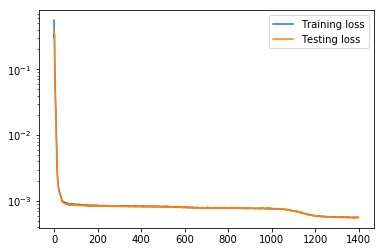

In [93]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.0914), tensor(1.1905), tensor(1.0336), tensor(1.1347), tensor(1.1490), tensor(1.0601), tensor(1.1047), tensor(1.1699), tensor(1.1871), tensor(1.1444), tensor(1.0903), tensor(1.1173), tensor(1.1759), tensor(1.1956), tensor(1.1138)]


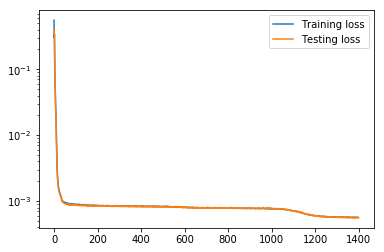

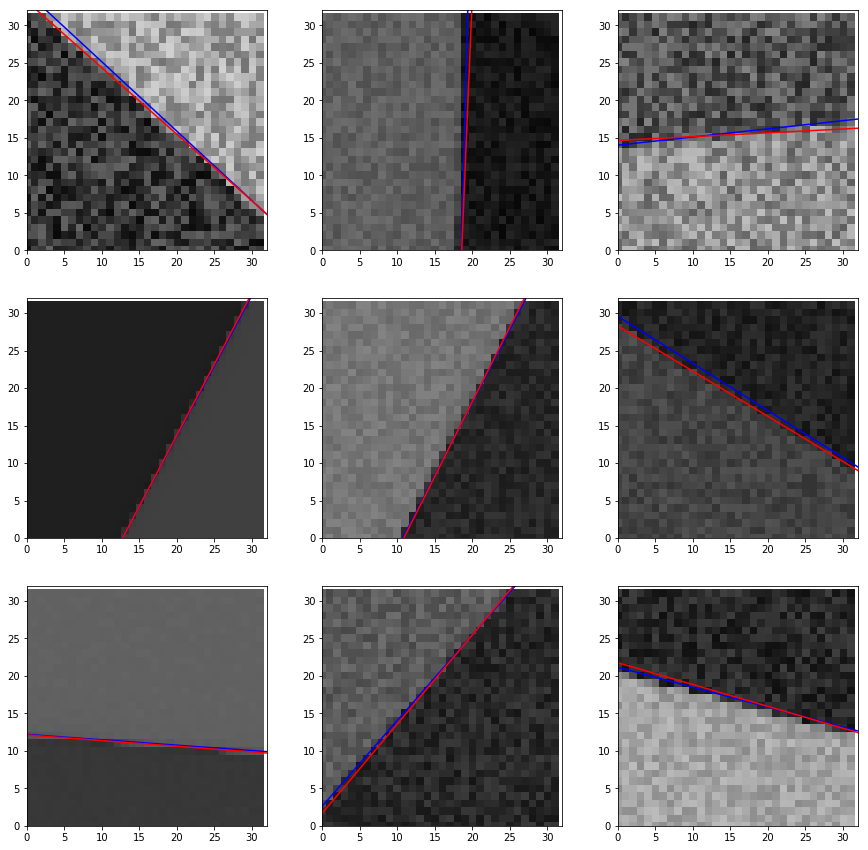

In [94]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')










Epoch: 1, Avg. Train Loss: 0.4617804380696873, Avg. Test Loss: 0.07850006222724915
Epoch: 2, Avg. Train Loss: 0.03147091744684203, Avg. Test Loss: 0.014836628921329975
Epoch: 3, Avg. Train Loss: 0.0106466812146611, Avg. Test Loss: 0.007629907224327326
Epoch: 4, Avg. Train Loss: 0.006271585443078778, Avg. Test Loss: 0.005146570969372988
Epoch: 5, Avg. Train Loss: 0.004517540920439155, Avg. Test Loss: 0.0038912524469196796
Epoch: 6, Avg. Train Loss: 0.003535124586981743, Avg. Test Loss: 0.003128231270238757
Epoch: 7, Avg. Train Loss: 0.0029456843134708878, Avg. Test Loss: 0.0026638400740921497
Epoch: 8, Avg. Train Loss: 0.002556455657319274, Avg. Test Loss: 0.002348259324207902
Epoch: 9, Avg. Train Loss: 0.0022986011503827435, Avg. Test Loss: 0.002128666266798973
Epoch: 10, Avg. Train Loss: 0.002095889061862646, Avg. Test Loss: 0.001963335555046797
Epoch: 11, Avg. Train Loss: 0.0019450503114480959, Avg. Test Loss: 0.0017241172026842833
Epoch: 12, Avg. Train Loss: 0.0016770037486716065, A

Epoch: 94, Avg. Train Loss: 0.0006653303118032771, Avg. Test Loss: 0.0006551052210852504
Epoch: 95, Avg. Train Loss: 0.0006615724346903694, Avg. Test Loss: 0.0006671839510090649
Epoch: 96, Avg. Train Loss: 0.0006628308883803182, Avg. Test Loss: 0.0006511015817523003
Epoch: 97, Avg. Train Loss: 0.0006460792609750358, Avg. Test Loss: 0.000641714665107429
Epoch: 98, Avg. Train Loss: 0.0006479108584286689, Avg. Test Loss: 0.0006546970107592642
Epoch: 99, Avg. Train Loss: 0.0006571345215360092, Avg. Test Loss: 0.0006611241842620075
Epoch: 100, Avg. Train Loss: 0.0006491280834970259, Avg. Test Loss: 0.0006432399386540055
Epoch: 101, Avg. Train Loss: 0.0006518513018395318, Avg. Test Loss: 0.0006473180837929249
Epoch: 102, Avg. Train Loss: 0.0006466236623372276, Avg. Test Loss: 0.0006341477856040001
Epoch: 103, Avg. Train Loss: 0.0006435199351006643, Avg. Test Loss: 0.0006371320341713727
Epoch: 104, Avg. Train Loss: 0.0006475315515904926, Avg. Test Loss: 0.0006520996685139835
Epoch: 105, Avg. 

Epoch: 186, Avg. Train Loss: 0.0006103420841269368, Avg. Test Loss: 0.0006294305203482509
Epoch: 187, Avg. Train Loss: 0.0006042259114491212, Avg. Test Loss: 0.0006289031007327139
Epoch: 188, Avg. Train Loss: 0.0005996092682877599, Avg. Test Loss: 0.0006268375436775386
Epoch: 189, Avg. Train Loss: 0.0006035247311364253, Avg. Test Loss: 0.0006346762529574335
Epoch: 190, Avg. Train Loss: 0.0006085398368710696, Avg. Test Loss: 0.0006190279964357615
Epoch: 191, Avg. Train Loss: 0.0006006856524753709, Avg. Test Loss: 0.0006322789704427123
Epoch: 192, Avg. Train Loss: 0.0006149166702227884, Avg. Test Loss: 0.000621408165898174
Epoch: 193, Avg. Train Loss: 0.00060899049682586, Avg. Test Loss: 0.0006359790568239987
Epoch: 194, Avg. Train Loss: 0.0006129071035227457, Avg. Test Loss: 0.0006345544825308025
Epoch: 195, Avg. Train Loss: 0.0006084259881009889, Avg. Test Loss: 0.0006132019334472716
Epoch: 196, Avg. Train Loss: 0.0005972421996100524, Avg. Test Loss: 0.000626745109912008
Epoch: 197, Av

Epoch: 278, Avg. Train Loss: 0.0005902030361751311, Avg. Test Loss: 0.0006381261046044528
Epoch: 279, Avg. Train Loss: 0.0005951924587946472, Avg. Test Loss: 0.0006224773242138326
Epoch: 280, Avg. Train Loss: 0.0005866779098395518, Avg. Test Loss: 0.0006159008480608463
Epoch: 281, Avg. Train Loss: 0.000587856158787428, Avg. Test Loss: 0.0006219460628926754
Epoch: 282, Avg. Train Loss: 0.000591318843193179, Avg. Test Loss: 0.0006088144727982581
Epoch: 283, Avg. Train Loss: 0.0005859042027813577, Avg. Test Loss: 0.000615447002928704
Epoch: 284, Avg. Train Loss: 0.000595875988649421, Avg. Test Loss: 0.0006155333830974996
Epoch: 285, Avg. Train Loss: 0.0005899354731555769, Avg. Test Loss: 0.0006068056100048125
Epoch: 286, Avg. Train Loss: 0.0005919170338487209, Avg. Test Loss: 0.0006050929077900946
Epoch: 287, Avg. Train Loss: 0.0005826291907037241, Avg. Test Loss: 0.00061995122814551
Epoch: 288, Avg. Train Loss: 0.0005927191151111105, Avg. Test Loss: 0.0006135300500318408
Epoch: 289, Avg.

Epoch: 370, Avg. Train Loss: 0.0005789833633380747, Avg. Test Loss: 0.0005970661877654493
Epoch: 371, Avg. Train Loss: 0.0005748177178713038, Avg. Test Loss: 0.0005965104210190475
Epoch: 372, Avg. Train Loss: 0.0005738537211707512, Avg. Test Loss: 0.0006032419041730464
Epoch: 373, Avg. Train Loss: 0.0005737968130297092, Avg. Test Loss: 0.0005989620694890618
Epoch: 374, Avg. Train Loss: 0.0005751590482717336, Avg. Test Loss: 0.0005979535053484142
Epoch: 375, Avg. Train Loss: 0.0005752361876359426, Avg. Test Loss: 0.000631011906079948
Epoch: 376, Avg. Train Loss: 0.0005852869904036959, Avg. Test Loss: 0.0005997124244458973
Epoch: 377, Avg. Train Loss: 0.000571841887079266, Avg. Test Loss: 0.0006001978763379157
Epoch: 378, Avg. Train Loss: 0.0005810957985421167, Avg. Test Loss: 0.0006243774550966918
Epoch: 379, Avg. Train Loss: 0.000575967944568283, Avg. Test Loss: 0.0006003445596434176
Epoch: 380, Avg. Train Loss: 0.0005793004421257349, Avg. Test Loss: 0.000605897803325206
Epoch: 381, Av

Epoch: 462, Avg. Train Loss: 0.0005654381238855422, Avg. Test Loss: 0.0005942403804510832
Epoch: 463, Avg. Train Loss: 0.0005648396679113597, Avg. Test Loss: 0.0005937211099080741
Epoch: 464, Avg. Train Loss: 0.0005659202065015601, Avg. Test Loss: 0.000594387820456177
Epoch: 465, Avg. Train Loss: 0.0005688033517460923, Avg. Test Loss: 0.0006062746397219598
Epoch: 466, Avg. Train Loss: 0.0005640527477141383, Avg. Test Loss: 0.0005905927391722798
Epoch: 467, Avg. Train Loss: 0.0005619277910946674, Avg. Test Loss: 0.000595653138589114
Epoch: 468, Avg. Train Loss: 0.0005624080956696944, Avg. Test Loss: 0.0005909546744078398
Epoch: 469, Avg. Train Loss: 0.00056808206880855, Avg. Test Loss: 0.0005893847555853426
Epoch: 470, Avg. Train Loss: 0.0005646845553243577, Avg. Test Loss: 0.0005907879676669836
Epoch: 471, Avg. Train Loss: 0.0005639438141072386, Avg. Test Loss: 0.0005914635257795453
Epoch: 472, Avg. Train Loss: 0.0005671995080097817, Avg. Test Loss: 0.0005991562502458692
Epoch: 473, Av

Epoch: 554, Avg. Train Loss: 0.0005534234521693962, Avg. Test Loss: 0.0005903120036236942
Epoch: 555, Avg. Train Loss: 0.000559473515834746, Avg. Test Loss: 0.0005966348107904196
Epoch: 556, Avg. Train Loss: 0.0005661996425302743, Avg. Test Loss: 0.000586687820032239
Epoch: 557, Avg. Train Loss: 0.0005595208163275708, Avg. Test Loss: 0.0005781582440249622
Epoch: 558, Avg. Train Loss: 0.0005561452951867047, Avg. Test Loss: 0.0005842310492880642
Epoch: 559, Avg. Train Loss: 0.0005572666854023674, Avg. Test Loss: 0.0005826969863846898
Epoch: 560, Avg. Train Loss: 0.0005540670921787793, Avg. Test Loss: 0.0005922933341935277
Epoch: 561, Avg. Train Loss: 0.0005618852419713729, Avg. Test Loss: 0.0005814137402921915
Epoch: 562, Avg. Train Loss: 0.0005584338160101758, Avg. Test Loss: 0.0005822020466439426
Epoch: 563, Avg. Train Loss: 0.000557335184313097, Avg. Test Loss: 0.0005903541459701955
Epoch: 564, Avg. Train Loss: 0.0005558608160733223, Avg. Test Loss: 0.0005813469761051238
Epoch: 565, A

Epoch: 646, Avg. Train Loss: 0.0005528926443265275, Avg. Test Loss: 0.0005774001474492252
Epoch: 647, Avg. Train Loss: 0.0005543780408875453, Avg. Test Loss: 0.0005815561162307858
Epoch: 648, Avg. Train Loss: 0.0005605154295809308, Avg. Test Loss: 0.0006029001087881625
Epoch: 649, Avg. Train Loss: 0.0005538045647987273, Avg. Test Loss: 0.0005830746376886964
Epoch: 650, Avg. Train Loss: 0.0005547391544475198, Avg. Test Loss: 0.0005870168679393828
Epoch: 651, Avg. Train Loss: 0.0005545192371057563, Avg. Test Loss: 0.0005854820483364165
Epoch: 652, Avg. Train Loss: 0.0005535554752663471, Avg. Test Loss: 0.0005790197174064815
Epoch: 653, Avg. Train Loss: 0.000551888930373067, Avg. Test Loss: 0.0005781009094789624
Epoch: 654, Avg. Train Loss: 0.0005565824726228277, Avg. Test Loss: 0.0005768496193923056
Epoch: 655, Avg. Train Loss: 0.000550434832612789, Avg. Test Loss: 0.0005803421372547746
Epoch: 656, Avg. Train Loss: 0.0005514356361832036, Avg. Test Loss: 0.0005791353760287166
Epoch: 657, 

Epoch: 738, Avg. Train Loss: 0.0005444053338494065, Avg. Test Loss: 0.0005852754693478346
Epoch: 739, Avg. Train Loss: 0.000549459002159406, Avg. Test Loss: 0.0005792243173345923
Epoch: 740, Avg. Train Loss: 0.0005491725920407145, Avg. Test Loss: 0.0006022260640747845
Epoch: 741, Avg. Train Loss: 0.0005498136830960162, Avg. Test Loss: 0.0005786523106507957
Epoch: 742, Avg. Train Loss: 0.0005476318339026685, Avg. Test Loss: 0.0005702918278984725
Epoch: 743, Avg. Train Loss: 0.0005479659282786469, Avg. Test Loss: 0.0005790575523860753
Epoch: 744, Avg. Train Loss: 0.0005527713063963537, Avg. Test Loss: 0.0005721955094486475
Epoch: 745, Avg. Train Loss: 0.0005426904610304032, Avg. Test Loss: 0.0005701792542822659
Epoch: 746, Avg. Train Loss: 0.0005475081141962302, Avg. Test Loss: 0.0005806708359159529
Epoch: 747, Avg. Train Loss: 0.0005469086517709805, Avg. Test Loss: 0.0005770964780822396
Epoch: 748, Avg. Train Loss: 0.0005469016661748377, Avg. Test Loss: 0.0005853975308127701
Epoch: 749,

Epoch: 830, Avg. Train Loss: 0.0005409153405750214, Avg. Test Loss: 0.0005671008839271963
Epoch: 831, Avg. Train Loss: 0.0005393247823988975, Avg. Test Loss: 0.0005705425282940269
Epoch: 832, Avg. Train Loss: 0.0005393890707298766, Avg. Test Loss: 0.0005665192729793489
Epoch: 833, Avg. Train Loss: 0.0005377949002946099, Avg. Test Loss: 0.0005673276609741151
Epoch: 834, Avg. Train Loss: 0.0005405107425081782, Avg. Test Loss: 0.0005646558711305261
Epoch: 835, Avg. Train Loss: 0.0005440678302642651, Avg. Test Loss: 0.0005781495128758252
Epoch: 836, Avg. Train Loss: 0.0005478419351315689, Avg. Test Loss: 0.0005755018210038543
Epoch: 837, Avg. Train Loss: 0.000547672790437287, Avg. Test Loss: 0.0005805973196402192
Epoch: 838, Avg. Train Loss: 0.0005399534731919249, Avg. Test Loss: 0.0005679980386048555
Epoch: 839, Avg. Train Loss: 0.000541737305168279, Avg. Test Loss: 0.0005605280166491866
Epoch: 840, Avg. Train Loss: 0.0005385295310609996, Avg. Test Loss: 0.0005624399054795504
Epoch: 841, 

Epoch: 922, Avg. Train Loss: 0.0005354439409254769, Avg. Test Loss: 0.000568187388125807
Epoch: 923, Avg. Train Loss: 0.0005402072660386735, Avg. Test Loss: 0.0005592743982560933
Epoch: 924, Avg. Train Loss: 0.0005355786050258335, Avg. Test Loss: 0.0005588213098235428
Epoch: 925, Avg. Train Loss: 0.0005390301399571865, Avg. Test Loss: 0.0005636456771753728
Epoch: 926, Avg. Train Loss: 0.0005354348023227135, Avg. Test Loss: 0.0005592064699158072
Epoch: 927, Avg. Train Loss: 0.0005346974933270885, Avg. Test Loss: 0.000556559709366411
Epoch: 928, Avg. Train Loss: 0.00053469558939511, Avg. Test Loss: 0.0005579187418334186
Epoch: 929, Avg. Train Loss: 0.0005332037155397323, Avg. Test Loss: 0.0005665341741405427
Epoch: 930, Avg. Train Loss: 0.0005324442680047955, Avg. Test Loss: 0.0005630099913105369
Epoch: 931, Avg. Train Loss: 0.0005414578474809004, Avg. Test Loss: 0.0005617910646833479
Epoch: 932, Avg. Train Loss: 0.0005370380809032467, Avg. Test Loss: 0.00057462218683213
Epoch: 933, Avg.

Epoch: 1014, Avg. Train Loss: 0.0005304986667862638, Avg. Test Loss: 0.0005587374325841665
Epoch: 1015, Avg. Train Loss: 0.0005287275863486494, Avg. Test Loss: 0.0005622805911116302
Epoch: 1016, Avg. Train Loss: 0.0005344672847355088, Avg. Test Loss: 0.0005630242521874607
Epoch: 1017, Avg. Train Loss: 0.0005309169984769163, Avg. Test Loss: 0.0005605106707662344
Epoch: 1018, Avg. Train Loss: 0.00053302098409446, Avg. Test Loss: 0.0005647786310873926
Epoch: 1019, Avg. Train Loss: 0.0005314975420587024, Avg. Test Loss: 0.0005531760980375111
Epoch: 1020, Avg. Train Loss: 0.0005325381251506854, Avg. Test Loss: 0.0005531985079869628
Epoch: 1021, Avg. Train Loss: 0.0005320938220139334, Avg. Test Loss: 0.0005546286702156067
Epoch: 1022, Avg. Train Loss: 0.0005321134170138299, Avg. Test Loss: 0.0005623604520224035
Epoch: 1023, Avg. Train Loss: 0.0005316781563695173, Avg. Test Loss: 0.0005504424916580319
Epoch: 1024, Avg. Train Loss: 0.0005339242539606816, Avg. Test Loss: 0.0005583143210969865
E

Epoch: 1105, Avg. Train Loss: 0.000528492666320702, Avg. Test Loss: 0.0005561908474192023
Epoch: 1106, Avg. Train Loss: 0.0005258716457404283, Avg. Test Loss: 0.0005543134757317603
Epoch: 1107, Avg. Train Loss: 0.0005280134907035633, Avg. Test Loss: 0.0005569946370087564
Epoch: 1108, Avg. Train Loss: 0.0005282138265820957, Avg. Test Loss: 0.0005492476630024612
Epoch: 1109, Avg. Train Loss: 0.0005257232541077618, Avg. Test Loss: 0.000550607219338417
Epoch: 1110, Avg. Train Loss: 0.0005232200979493385, Avg. Test Loss: 0.0005534939118660986
Epoch: 1111, Avg. Train Loss: 0.0005279741714286163, Avg. Test Loss: 0.0005651027895510197
Epoch: 1112, Avg. Train Loss: 0.0005295519198583395, Avg. Test Loss: 0.0005481822299771011
Epoch: 1113, Avg. Train Loss: 0.0005256915607132277, Avg. Test Loss: 0.0005441416869871318
Epoch: 1114, Avg. Train Loss: 0.0005273556703604151, Avg. Test Loss: 0.00055721215903759
Epoch: 1115, Avg. Train Loss: 0.0005271112096907441, Avg. Test Loss: 0.0005523876752704382
Epo

Epoch: 1196, Avg. Train Loss: 0.0005250959487924309, Avg. Test Loss: 0.0005479010287672281
Epoch: 1197, Avg. Train Loss: 0.000522514259670103, Avg. Test Loss: 0.0005532766808755696
Epoch: 1198, Avg. Train Loss: 0.0005269737800496608, Avg. Test Loss: 0.0005469804746098816
Epoch: 1199, Avg. Train Loss: 0.0005228948876868154, Avg. Test Loss: 0.0005433193873614073
Epoch: 1200, Avg. Train Loss: 0.0005232414791122252, Avg. Test Loss: 0.0005478428211063147
Epoch: 1201, Avg. Train Loss: 0.0005240028738964696, Avg. Test Loss: 0.0005372234154492617
Epoch: 1202, Avg. Train Loss: 0.0005218865773586426, Avg. Test Loss: 0.0005425706622190773
Epoch: 1203, Avg. Train Loss: 0.0005241747760094789, Avg. Test Loss: 0.000548352487385273
Epoch: 1204, Avg. Train Loss: 0.0005221054638833414, Avg. Test Loss: 0.0005437785293906927
Epoch: 1205, Avg. Train Loss: 0.0005217364875513107, Avg. Test Loss: 0.0005530609632842243
Epoch: 1206, Avg. Train Loss: 0.0005257915364318463, Avg. Test Loss: 0.0005571900401264429
E

Epoch: 1287, Avg. Train Loss: 0.00052028804811714, Avg. Test Loss: 0.000544422771781683
Epoch: 1288, Avg. Train Loss: 0.0005192708787183429, Avg. Test Loss: 0.0005401168018579483
Epoch: 1289, Avg. Train Loss: 0.0005218420342845453, Avg. Test Loss: 0.0005522272549569607
Epoch: 1290, Avg. Train Loss: 0.0005193046127651754, Avg. Test Loss: 0.0005458032246679068
Epoch: 1291, Avg. Train Loss: 0.0005211067882767164, Avg. Test Loss: 0.0005401870002970099
Epoch: 1292, Avg. Train Loss: 0.0005204972261454651, Avg. Test Loss: 0.0005439880769699812
Epoch: 1293, Avg. Train Loss: 0.0005235549916654046, Avg. Test Loss: 0.000535373343154788
Epoch: 1294, Avg. Train Loss: 0.0005243722346697956, Avg. Test Loss: 0.0005587118794210255
Epoch: 1295, Avg. Train Loss: 0.0005237383843767782, Avg. Test Loss: 0.0005455261562019587
Epoch: 1296, Avg. Train Loss: 0.0005228781292951385, Avg. Test Loss: 0.0005518500111065805
Epoch: 1297, Avg. Train Loss: 0.0005209374926486161, Avg. Test Loss: 0.0005410367157310247
Epo

Epoch: 1378, Avg. Train Loss: 0.0005183070755921045, Avg. Test Loss: 0.0005357969785109162
Epoch: 1379, Avg. Train Loss: 0.0005192280324652444, Avg. Test Loss: 0.000538886000867933
Epoch: 1380, Avg. Train Loss: 0.0005181381474844678, Avg. Test Loss: 0.000536940700840205
Epoch: 1381, Avg. Train Loss: 0.0005193476363485896, Avg. Test Loss: 0.0005596819100901484
Epoch: 1382, Avg. Train Loss: 0.0005196039605517547, Avg. Test Loss: 0.0005498528480529785
Epoch: 1383, Avg. Train Loss: 0.0005218321423663563, Avg. Test Loss: 0.0005399172659963369
Epoch: 1384, Avg. Train Loss: 0.0005231575964581828, Avg. Test Loss: 0.0005398446810431778
Epoch: 1385, Avg. Train Loss: 0.0005188045114939382, Avg. Test Loss: 0.0005525774322450161
Epoch: 1386, Avg. Train Loss: 0.0005215003505771504, Avg. Test Loss: 0.0005429622251540422
Epoch: 1387, Avg. Train Loss: 0.00051873522339562, Avg. Test Loss: 0.0005355830071493983
Epoch: 1388, Avg. Train Loss: 0.0005149778193891655, Avg. Test Loss: 0.0005365675315260887
Epo

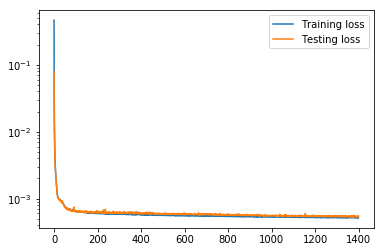

In [95]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.002) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.0366), tensor(1.1086), tensor(1.0430), tensor(1.1114), tensor(1.1206), tensor(1.0563), tensor(1.0584), tensor(1.0950), tensor(1.1460), tensor(1.1069), tensor(1.0565), tensor(1.0747), tensor(1.0919), tensor(1.1527), tensor(1.0806)]


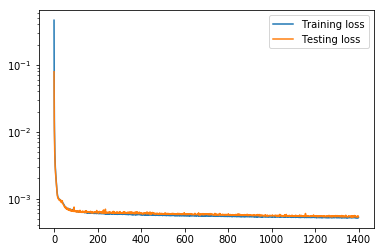

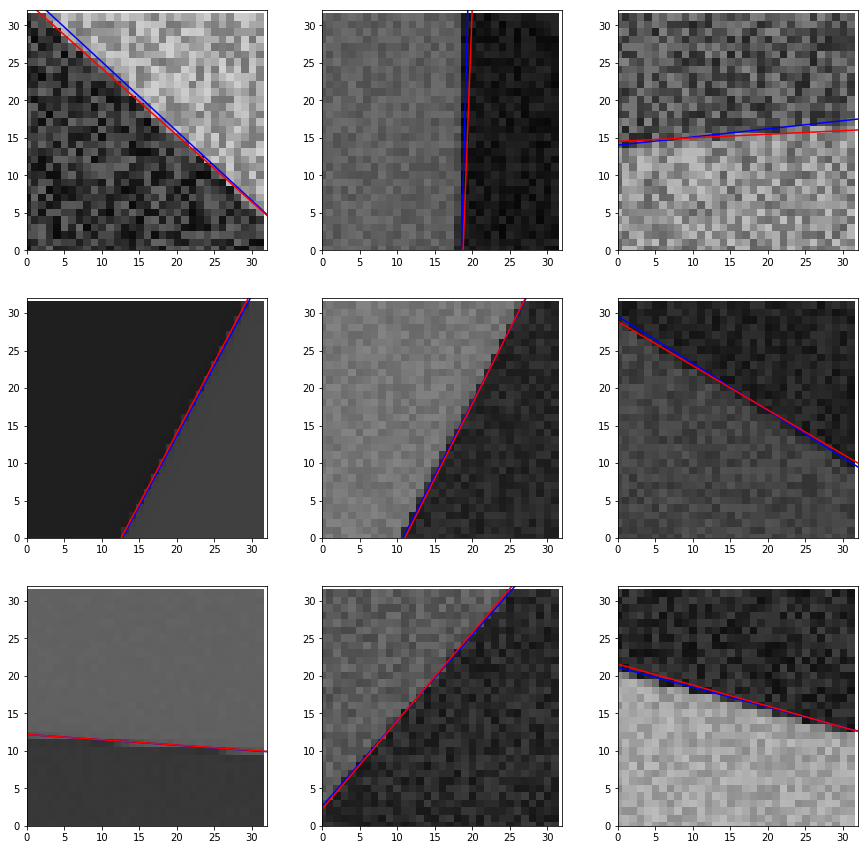

In [96]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')











# ~~~~~~ OLD ~~~~~~~~

# Learning displacements 

In [44]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
#         x = self.conv3(x)
#         x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
#         out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, H, W)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]             640
         MaxPool2d-2           [-1, 64, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          36,928
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Linear-5                    [-1, 2]           4,610
Total params: 42,178
Trainable params: 42,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 0.16
Estimated Total Size (MB): 0.81
----------------------------------------------------------------


In [45]:
model = displacementNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.0001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_line_params,1))) 
#         loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_line_params = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_line_params,1)))
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 0.16770192665212294, Avg. Test Loss: 0.1297314614057541
Epoch: 2, Avg. Train Loss: 0.09747713707825717, Avg. Test Loss: 0.08074680715799332
Epoch: 3, Avg. Train Loss: 0.07516016530639985, Avg. Test Loss: 0.06859997659921646
Epoch: 4, Avg. Train Loss: 0.069324160717866, Avg. Test Loss: 0.06439492851495743
Epoch: 5, Avg. Train Loss: 0.06031278959091972, Avg. Test Loss: 0.05314290523529053
Epoch: 6, Avg. Train Loss: 0.050975669920444486, Avg. Test Loss: 0.05150887742638588
Epoch: 7, Avg. Train Loss: 0.042852459124782506, Avg. Test Loss: 0.03861701861023903
Epoch: 8, Avg. Train Loss: 0.03509438504629275, Avg. Test Loss: 0.03148335590958595
Epoch: 9, Avg. Train Loss: 0.031468556865173226, Avg. Test Loss: 0.02754547819495201
Epoch: 10, Avg. Train Loss: 0.028183964398853917, Avg. Test Loss: 0.025842519477009773
Epoch: 11, Avg. Train Loss: 0.026212239440749675, Avg. Test Loss: 0.024494973942637444
Epoch: 12, Avg. Train Loss: 0.025026498252854627, Avg. Test Loss: 0.02

Epoch: 96, Avg. Train Loss: 0.009378031904206557, Avg. Test Loss: 0.011228424496948719
Epoch: 97, Avg. Train Loss: 0.009534270086270922, Avg. Test Loss: 0.009840796701610088
Epoch: 98, Avg. Train Loss: 0.008488769259522943, Avg. Test Loss: 0.009820425882935524
Epoch: 99, Avg. Train Loss: 0.008823147476376856, Avg. Test Loss: 0.009728324599564075
Epoch: 100, Avg. Train Loss: 0.00892628689899164, Avg. Test Loss: 0.011093785986304283
Epoch: 101, Avg. Train Loss: 0.009293145883609267, Avg. Test Loss: 0.009420527145266533
Epoch: 102, Avg. Train Loss: 0.009005882470485041, Avg. Test Loss: 0.01150917075574398
Epoch: 103, Avg. Train Loss: 0.008872347374391906, Avg. Test Loss: 0.010828014463186264
Epoch: 104, Avg. Train Loss: 0.008756126868812476, Avg. Test Loss: 0.00985957495868206
Epoch: 105, Avg. Train Loss: 0.008836106205468668, Avg. Test Loss: 0.00937630794942379
Epoch: 106, Avg. Train Loss: 0.008481927966589437, Avg. Test Loss: 0.009495936334133148
Epoch: 107, Avg. Train Loss: 0.008723904

Epoch: 190, Avg. Train Loss: 0.006606363685911193, Avg. Test Loss: 0.0076416488736867905
Epoch: 191, Avg. Train Loss: 0.006241148803383112, Avg. Test Loss: 0.00782207865267992
Epoch: 192, Avg. Train Loss: 0.006389386004165692, Avg. Test Loss: 0.008217270486056805
Epoch: 193, Avg. Train Loss: 0.006906599792487481, Avg. Test Loss: 0.009080012328922749
Epoch: 194, Avg. Train Loss: 0.0070319047635968995, Avg. Test Loss: 0.00807256530970335
Epoch: 195, Avg. Train Loss: 0.00636508523431771, Avg. Test Loss: 0.00850424449890852
Epoch: 196, Avg. Train Loss: 0.00662820476162083, Avg. Test Loss: 0.007924717850983143
Epoch: 197, Avg. Train Loss: 0.006294861923464958, Avg. Test Loss: 0.007495052646845579
Epoch: 198, Avg. Train Loss: 0.006759830460171489, Avg. Test Loss: 0.008598900400102139
Epoch: 199, Avg. Train Loss: 0.006273357367471737, Avg. Test Loss: 0.008127734996378422
Epoch: 200, Avg. Train Loss: 0.007404272762291572, Avg. Test Loss: 0.007934515364468098
Epoch: 201, Avg. Train Loss: 0.0065

Epoch: 284, Avg. Train Loss: 0.005229952512308955, Avg. Test Loss: 0.006947335787117481
Epoch: 285, Avg. Train Loss: 0.005474760057404637, Avg. Test Loss: 0.007563961669802666
Epoch: 286, Avg. Train Loss: 0.00565198345164604, Avg. Test Loss: 0.006895300000905991
Epoch: 287, Avg. Train Loss: 0.005661908526192693, Avg. Test Loss: 0.007392135914415121
Epoch: 288, Avg. Train Loss: 0.005584952673491309, Avg. Test Loss: 0.007566550746560097
Epoch: 289, Avg. Train Loss: 0.00553395395331523, Avg. Test Loss: 0.006862299516797066
Epoch: 290, Avg. Train Loss: 0.005458540305056993, Avg. Test Loss: 0.006913964170962572
Epoch: 291, Avg. Train Loss: 0.00532385523102301, Avg. Test Loss: 0.007586041931062937
Epoch: 292, Avg. Train Loss: 0.006111966089948136, Avg. Test Loss: 0.006972481030970812
Epoch: 293, Avg. Train Loss: 0.005242405612679089, Avg. Test Loss: 0.0072044795379042625
Epoch: 294, Avg. Train Loss: 0.00527123948559165, Avg. Test Loss: 0.006952873896807432
Epoch: 295, Avg. Train Loss: 0.0057

Epoch: 378, Avg. Train Loss: 0.004870328403023236, Avg. Test Loss: 0.00660500954836607
Epoch: 379, Avg. Train Loss: 0.004438896222478327, Avg. Test Loss: 0.007040123455226421
Epoch: 380, Avg. Train Loss: 0.005582390369518715, Avg. Test Loss: 0.007231302559375763
Epoch: 381, Avg. Train Loss: 0.005046489689608707, Avg. Test Loss: 0.006765306461602449
Epoch: 382, Avg. Train Loss: 0.004735003477510284, Avg. Test Loss: 0.007208024151623249
Epoch: 383, Avg. Train Loss: 0.004900516777792398, Avg. Test Loss: 0.0068164062686264515
Epoch: 384, Avg. Train Loss: 0.004651300685808939, Avg. Test Loss: 0.00638247188180685
Epoch: 385, Avg. Train Loss: 0.00471682265839156, Avg. Test Loss: 0.00639350013807416
Epoch: 386, Avg. Train Loss: 0.004773021325030748, Avg. Test Loss: 0.006485760677605867
Epoch: 387, Avg. Train Loss: 0.004892399794805576, Avg. Test Loss: 0.006786240264773369
Epoch: 388, Avg. Train Loss: 0.00514189267585821, Avg. Test Loss: 0.006713212002068758
Epoch: 389, Avg. Train Loss: 0.00478

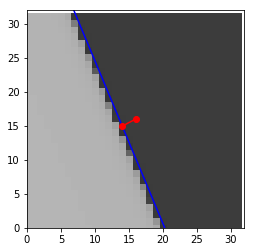

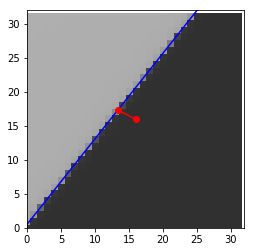

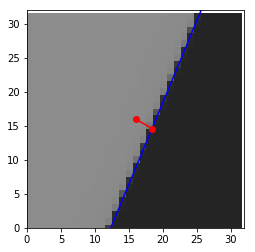

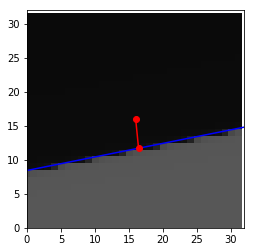

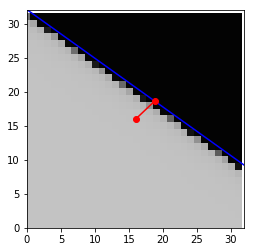

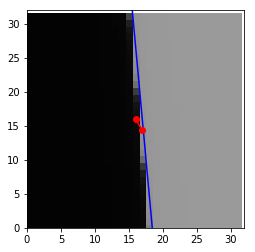

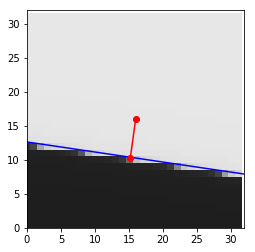

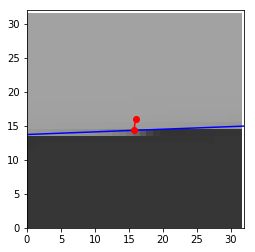

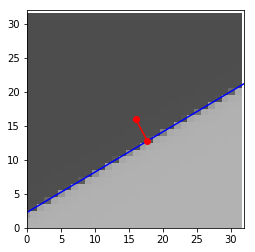

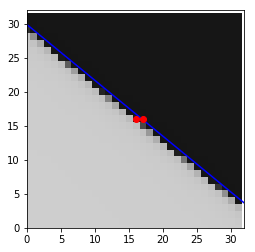

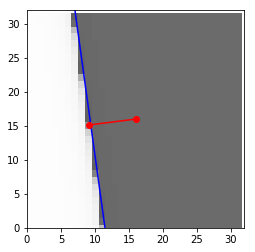

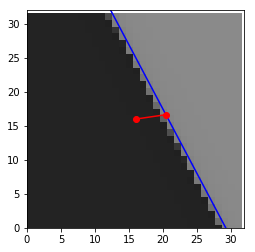

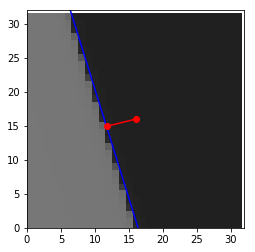

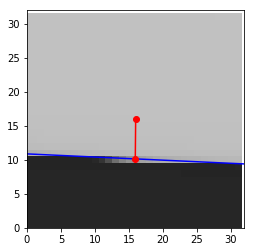

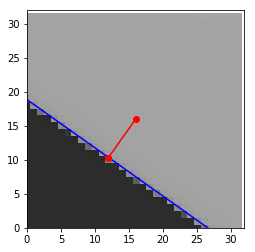

In [46]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([W/2,W/2]),outputs[ii]*W/2+W/2),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')




## Try minimum displacement distance

In [47]:
model = displacementNet()
model = model.to(dev)
# model.apply(init_weights)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

Epoch: 1, Avg. Train Loss: 0.21887205015210545, Avg. Test Loss: 0.132222518324852
Epoch: 2, Avg. Train Loss: 0.11012536743107965, Avg. Test Loss: 0.0782802626490593
Epoch: 3, Avg. Train Loss: 0.06420385548297097, Avg. Test Loss: 0.07369076460599899
Epoch: 4, Avg. Train Loss: 0.059786962498636805, Avg. Test Loss: 0.047875382006168365
Epoch: 5, Avg. Train Loss: 0.046553893365404185, Avg. Test Loss: 0.04397212341427803
Epoch: 6, Avg. Train Loss: 0.04345937274834689, Avg. Test Loss: 0.03881297633051872
Epoch: 7, Avg. Train Loss: 0.04217416151043247, Avg. Test Loss: 0.03856995329260826
Epoch: 8, Avg. Train Loss: 0.03815983387038988, Avg. Test Loss: 0.032693877816200256
Epoch: 9, Avg. Train Loss: 0.032746709992780405, Avg. Test Loss: 0.0406530387699604
Epoch: 10, Avg. Train Loss: 0.03251341649276369, Avg. Test Loss: 0.03401067852973938
Epoch: 11, Avg. Train Loss: 0.03259680242661168, Avg. Test Loss: 0.02841821499168873
Epoch: 12, Avg. Train Loss: 0.031223197741543546, Avg. Test Loss: 0.02890

Epoch: 97, Avg. Train Loss: 0.013803015824626473, Avg. Test Loss: 0.015498083084821701
Epoch: 98, Avg. Train Loss: 0.014684709534049035, Avg. Test Loss: 0.01598740555346012
Epoch: 99, Avg. Train Loss: 0.015003459780093502, Avg. Test Loss: 0.018965745344758034
Epoch: 100, Avg. Train Loss: 0.016984945086433608, Avg. Test Loss: 0.01588542014360428
Epoch: 101, Avg. Train Loss: 0.015441219694912434, Avg. Test Loss: 0.015360461547970772
Epoch: 102, Avg. Train Loss: 0.015091201345271924, Avg. Test Loss: 0.014136466197669506
Epoch: 103, Avg. Train Loss: 0.013448595825363608, Avg. Test Loss: 0.015464529395103455
Epoch: 104, Avg. Train Loss: 0.014687326638137594, Avg. Test Loss: 0.015902774408459663
Epoch: 105, Avg. Train Loss: 0.013594057904008557, Avg. Test Loss: 0.015760192647576332
Epoch: 106, Avg. Train Loss: 0.01666482463479042, Avg. Test Loss: 0.016887551173567772
Epoch: 107, Avg. Train Loss: 0.014030913910006776, Avg. Test Loss: 0.01598091423511505
Epoch: 108, Avg. Train Loss: 0.01481035

Epoch: 191, Avg. Train Loss: 0.011232651025056838, Avg. Test Loss: 0.013645700179040432
Epoch: 192, Avg. Train Loss: 0.011922998485319755, Avg. Test Loss: 0.012845596298575401
Epoch: 193, Avg. Train Loss: 0.01144975544336964, Avg. Test Loss: 0.014040355570614338
Epoch: 194, Avg. Train Loss: 0.010784409469103112, Avg. Test Loss: 0.011792425997555256
Epoch: 195, Avg. Train Loss: 0.01111096696489874, Avg. Test Loss: 0.013208176009356976
Epoch: 196, Avg. Train Loss: 0.011507221629076145, Avg. Test Loss: 0.013004433363676071
Epoch: 197, Avg. Train Loss: 0.011289754016872714, Avg. Test Loss: 0.014214836061000824
Epoch: 198, Avg. Train Loss: 0.012202995741630302, Avg. Test Loss: 0.01421508751809597
Epoch: 199, Avg. Train Loss: 0.01161320495473988, Avg. Test Loss: 0.014134305529296398
Epoch: 200, Avg. Train Loss: 0.01184755732469699, Avg. Test Loss: 0.01499056164175272
Epoch: 201, Avg. Train Loss: 0.011678047280977754, Avg. Test Loss: 0.0142575828358531
Epoch: 202, Avg. Train Loss: 0.012128173

Epoch: 285, Avg. Train Loss: 0.00985581754871151, Avg. Test Loss: 0.012145974673330784
Epoch: 286, Avg. Train Loss: 0.010478228319655447, Avg. Test Loss: 0.012058562599122524
Epoch: 287, Avg. Train Loss: 0.010682795624084333, Avg. Test Loss: 0.011879061348736286
Epoch: 288, Avg. Train Loss: 0.0105076589018983, Avg. Test Loss: 0.01595422253012657
Epoch: 289, Avg. Train Loss: 0.011660554479150211, Avg. Test Loss: 0.013735548593103886
Epoch: 290, Avg. Train Loss: 0.011119469671564944, Avg. Test Loss: 0.012375074438750744
Epoch: 291, Avg. Train Loss: 0.010325352562701002, Avg. Test Loss: 0.011323576793074608
Epoch: 292, Avg. Train Loss: 0.01024241028353572, Avg. Test Loss: 0.016270313411951065
Epoch: 293, Avg. Train Loss: 0.010086347173680277, Avg. Test Loss: 0.0133185014128685
Epoch: 294, Avg. Train Loss: 0.011693636853905285, Avg. Test Loss: 0.013563859276473522
Epoch: 295, Avg. Train Loss: 0.010891791115350583, Avg. Test Loss: 0.01222698949277401
Epoch: 296, Avg. Train Loss: 0.010222833

Epoch: 379, Avg. Train Loss: 0.008932272629702793, Avg. Test Loss: 0.012518234550952911
Epoch: 380, Avg. Train Loss: 0.010295358815175645, Avg. Test Loss: 0.01332184113562107
Epoch: 381, Avg. Train Loss: 0.010599396744852557, Avg. Test Loss: 0.01575297862291336
Epoch: 382, Avg. Train Loss: 0.010598379143458955, Avg. Test Loss: 0.011665585450828075
Epoch: 383, Avg. Train Loss: 0.00964855018126614, Avg. Test Loss: 0.012089407071471214
Epoch: 384, Avg. Train Loss: 0.01048414872630554, Avg. Test Loss: 0.012993898242712021
Epoch: 385, Avg. Train Loss: 0.009656564409241957, Avg. Test Loss: 0.013398219831287861
Epoch: 386, Avg. Train Loss: 0.010448039832579739, Avg. Test Loss: 0.012348822318017483
Epoch: 387, Avg. Train Loss: 0.00966797429958687, Avg. Test Loss: 0.012128553353250027
Epoch: 388, Avg. Train Loss: 0.01001587423550732, Avg. Test Loss: 0.013879844918847084
Epoch: 389, Avg. Train Loss: 0.010295638820046887, Avg. Test Loss: 0.014116965234279633
Epoch: 390, Avg. Train Loss: 0.0101187

tensor(0.0052)
tensor(0.0042)
tensor(0.0036)
tensor(0.0047)
tensor(0.0038)
tensor(0.0040)
tensor(0.0045)
tensor(0.0048)
tensor(0.0037)
tensor(0.0042)
tensor(0.0037)
tensor(0.0044)
tensor(0.0048)
tensor(0.0039)
tensor(0.0043)


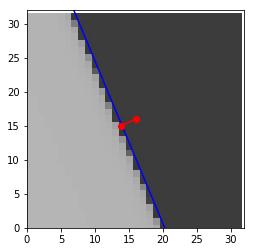

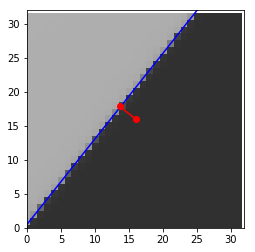

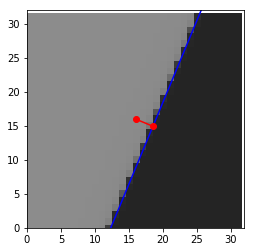

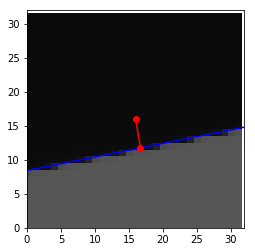

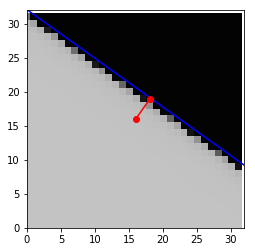

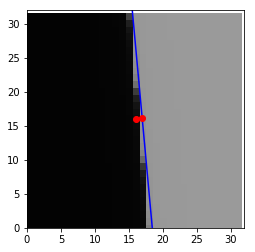

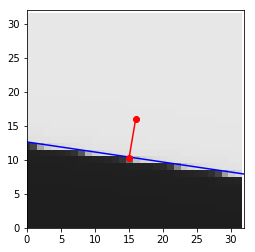

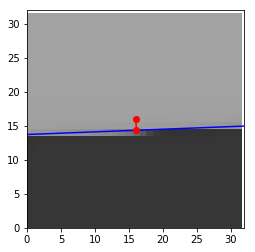

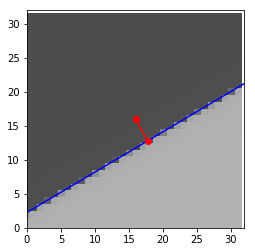

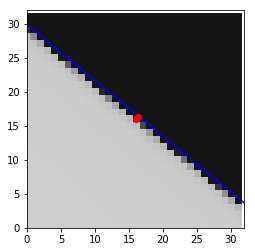

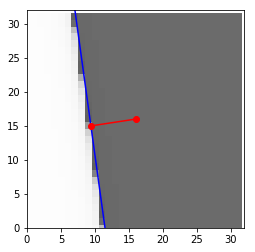

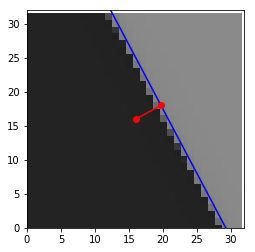

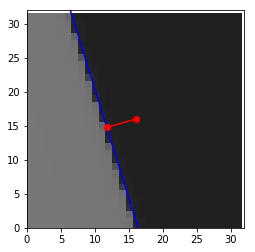

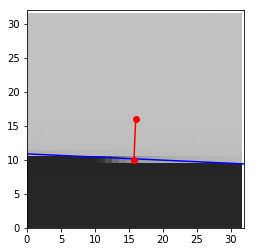

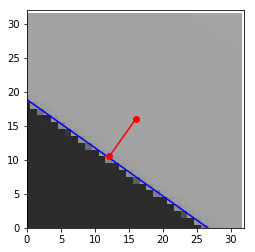

In [48]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
    
    output_displacement = torch.cat((outputs,torch.ones((len(inputs),1))),dim=1) 
    # Calculate the loss for previous metric
    loss = torch.mean(torch.abs(torch.sum(angle_params*output_displacement,1))) 
    
    print(loss)

    
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([W/2,W/2]),outputs[ii]*W/2+W/2),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')





## Testing without max pooling

In [50]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
#         out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, H, W)])

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.0001)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]             640
            Conv2d-2           [-1, 64, 28, 28]          36,928
            Linear-3                    [-1, 2]         100,354
Total params: 137,922
Trainable params: 137,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.82
Params size (MB): 0.53
Estimated Total Size (MB): 1.35
----------------------------------------------------------------
Epoch: 1, Avg. Train Loss: 0.2902184784412384, Avg. Test Loss: 0.1637367308139801
Epoch: 2, Avg. Train Loss: 0.149915491307483, Avg. Test Loss: 0.13835012912750244
Epoch: 3, Avg. Train Loss: 0.12637135193628424, Avg. Test Loss: 0.10784365981817245
Epoch: 4, Avg. Train Loss: 0.09668810981161455, Avg. Test Loss: 0.08035918325185776
Epoch: 5, Avg. Train Loss: 0.0

Epoch: 88, Avg. Train Loss: 0.013013425995321834, Avg. Test Loss: 0.020987618714571
Epoch: 89, Avg. Train Loss: 0.014269199715379407, Avg. Test Loss: 0.019851498305797577
Epoch: 90, Avg. Train Loss: 0.01253840660347658, Avg. Test Loss: 0.0170828215777874
Epoch: 91, Avg. Train Loss: 0.012504012411569848, Avg. Test Loss: 0.01733279973268509
Epoch: 92, Avg. Train Loss: 0.0110284723341465, Avg. Test Loss: 0.01792837120592594
Epoch: 93, Avg. Train Loss: 0.011463482250623843, Avg. Test Loss: 0.017280926927924156
Epoch: 94, Avg. Train Loss: 0.013280481636962469, Avg. Test Loss: 0.01841917261481285
Epoch: 95, Avg. Train Loss: 0.012326408341965255, Avg. Test Loss: 0.01747431419789791
Epoch: 96, Avg. Train Loss: 0.011960969383225722, Avg. Test Loss: 0.019316671416163445
Epoch: 97, Avg. Train Loss: 0.012317574188551481, Avg. Test Loss: 0.020403098315000534
Epoch: 98, Avg. Train Loss: 0.019471351155901657, Avg. Test Loss: 0.024119626730680466
Epoch: 99, Avg. Train Loss: 0.016663469593314564, Avg. 

Epoch: 182, Avg. Train Loss: 0.009174597438643961, Avg. Test Loss: 0.015539519488811493
Epoch: 183, Avg. Train Loss: 0.007274332522031139, Avg. Test Loss: 0.016851024702191353
Epoch: 184, Avg. Train Loss: 0.007357469874927226, Avg. Test Loss: 0.01650136336684227
Epoch: 185, Avg. Train Loss: 0.00834004294455928, Avg. Test Loss: 0.016669129952788353
Epoch: 186, Avg. Train Loss: 0.008644812274724245, Avg. Test Loss: 0.017373688519001007
Epoch: 187, Avg. Train Loss: 0.008911553682649837, Avg. Test Loss: 0.019216986373066902
Epoch: 188, Avg. Train Loss: 0.00870077441829969, Avg. Test Loss: 0.01631760038435459
Epoch: 189, Avg. Train Loss: 0.007552160711630302, Avg. Test Loss: 0.015983227640390396
Epoch: 190, Avg. Train Loss: 0.007122531412717174, Avg. Test Loss: 0.01736672967672348
Epoch: 191, Avg. Train Loss: 0.008828074654892963, Avg. Test Loss: 0.016826506704092026
Epoch: 192, Avg. Train Loss: 0.00909014212734559, Avg. Test Loss: 0.01579672284424305
Epoch: 193, Avg. Train Loss: 0.00958684

Epoch: 276, Avg. Train Loss: 0.0064823498346788045, Avg. Test Loss: 0.016001924872398376
Epoch: 277, Avg. Train Loss: 0.007094057271366611, Avg. Test Loss: 0.015394461341202259
Epoch: 278, Avg. Train Loss: 0.0063082618474522055, Avg. Test Loss: 0.01681138202548027
Epoch: 279, Avg. Train Loss: 0.007241568150108351, Avg. Test Loss: 0.015562628395855427
Epoch: 280, Avg. Train Loss: 0.007379070757066502, Avg. Test Loss: 0.015351775102317333
Epoch: 281, Avg. Train Loss: 0.006347706042887534, Avg. Test Loss: 0.016671059653162956
Epoch: 282, Avg. Train Loss: 0.006645207939779057, Avg. Test Loss: 0.015958530828356743
Epoch: 283, Avg. Train Loss: 0.006660260435412912, Avg. Test Loss: 0.016590705141425133
Epoch: 284, Avg. Train Loss: 0.007030287954737159, Avg. Test Loss: 0.015368339605629444
Epoch: 285, Avg. Train Loss: 0.006483832034556305, Avg. Test Loss: 0.01624172180891037
Epoch: 286, Avg. Train Loss: 0.006628198658718783, Avg. Test Loss: 0.015549665316939354
Epoch: 287, Avg. Train Loss: 0.0

Epoch: 370, Avg. Train Loss: 0.005506074423079981, Avg. Test Loss: 0.015353185124695301
Epoch: 371, Avg. Train Loss: 0.004948069051127223, Avg. Test Loss: 0.016031377017498016
Epoch: 372, Avg. Train Loss: 0.00642756552380674, Avg. Test Loss: 0.015397247858345509
Epoch: 373, Avg. Train Loss: 0.005344090303953956, Avg. Test Loss: 0.016323581337928772
Epoch: 374, Avg. Train Loss: 0.005859463744084624, Avg. Test Loss: 0.016044549643993378
Epoch: 375, Avg. Train Loss: 0.0064949335311265555, Avg. Test Loss: 0.015520081855356693
Epoch: 376, Avg. Train Loss: 0.006264957802041489, Avg. Test Loss: 0.015498538501560688
Epoch: 377, Avg. Train Loss: 0.005938256860655897, Avg. Test Loss: 0.01594536565244198
Epoch: 378, Avg. Train Loss: 0.005524699436500668, Avg. Test Loss: 0.015989042818546295
Epoch: 379, Avg. Train Loss: 0.005282518694944242, Avg. Test Loss: 0.015282548032701015
Epoch: 380, Avg. Train Loss: 0.005224138805094887, Avg. Test Loss: 0.016153447329998016
Epoch: 381, Avg. Train Loss: 0.00

tensor(0.0068)
tensor(0.0068)
tensor(0.0071)
tensor(0.0096)
tensor(0.0058)
tensor(0.0067)
tensor(0.0070)
tensor(0.0077)
tensor(0.0064)
tensor(0.0067)
tensor(0.0062)
tensor(0.0071)
tensor(0.0070)
tensor(0.0063)
tensor(0.0070)


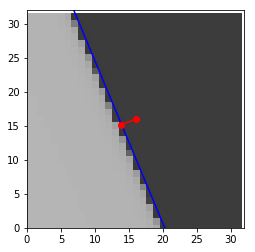

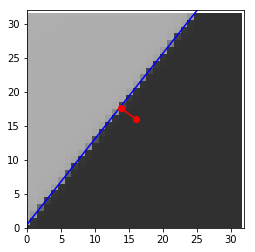

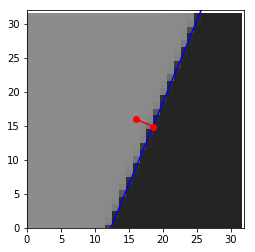

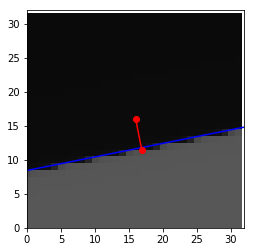

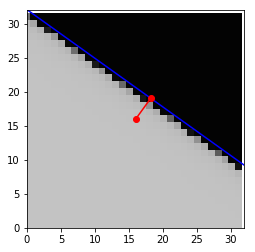

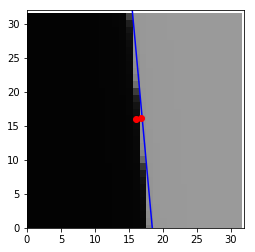

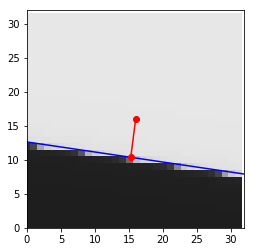

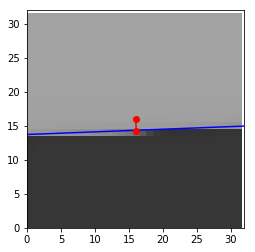

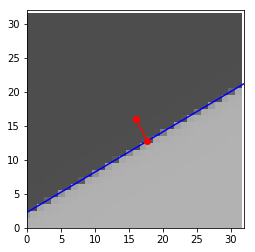

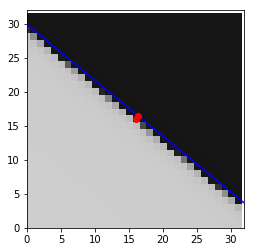

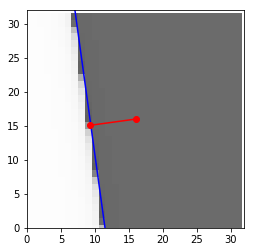

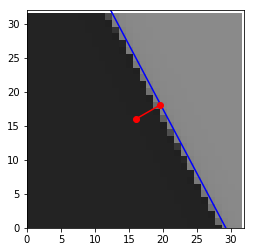

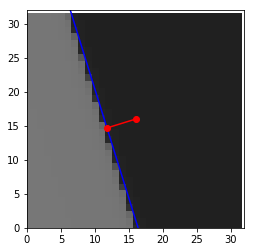

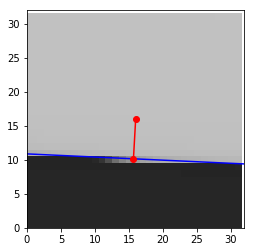

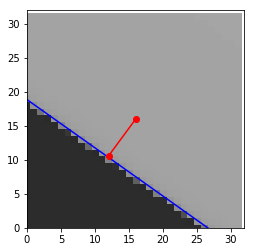

In [52]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
    
    output_displacement = torch.cat((outputs,torch.ones((len(inputs),1))),dim=1) 
    # Calculate the loss for previous metric
    loss = torch.mean(torch.abs(torch.sum(angle_params*output_displacement,1))) 
    
    print(loss)

    
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([W/2,W/2]),outputs[ii]*W/2+W/2),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')






# With max pooling and stride 1

In [56]:
class displacementNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc = nn.LazyLinear(2)
        self.maxpool = nn.MaxPool2d(2,stride=1)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(self.maxpool(x))
#         x = self.conv4(x)
#         x = F.relu(self.maxpool(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
#         norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
#         out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

        out = x
        
        return out
    
model = displacementNet()
model = model.to(dev)
summary(model, input_size=[(1, H, W)])

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.0002)

n_epochs = 400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)
        
        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
#         loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
#         loss = mse_loss(output_line_params,gt_line_params)

        w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
    
        loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))


        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

             # forward pass to get outputs
            output_displacement = torch.cat((model(inputs),torch.ones((len(inputs),1),device=dev)),dim=1)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)


            # calculate the loss
#             loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement,dim=1))
            w = torch.stack((-gt_line_params[:,0]*gt_line_params[:,2],-gt_line_params[:,1]*gt_line_params[:,2]),dim=1)
            loss = torch.mean(torch.abs(torch.sum(gt_line_params*output_displacement,1)) + torch.norm(output_displacement[:,:2]-w,dim=1))

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)


    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]             640
         MaxPool2d-2           [-1, 64, 29, 29]               0
            Conv2d-3           [-1, 64, 27, 27]          36,928
         MaxPool2d-4           [-1, 64, 26, 26]               0
            Linear-5                    [-1, 2]          86,530
Total params: 124,098
Trainable params: 124,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.54
Params size (MB): 0.47
Estimated Total Size (MB): 2.01
----------------------------------------------------------------
Epoch: 1, Avg. Train Loss: 0.24618003298254573, Avg. Test Loss: 0.14625020325183868
Epoch: 2, Avg. Train Loss: 0.1136188995312242, Avg. Test Loss: 0.09714320302009583
Epoch: 3, Avg. Train Loss: 0.0711193396764643, Avg. Test Loss: 0.07

Epoch: 86, Avg. Train Loss: 0.015625519995741983, Avg. Test Loss: 0.018042344599962234
Epoch: 87, Avg. Train Loss: 0.015490710056003403, Avg. Test Loss: 0.020020632073283195
Epoch: 88, Avg. Train Loss: 0.016809225586407326, Avg. Test Loss: 0.02143363654613495
Epoch: 89, Avg. Train Loss: 0.01565021201968193, Avg. Test Loss: 0.019441282376646996
Epoch: 90, Avg. Train Loss: 0.01574694803532432, Avg. Test Loss: 0.018534552305936813
Epoch: 91, Avg. Train Loss: 0.014913056505953565, Avg. Test Loss: 0.015577946789562702
Epoch: 92, Avg. Train Loss: 0.013295459100867019, Avg. Test Loss: 0.017892461270093918
Epoch: 93, Avg. Train Loss: 0.01423323617919403, Avg. Test Loss: 0.016884440556168556
Epoch: 94, Avg. Train Loss: 0.01410159989095786, Avg. Test Loss: 0.017568420618772507
Epoch: 95, Avg. Train Loss: 0.014929500671432299, Avg. Test Loss: 0.023100296035408974
Epoch: 96, Avg. Train Loss: 0.015395323734949617, Avg. Test Loss: 0.01770561747252941
Epoch: 97, Avg. Train Loss: 0.015199569952400292,

Epoch: 180, Avg. Train Loss: 0.013587128557264804, Avg. Test Loss: 0.016507845371961594
Epoch: 181, Avg. Train Loss: 0.012361240080174278, Avg. Test Loss: 0.014546203427016735
Epoch: 182, Avg. Train Loss: 0.011283926972571542, Avg. Test Loss: 0.013891225680708885
Epoch: 183, Avg. Train Loss: 0.011896820684127948, Avg. Test Loss: 0.014953014440834522
Epoch: 184, Avg. Train Loss: 0.010937970789039837, Avg. Test Loss: 0.015974286943674088
Epoch: 185, Avg. Train Loss: 0.011521815968786969, Avg. Test Loss: 0.015446835197508335
Epoch: 186, Avg. Train Loss: 0.011322814532939126, Avg. Test Loss: 0.02081896923482418
Epoch: 187, Avg. Train Loss: 0.012928173000759938, Avg. Test Loss: 0.015505910851061344
Epoch: 188, Avg. Train Loss: 0.012454201806994046, Avg. Test Loss: 0.015168133191764355
Epoch: 189, Avg. Train Loss: 0.016510358693845133, Avg. Test Loss: 0.017386576160788536
Epoch: 190, Avg. Train Loss: 0.012298474548494115, Avg. Test Loss: 0.015862945467233658
Epoch: 191, Avg. Train Loss: 0.01

Epoch: 274, Avg. Train Loss: 0.011853902063825552, Avg. Test Loss: 0.01594109833240509
Epoch: 275, Avg. Train Loss: 0.010164679554017151, Avg. Test Loss: 0.01458000112324953
Epoch: 276, Avg. Train Loss: 0.011486265874084304, Avg. Test Loss: 0.014572493731975555
Epoch: 277, Avg. Train Loss: 0.009456589363296242, Avg. Test Loss: 0.01452802587300539
Epoch: 278, Avg. Train Loss: 0.012504631149418214, Avg. Test Loss: 0.014893990010023117
Epoch: 279, Avg. Train Loss: 0.010030915971626253, Avg. Test Loss: 0.013510684482753277
Epoch: 280, Avg. Train Loss: 0.010467251740834292, Avg. Test Loss: 0.015506350435316563
Epoch: 281, Avg. Train Loss: 0.011280855240629, Avg. Test Loss: 0.015221629291772842
Epoch: 282, Avg. Train Loss: 0.009605369311483467, Avg. Test Loss: 0.013588613830506802
Epoch: 283, Avg. Train Loss: 0.010662516398245798, Avg. Test Loss: 0.013841033913195133
Epoch: 284, Avg. Train Loss: 0.010017627784434487, Avg. Test Loss: 0.015339136123657227
Epoch: 285, Avg. Train Loss: 0.0092326

Epoch: 368, Avg. Train Loss: 0.008709016360123369, Avg. Test Loss: 0.014500558376312256
Epoch: 369, Avg. Train Loss: 0.008925548524541013, Avg. Test Loss: 0.015277808532118797
Epoch: 370, Avg. Train Loss: 0.007951161133892395, Avg. Test Loss: 0.013507308438420296
Epoch: 371, Avg. Train Loss: 0.009143405517234521, Avg. Test Loss: 0.013795585371553898
Epoch: 372, Avg. Train Loss: 0.008611105453661259, Avg. Test Loss: 0.014164156280457973
Epoch: 373, Avg. Train Loss: 0.008615150193081183, Avg. Test Loss: 0.013473576866090298
Epoch: 374, Avg. Train Loss: 0.008700878951041137, Avg. Test Loss: 0.013335944153368473
Epoch: 375, Avg. Train Loss: 0.008520757494603886, Avg. Test Loss: 0.014530790038406849
Epoch: 376, Avg. Train Loss: 0.010094147674081956, Avg. Test Loss: 0.019477680325508118
Epoch: 377, Avg. Train Loss: 0.008673392493716058, Avg. Test Loss: 0.015179076232016087
Epoch: 378, Avg. Train Loss: 0.008182643616900725, Avg. Test Loss: 0.013670317828655243
Epoch: 379, Avg. Train Loss: 0.0

tensor(0.0064)
tensor(0.0060)
tensor(0.0060)
tensor(0.0073)
tensor(0.0062)
tensor(0.0053)
tensor(0.0064)
tensor(0.0065)
tensor(0.0060)
tensor(0.0060)
tensor(0.0060)
tensor(0.0069)
tensor(0.0058)
tensor(0.0054)
tensor(0.0053)


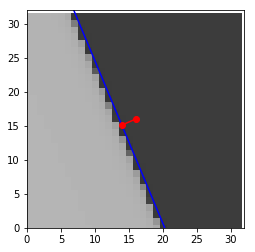

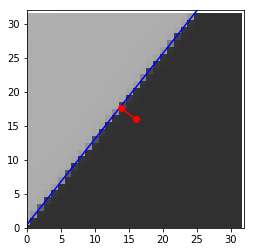

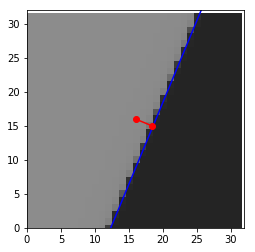

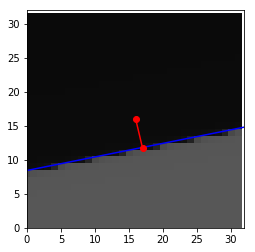

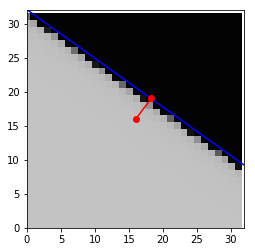

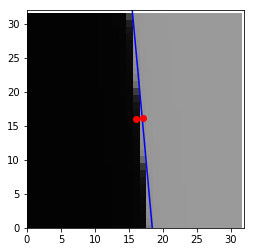

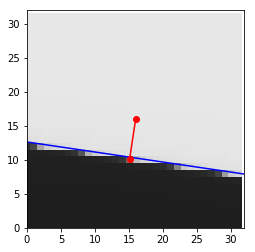

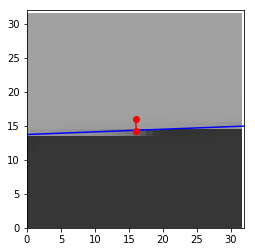

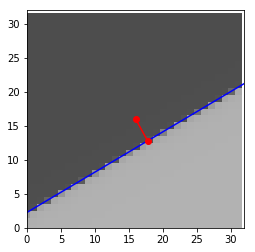

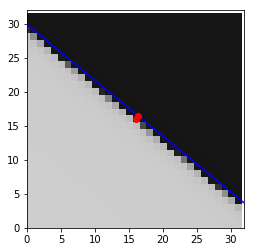

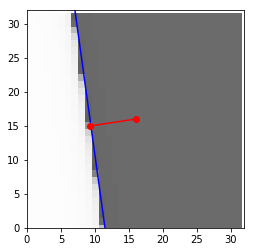

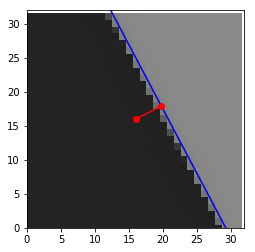

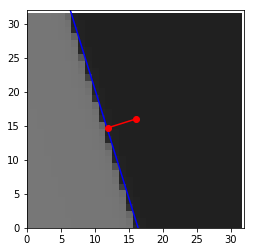

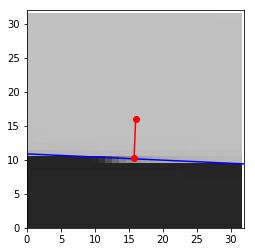

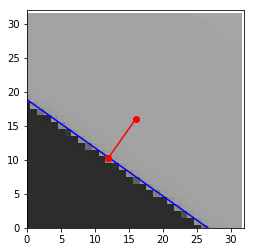

In [57]:
# Plot the Results

# Results are surprisingly good with 13k parameters
# Let's start monitoring generalizability

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
        
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
    
    output_displacement = torch.cat((outputs,torch.ones((len(inputs),1))),dim=1) 
    # Calculate the loss for previous metric
    loss = torch.mean(torch.abs(torch.sum(angle_params*output_displacement,1))) 
    
    print(loss)

    
  
for ii in range(15):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
#     y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
#     plt.plot(x_sample*32+32,y_est*32+32,'r')

    plot_results = torch.stack((torch.tensor([W/2,W/2]),outputs[ii]*W/2+W/2),axis=1)
    
    plt.plot(plot_results[0,:],plot_results[1,:],'ro-')





